# Introdução e Objetivos do Estudo  

Este notebook tem como objetivo **organizar, padronizar e preparar dados experimentais provenientes de um sensor de glicose** instalado em um equipamento de simulação de sangue humano usando colírio.  
Os dados brutos foram coletados em diferentes sessões experimentais, armazenados em múltiplas pastas, e apresentam variações de formato, estrutura e inconsistências que precisam ser tratadas antes de qualquer análise estatística ou modelagem preditiva.  

---

## Fluxo de Trabalho Desenvolvido  

### 1. Unificação de fontes de dados  
- Importação automática dos arquivos de todas as pastas experimentais.  
- Inclusão de metadados que permitem identificar a origem de cada arquivo (*pasta de experimento, nome do arquivo, data/hora*).  

### 2. Padronização e limpeza  
- Normalização de nomes de colunas e tratamento de variações de formato.  
- Conversão de valores **hexadecimais → inteiros**.  
- Extração de *timestamps* reais a partir dos nomes dos arquivos e alinhamento temporal das séries.  
- Identificação e posterior exclusão de colunas redundantes ou com excesso de valores nulos.  

### 3. Estruturação do dataset unificado  
- Combinação dos **100 arquivos experimentais** em um único *dataframe*, contendo **mais de 800 mil linhas**.  
- Garantia de **rastreabilidade**, mantendo a informação sobre a origem de cada observação.  

### 4. Preparação para análise estatística e modelagem  
- O dataset resultante está estruturado para aplicação de técnicas de:  
  - **Padronização/normalização**  
   
  - **Modelos de Regressão**  
- A variável de interesse inicial é a coluna **`TIA`**, que representa o **sinal bruto do sensor** e será utilizada como principal insumo para análise e modelagem.  

---

## Considerações finais  

Este notebook constitui a **etapa inicial de pré-processamento e integração de dados** em um projeto de pesquisa aplicada, preparando o terreno para análises mais avançadas e para o desenvolvimento de modelos preditivos capazes de caracterizar e interpretar o comportamento do sensor de glicose em diferentes condições experimentais.  


# Abaixo esta a imagem da solução utilizada no experiêmento

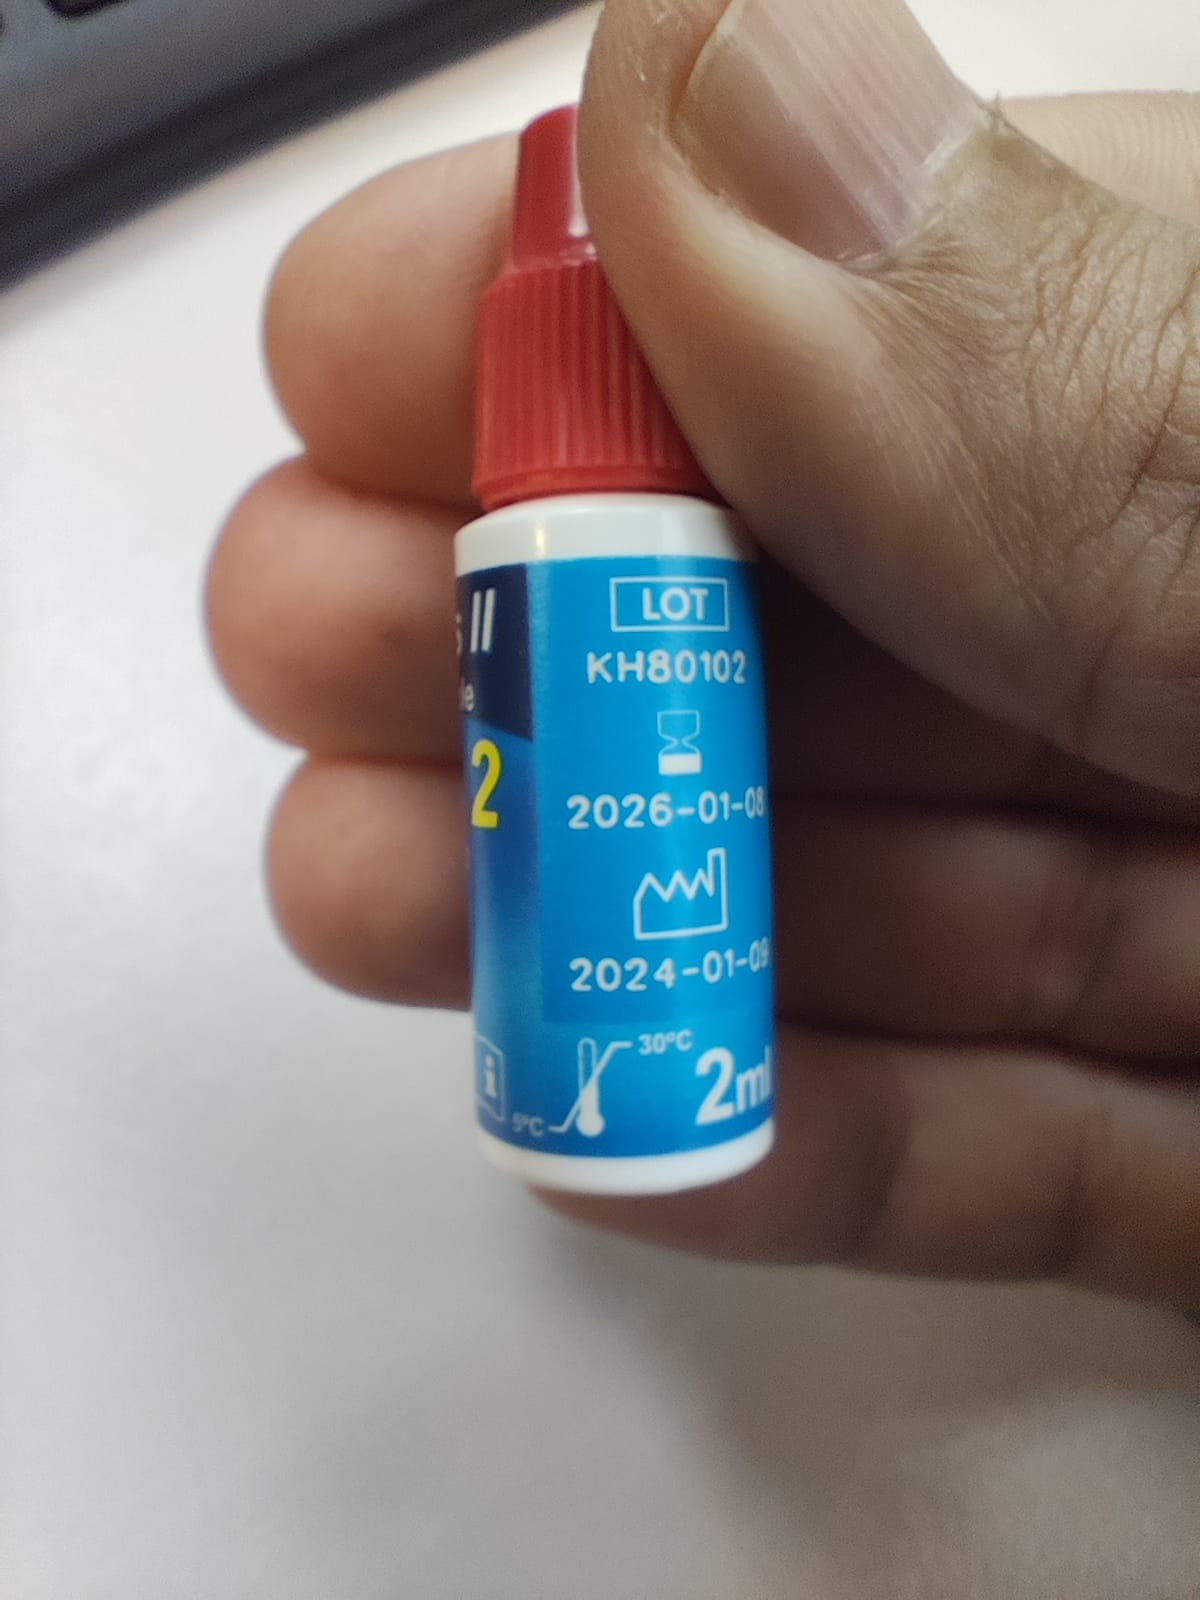

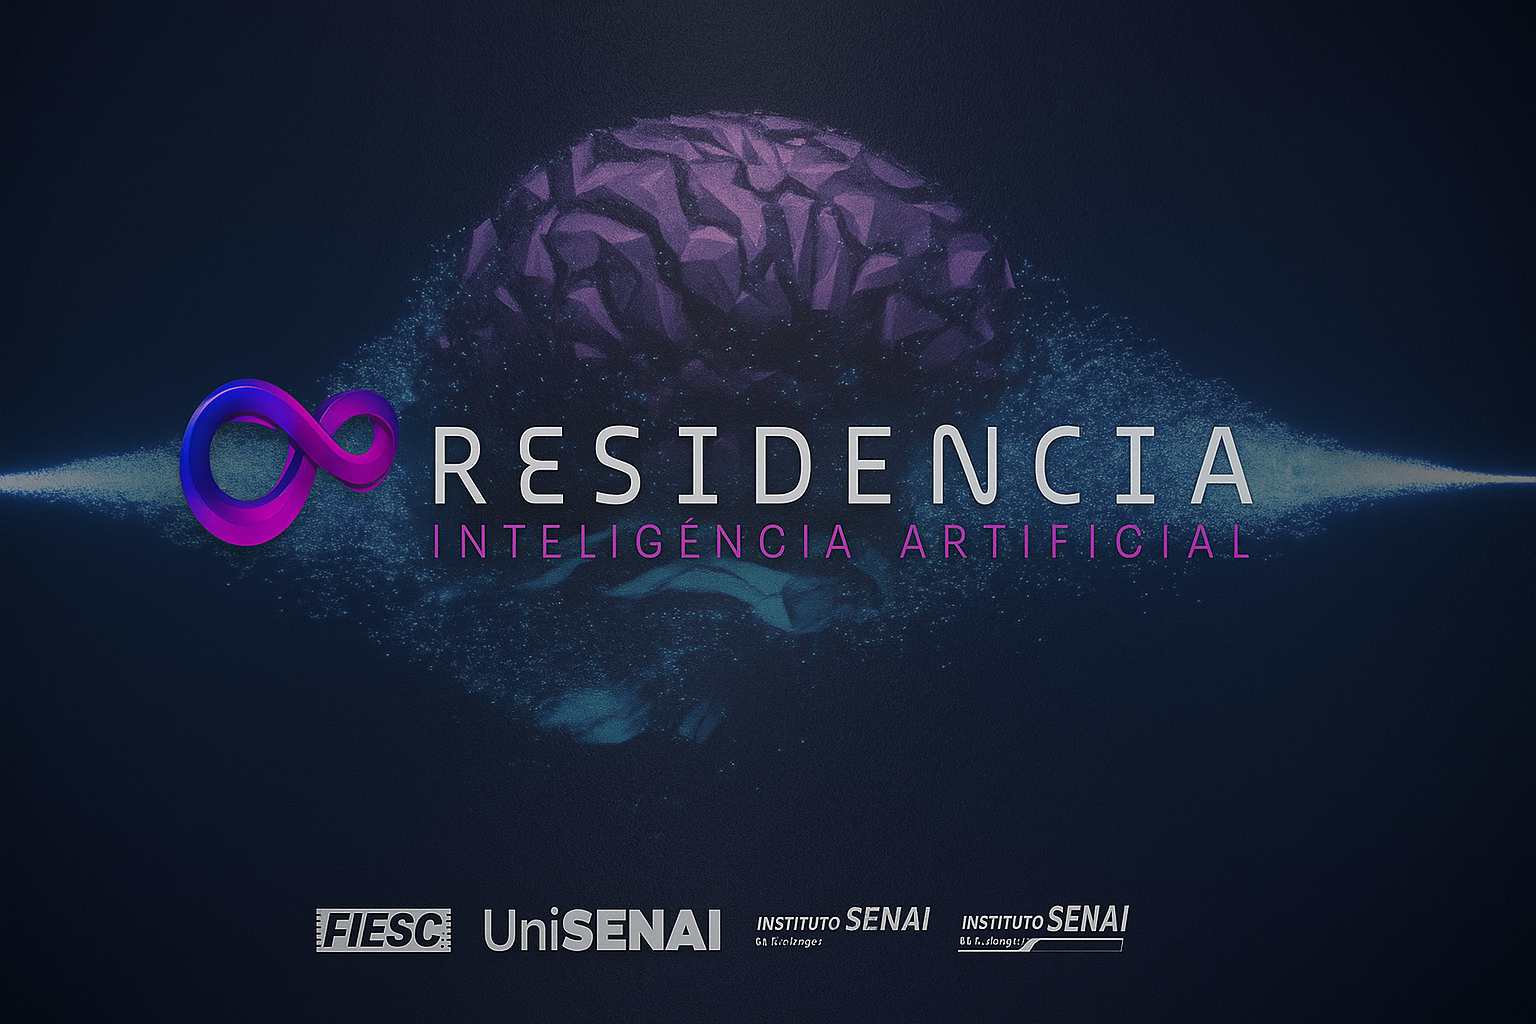

#Equipe:

1.   Julio Cesar Lümke
2.   Emanoel Spanhol
3.   Andreia Nunes Gonçalves
4.   Rosemeri Janiski Bida De Oliveira Borges




# 1- Importando todas as bibliotecas

In [73]:
import glob
import io
import json
import joblib
import os, random
import re
import zipfile
import gradio as gr
import pkg_resources

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import files
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from xgboost import XGBRegressor



# 2- Fazer o upload dos arquivos e fazer as primeiras analises

In [2]:
print("Selecione o arquivo .zip (ex.: Dados_Desafio_02.zip)")
uploaded = files.upload()


# Descobre o primeiro arquivo .zip enviado
a = [n for n in uploaded.keys() if n.lower().endswith('.zip')]
assert len(a) > 0, "Envie um arquivo .zip com seus dados."
zip_name = a[0]


# Extrai o zip na pasta /content
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as z:
    z.extractall('/content')


# Tenta localizar a pasta principal dos dados
candidates = [p for p in glob.glob('/content/*')
if os.path.isdir(p) and os.path.basename(p).lower().startswith('dados_desafio_02')]
base_path = candidates[0] if candidates else '/content/Dados_Desafio_02'
print('base_path =', base_path)

Selecione o arquivo .zip (ex.: Dados_Desafio_02.zip)


Saving Dados_Desafio_02.zip to Dados_Desafio_02.zip
base_path = /content/Dados_Desafio_02


# 3- Listar uma visão geral dos arquivos

In [3]:
data_exts = ('.csv', '.txt')

def list_data_files(root):
    files = []
    for dpath, dnames, fnames in os.walk(root):
        for fn in fnames:
            if fn.lower().endswith(data_exts):
                files.append(os.path.join(dpath, fn))
    return sorted(files)

all_files = list_data_files(base_path)
print(f"Arquivos de dados encontrados: {len(all_files)}")

from collections import Counter
by_folder = Counter(os.path.basename(os.path.dirname(p)) for p in all_files)
for folder, count in by_folder.items():
    print(f"- {folder}: {count} arquivos")

# Mostra alguns exemplos de caminhos
for p in all_files[:5]:
    print("ex:", p)



Arquivos de dados encontrados: 101
- Dados_Desafio_02: 1 arquivos
- Nivel 3: 20 arquivos
- Nivel1: 20 arquivos
- Solução 0: 20 arquivos
- Solução 1: 20 arquivos
- Solução 2: 20 arquivos
ex: /content/Dados_Desafio_02/Colunas.txt
ex: /content/Dados_Desafio_02/Nivel 3/serial_log_25-07-03-09-20-27.csv
ex: /content/Dados_Desafio_02/Nivel 3/serial_log_25-07-03-09-22-08.csv
ex: /content/Dados_Desafio_02/Nivel 3/serial_log_25-07-03-09-22-42.csv
ex: /content/Dados_Desafio_02/Nivel 3/serial_log_25-07-03-09-30-23.csv


# 4- Funções auxiliares para leitura de CSV/TXT conversão de valores hexadecimais para inteiros. Extração de file_datetime a partir do nome do arquivo. Função clean_one_file() que padroniza cada dataset. Criação de colunas de metadados: file_datetime, timestamp, folder, file_name e origem. Remoção da coluna reaction_timestamp.

In [4]:
# ---------------------------
# PARTE 3 — Funções utilitárias
# ---------------------------

# ---------------------------
# (1) Remove arquivos de documentação da lista
# ---------------------------
try:
    all_files = [p for p in all_files if 'colunas' not in os.path.basename(p).lower()]
    print("Arquivos após filtrar 'colunas':", len(all_files))
except NameError:
    print("Variável all_files não encontrada — rode a Parte 2 primeiro para gerar a lista de arquivos.")

# ---------------------------
# Configurações de nomes
# ---------------------------
# Mapeia nomes padronizados das colunas (caso arquivos tenham cabeçalho)
RENAME_MAP = {
    'Time (ms)': 'time_ms',
    'Time since reaction (ms)': 'time_reaction_ms',
    'TIA (adc)': 'tia',
    'Filter (adc)': 'filter',
    'Peak Detector (adc)': 'peak_detector',
}
EXPECTED = list(RENAME_MAP.values())

# ---------------------------
# 2) Leitura tolerante a diferentes separadores e encodings
# ---------------------------
def read_any_table(path):
    """Tenta ler o arquivo com detecção automática de separador, com fallback para alguns encodings."""
    # tenta com sniff do pandas (engine python)
    for enc in ('utf-8', 'latin1'):
        try:
            return pd.read_csv(path, engine='python', sep=None, encoding=enc)
        except Exception:
            pass
    # tentativas manuais de separadores comuns
    for sep in [',', ';', '\t', '|']:
        for enc in ('utf-8', 'latin1'):
            try:
                return pd.read_csv(path, sep=sep, encoding=enc)
            except Exception:
                pass
    raise RuntimeError(f"Não foi possível ler: {path}")

# ---------------------------
# 3) Conversão hexadecimal -> inteiro
# ---------------------------
def hex_to_int_series(s: pd.Series) -> pd.Series:
    def conv(x):
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x == '':
            return np.nan
        x = x.replace('"', '').replace("'", "")
        try:
            if x.lower().startswith('0x'):
                return int(x, 16)
            if re.fullmatch(r'[-+]?\d+', x):
                return int(x)
            if re.fullmatch(r'[-+]?\d*\.\d+', x):
                return int(float(x))
            return pd.to_numeric(x, errors='coerce')
        except Exception:
            return pd.to_numeric(x, errors='coerce')
    out = s.apply(conv)
    try:
        return out.astype('Int64')
    except Exception:
        return out

# ---------------------------
# 4) Extrai data/hora do nome do arquivo
# ---------------------------
def parse_file_datetime(file_name: str) -> pd.Timestamp:
    m = re.search(r'(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})', file_name)
    if not m:
        return pd.NaT
    yy, mm, dd, hh, mi, ss = map(int, m.groups())
    year = 2000 + yy
    try:
        return pd.Timestamp(year=year, month=mm, day=dd, hour=hh, minute=mi, second=ss)
    except Exception:
        return pd.NaT

# ---------------------------
# 5) Limpeza completa de UM arquivo (robusto para arquivos sem cabeçalho)
# ---------------------------
def clean_one_file(file_path: str) -> pd.DataFrame:
    basename = os.path.basename(file_path).lower()
    if 'colunas' in basename:
        raise ValueError("Arquivo de documentação — pulando")

    # Lê sem cabeçalho
    df = pd.read_csv(file_path, header=None, sep=None, engine='python')

    # Define nomes padrão
    colunas_padrao = ['time_ms', 'time_reaction_ms', 'tia', 'filter', 'peak_detector']
    if df.shape[1] == len(colunas_padrao):
        df.columns = colunas_padrao
    else:
        df.columns = [f'col_{i}' for i in range(df.shape[1])]

    # Converte hex->int nas colunas que existem
    for col in ['time_ms', 'time_reaction_ms', 'tia', 'filter', 'peak_detector']:
        if col in df.columns:
            df[col] = hex_to_int_series(df[col])

    # Extrai datetime do arquivo
    fdt = parse_file_datetime(os.path.basename(file_path))
    df['file_datetime'] = fdt

    # Constrói timestamps
    if 'time_ms' in df.columns:
        df['timestamp'] = df['file_datetime'] + pd.to_timedelta(df['time_ms'].astype('float'), unit='ms')
    else:
        df['timestamp'] = pd.NaT
    if 'time_reaction_ms' in df.columns:
        df['reaction_timestamp'] = df['file_datetime'] + pd.to_timedelta(df['time_reaction_ms'].astype('float'), unit='ms')
    else:
        df['reaction_timestamp'] = pd.NaT

    # Metadados
    df['folder'] = os.path.basename(os.path.dirname(file_path))
    df['file_name'] = os.path.basename(file_path)
    df['origem'] = df['folder']

    # Ordena se timestamp existir
    if df['timestamp'].notna().any():
        df = df.sort_values('timestamp').reset_index(drop=True)

    return df




Arquivos após filtrar 'colunas': 100


# 5- Verificação dos dados

In [5]:
if 'all_files' in globals() and len(all_files) > 0:
    exemplo = all_files[0]
    print("Testando em:", exemplo)
    df_ex = clean_one_file(exemplo)
    display(df_ex.head())
else:
    print("Nenhum arquivo exemplo disponível em all_files.")

Testando em: /content/Dados_Desafio_02/Nivel 3/serial_log_25-07-03-09-20-27.csv


col_0    col_1    col_2    col_3       file_datetime timestamp  \
0  0x00000000   0x0000   0x0008   0x0006 2025-07-03 09:20:27       NaT   
1  0x00000004   0x0000   0x0008   0x0005 2025-07-03 09:20:27       NaT   
2  0x0000000C   0x0000   0x0008   0x0006 2025-07-03 09:20:27       NaT   
3  0x00000014   0x0000   0x0008   0x000A 2025-07-03 09:20:27       NaT   
4  0x0000001C   0x0000   0x0008   0x0004 2025-07-03 09:20:27       NaT   

  reaction_timestamp   folder                         file_name   origem  
0                NaT  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
1                NaT  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
2                NaT  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
3                NaT  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
4                NaT  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3

# 6- Processar todos os arquivos em all_files. Aplicar a função clean_one_file() em cada arquivo. Coletar eventuais erros de leitura/conversão (para não travar o processamento). Unir todos os dados em um único DataFrame (df_all). Salvar o CSV final pronto para análise.

In [6]:
def clean_one_file(file_path: str) -> pd.DataFrame:
    """
    Lê e normaliza um arquivo:
    - lê CSV/TXT robustamente, mesmo que sem separador claro
    - renomeia colunas
    - converte hex -> int nas colunas esperadas
    - extrai file_datetime do nome do arquivo
    - cria timestamp = file_datetime + time_ms (em ms)
    - adiciona metadados: folder, file_name
    - remove reaction_timestamp que não possui dados
    """
    basename = os.path.basename(file_path).lower()
    if 'colunas' in basename:
        raise ValueError("Arquivo de documentação — pulando")

    # --------- Leitura robusta ---------
    try:
        df = read_any_table(file_path)
    except:
        # fallback: assume que os valores estão separados por espaços
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)

    # Limpa nomes de colunas
    df.columns = [str(c).strip() for c in df.columns]

    # Renomeia colunas existentes
    df = df.rename(columns=RENAME_MAP)

    # Para arquivos sem cabeçalho, define nomes padrão das primeiras 4 colunas
    if set(EXPECTED).isdisjoint(df.columns):
        df.columns = EXPECTED[:len(df.columns)] + list(df.columns[len(EXPECTED):])

    # Converte colunas hex -> int
    for col in EXPECTED:
        if col in df.columns:
            df[col] = hex_to_int_series(df[col])

    # Extrai datetime do nome do arquivo
    fdt = parse_file_datetime(os.path.basename(file_path))
    df['file_datetime'] = fdt

    # Constrói timestamps reais
    if 'time_ms' in df.columns:
        df['timestamp'] = df['file_datetime'] + pd.to_timedelta(df['time_ms'].astype('float'), unit='ms')
    else:
        df['timestamp'] = pd.NaT

    # Metadados
    df['folder'] = os.path.basename(os.path.dirname(file_path))
    df['file_name'] = os.path.basename(file_path)
    df['origem'] = df['folder']

    # Remove coluna inútil
    df = df.drop(columns=['reaction_timestamp'], errors='ignore')

    # Ordena por timestamp se existir
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        df = df.sort_values('timestamp').reset_index(drop=True)

    return df


# 7- Pré visualização

In [7]:
df_ex = clean_one_file(exemplo)
display(df_ex.head())


time_ms  time_reaction_ms  tia  filter       file_datetime  \
0        4                 0    8       5 2025-07-03 09:20:27   
1       12                 0    8       6 2025-07-03 09:20:27   
2       20                 0    8      10 2025-07-03 09:20:27   
3       28                 0    8       4 2025-07-03 09:20:27   
4       36                 0    6       7 2025-07-03 09:20:27   

                timestamp   folder                         file_name   origem  
0 2025-07-03 09:20:27.004  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
1 2025-07-03 09:20:27.012  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
2 2025-07-03 09:20:27.020  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
3 2025-07-03 09:20:27.028  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3  
4 2025-07-03 09:20:27.036  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3

# 8- Processamento e unificação

In [8]:
# ---------------------------
# PARTE 4 — Processa todos os arquivos e unifica
# ---------------------------

import tqdm  # para barra de progresso

df_list = []
erros = []

for f in tqdm.tqdm(all_files, desc="Processando arquivos"):
    try:
        df_clean = clean_one_file(f)
        df_list.append(df_clean)
    except Exception as e:
        erros.append((f, str(e)))

# Une todos os DataFrames
if df_list:
    df_all = pd.concat(df_list, ignore_index=True)
    print(f"Todos os arquivos processados! Total linhas: {len(df_all)}")
else:
    df_all = pd.DataFrame()
    print("Nenhum arquivo processado com sucesso.")

# Mostra primeiros registros
display(df_all.head())

# Salva CSV final
df_all.to_csv("/content/df_all_unificado.csv", index=False)
print("CSV unificado salvo em: /content/df_all_unificado.csv")

# Mostra arquivos que deram erro (se houver)
if erros:
    print("\nArquivos com erro:")
    for f, msg in erros:
        print(f"{f} -> {msg}")


Processando arquivos: 100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


Todos os arquivos processados! Total linhas: 823082


time_ms  time_reaction_ms  tia  filter       file_datetime  \
0        4                 0    8       5 2025-07-03 09:20:27   
1       12                 0    8       6 2025-07-03 09:20:27   
2       20                 0    8      10 2025-07-03 09:20:27   
3       28                 0    8       4 2025-07-03 09:20:27   
4       36                 0    6       7 2025-07-03 09:20:27   

                timestamp   folder                         file_name   origem  \
0 2025-07-03 09:20:27.004  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
1 2025-07-03 09:20:27.012  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
2 2025-07-03 09:20:27.020  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
3 2025-07-03 09:20:27.028  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
4 2025-07-03 09:20:27.036  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   

   peak_detector  
0           <NA>  
1           <NA>  
2           <NA>  
3           <NA>  
4           <NA>

CSV unificado salvo em: /content/df_all_unificado.csv


# 9- Carregar o dataset unificado e verificar valores nulos ou auxentes

In [9]:
# Carrega o CSV unificado
df_all_unificado = pd.read_csv('/content/df_all_unificado.csv')

# Converte file_datetime e timestamp para datetime
df_all_unificado['file_datetime'] = pd.to_datetime(df_all_unificado['file_datetime'], errors='coerce')
df_all_unificado['timestamp'] = pd.to_datetime(df_all_unificado['timestamp'], errors='coerce')

# Agora mostramos valores nulos e zeros
print("Valores nulos por coluna:")
print(df_all_unificado.isna().sum())

print("\nValores zero por coluna:")
for col in df_all_unificado.select_dtypes(include=np.number).columns:
    zeros = (df_all_unificado[col] == 0).sum()
    if zeros > 0:
        print(f"{col}: {zeros} zeros")


Valores nulos por coluna:
time_ms                  0
time_reaction_ms         0
tia                      0
filter                   0
file_datetime            0
timestamp                0
folder                   0
file_name                0
origem                   0
peak_detector       412748
dtype: int64

Valores zero por coluna:
time_ms: 4 zeros
time_reaction_ms: 80144 zeros
tia: 11355 zeros
filter: 2506 zeros


# 10- Optamos em não deletar as colunas com valores = zero pois são dados válidos. Porém a coluna peak_detector iremos substituir os valores NaN por zero ou seja não houve leitura nestes casos.

In [10]:
# Substituir valores NaN na coluna 'peak_detector' por 0
df_all_unificado['peak_detector'] = df_all_unificado['peak_detector'].fillna(0)

print("Valores NaN na coluna 'peak_detector' substituídos por 0.")

# Verificar a mudança mostrando a contagem de valores nulos novamente
print("\nValores nulos por coluna após a substituição em 'peak_detector':")
print(df_all_unificado.isna().sum())

Valores NaN na coluna 'peak_detector' substituídos por 0.

Valores nulos por coluna após a substituição em 'peak_detector':
time_ms             0
time_reaction_ms    0
tia                 0
filter              0
file_datetime       0
timestamp           0
folder              0
file_name           0
origem              0
peak_detector       0
dtype: int64


# 11- Dimensões do dataset

In [11]:
print("Tamanho do dataset unificado (linhas, colunas):")
print(df_all_unificado.shape)

Tamanho do dataset unificado (linhas, colunas):
(823082, 10)


# 12- Verificando novamente se a valores nulos ou ausentes e colunas que possuem valores = zero

In [12]:
# Agora mostramos valores nulos e zeros
print("Valores nulos por coluna:")
print(df_all_unificado.isna().sum())

print("\nValores zero por coluna:")
for col in df_all_unificado.select_dtypes(include=np.number).columns:
    zeros = (df_all_unificado[col] == 0).sum()
    if zeros > 0:
        print(f"{col}: {zeros} zeros")

Valores nulos por coluna:
time_ms             0
time_reaction_ms    0
tia                 0
filter              0
file_datetime       0
timestamp           0
folder              0
file_name           0
origem              0
peak_detector       0
dtype: int64

Valores zero por coluna:
time_ms: 4 zeros
time_reaction_ms: 80144 zeros
tia: 11355 zeros
filter: 2506 zeros
peak_detector: 412748 zeros


# 13- Analise de séries temporais

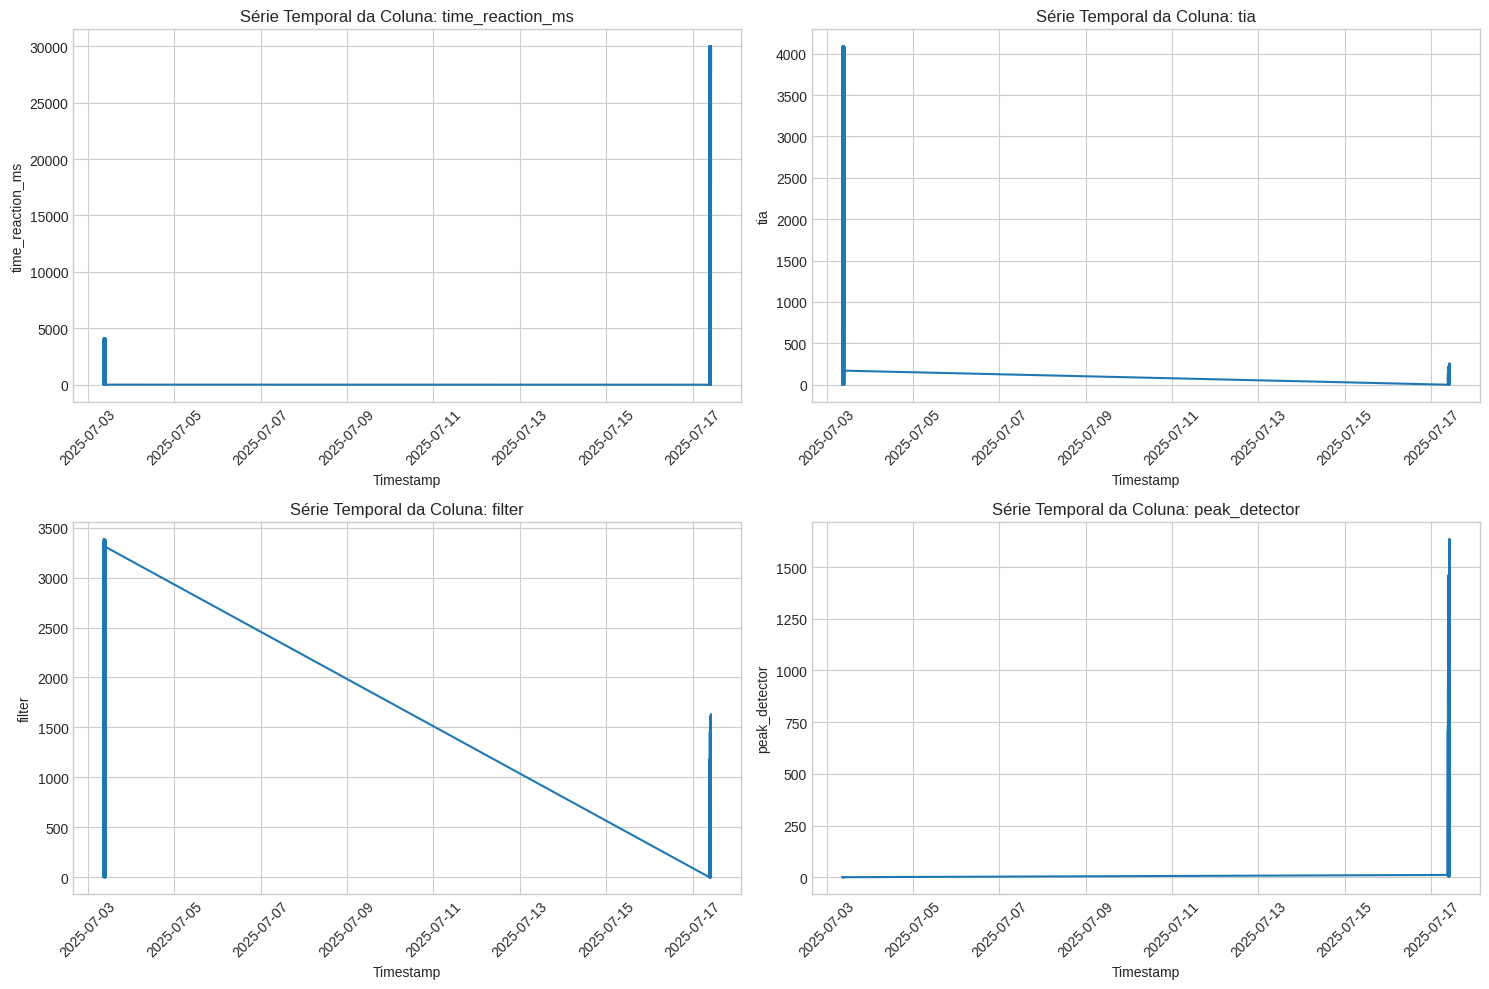

In [13]:
# Selecionar colunas numéricas para plotagem, excluindo 'time_ms' pois 'timestamp' é mais informativo
numeric_cols = df_all_unificado.select_dtypes(include=np.number).columns.tolist()
cols_to_plot = [col for col in numeric_cols if col not in ['time_ms']]

# Definir o número de colunas por linha para os subplots
n_cols = 2
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Achatar para facilitar a iteração

for i, col in enumerate(cols_to_plot):
    if col in df_all_unificado.columns:
        # Plotar usando timestamp no eixo x
        axes[i].plot(df_all_unificado['timestamp'], df_all_unificado[col])
        axes[i].set_title(f'Série Temporal da Coluna: {col}')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    else:
        # Oculta o subplot se não houver coluna para plotar
        fig.delaxes(axes[i])


# Ocultar subplots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

# 14- Verificação de outliers

Análise de Outliers (Regra do Quartil):

Coluna: time_ms
  Q1: 9111.00
  Q3: 28087.00
  IQR: 18976.00
  Limite Inferior (1.5*IQR): -19353.00
  Limite Superior (1.5*IQR): 56551.00
  Número de Outliers: 11723
  Porcentagem de Outliers: 1.42%

Coluna: time_reaction_ms
  Q1: 59.00
  Q3: 12853.00
  IQR: 12794.00
  Limite Inferior (1.5*IQR): -19132.00
  Limite Superior (1.5*IQR): 32044.00
  Número de Outliers: 0
  Porcentagem de Outliers: 0.00%

Coluna: tia
  Q1: 74.00
  Q3: 461.00
  IQR: 387.00
  Limite Inferior (1.5*IQR): -506.50
  Limite Superior (1.5*IQR): 1041.50
  Número de Outliers: 166138
  Porcentagem de Outliers: 20.18%

Coluna: filter
  Q1: 469.00
  Q3: 1461.00
  IQR: 992.00
  Limite Inferior (1.5*IQR): -1019.00
  Limite Superior (1.5*IQR): 2949.00
  Número de Outliers: 21391
  Porcentagem de Outliers: 2.60%

Coluna: peak_detector
  Q1: 0.00
  Q3: 871.00
  IQR: 871.00
  Limite Inferior (1.5*IQR): -1306.50
  Limite Superior (1.5*IQR): 2177.50
  Número de Outliers: 0
  Porcentagem d

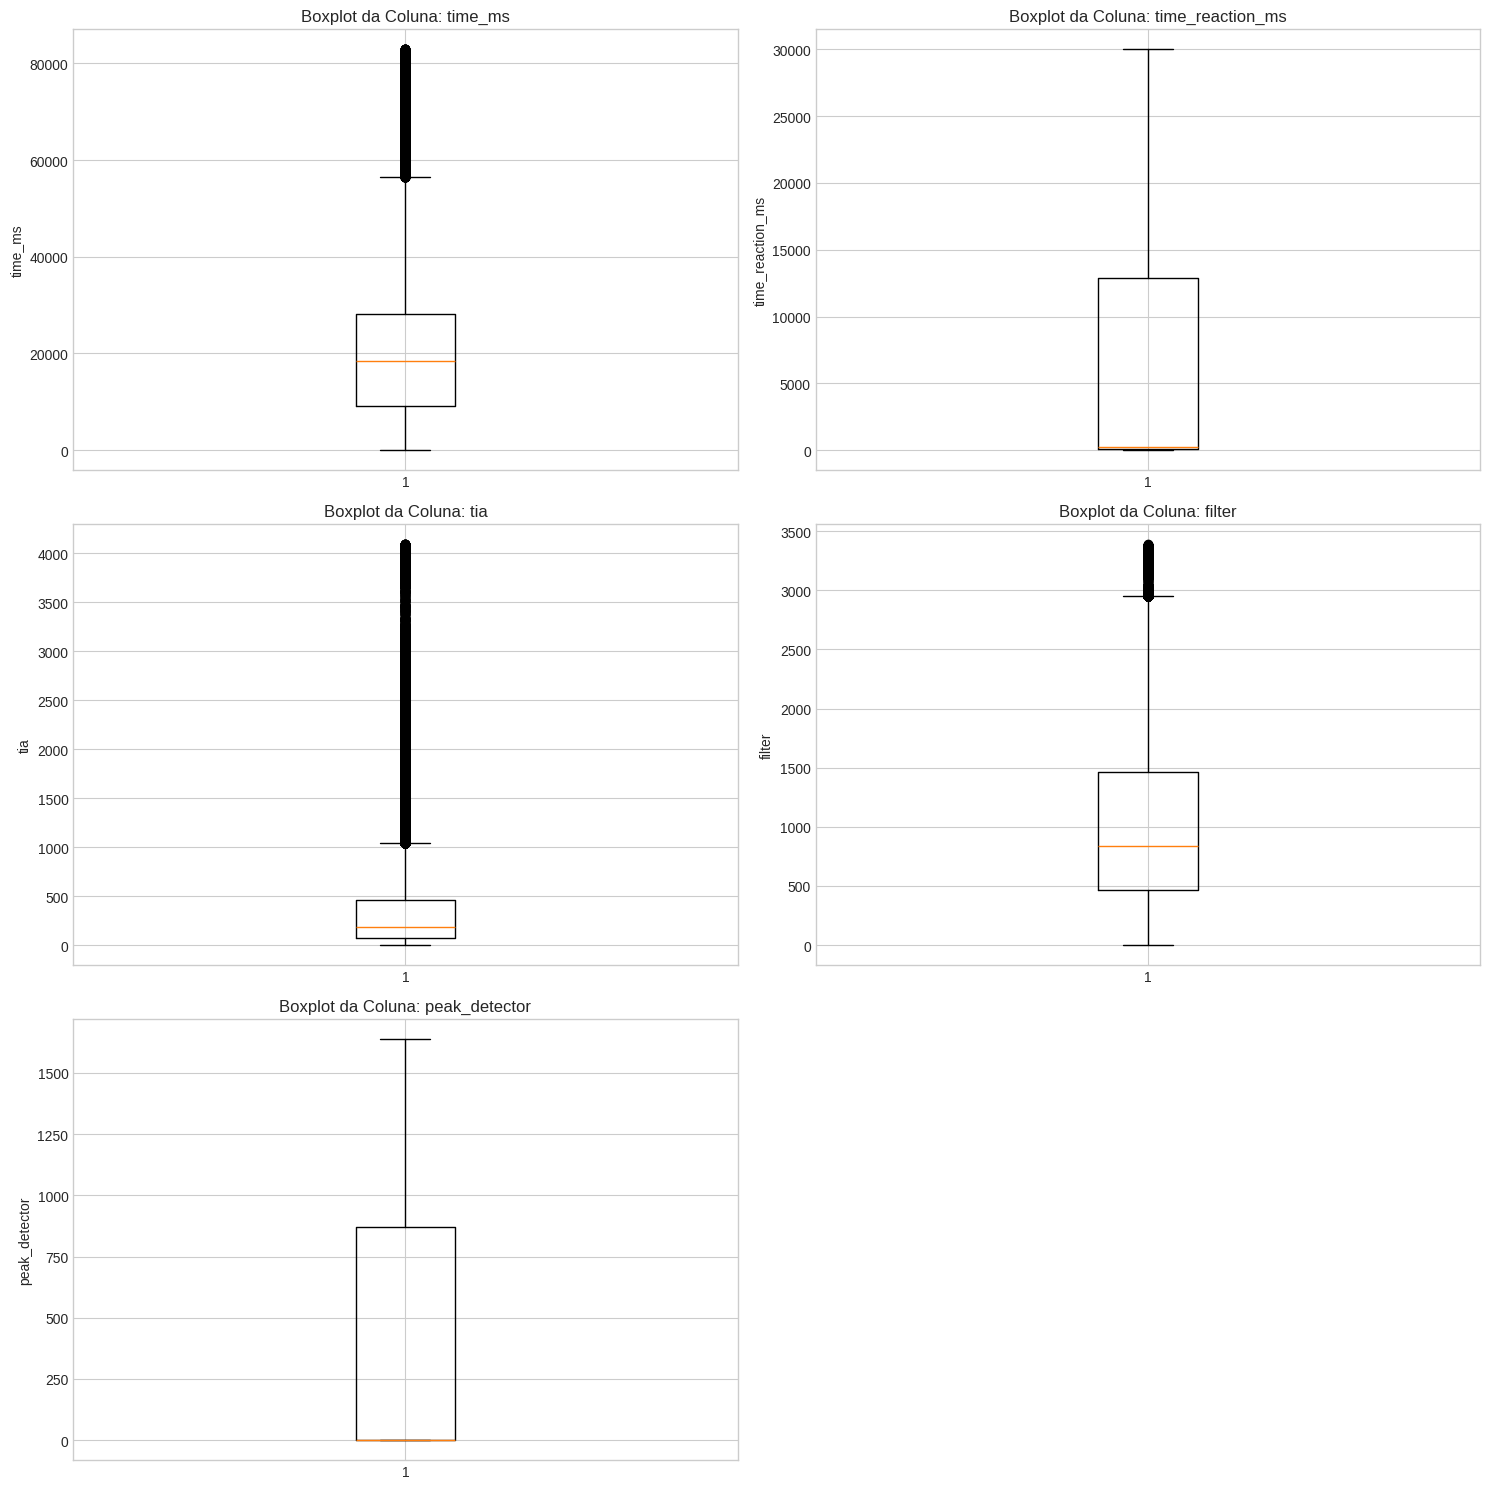

In [14]:
# Verificar a existência de outliers usando a regra do quartil e plotar boxplots

# Selecionar colunas numéricas para análise de outliers
numeric_cols = df_all_unificado.select_dtypes(include=np.number).columns.tolist()

print("Análise de Outliers (Regra do Quartil):")

outliers_info = {}

for col in numeric_cols:
    Q1 = df_all_unificado[col].quantile(0.25)
    Q3 = df_all_unificado[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_all_unificado[(df_all_unificado[col] < lower_bound) | (df_all_unificado[col] > upper_bound)]

    outliers_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': len(outliers),
        'Percentage of Outliers': (len(outliers) / len(df_all_unificado)) * 100
    }

    print(f"\nColuna: {col}")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Limite Inferior (1.5*IQR): {lower_bound:.2f}")
    print(f"  Limite Superior (1.5*IQR): {upper_bound:.2f}")
    print(f"  Número de Outliers: {outliers_info[col]['Number of Outliers']}")
    print(f"  Porcentagem de Outliers: {outliers_info[col]['Percentage of Outliers']:.2f}%")


# Gerar boxplots para todas as colunas numéricas
print("\nGerando Boxplots:")

n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df_all_unificado[col].dropna()) # Usar dropna para lidar com NaNs no boxplot
    axes[i].set_title(f'Boxplot da Coluna: {col}')
    axes[i].set_ylabel(col)


# Ocultar subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 15- Gráficos por data

Gerando Gráficos de Colunas por Data:


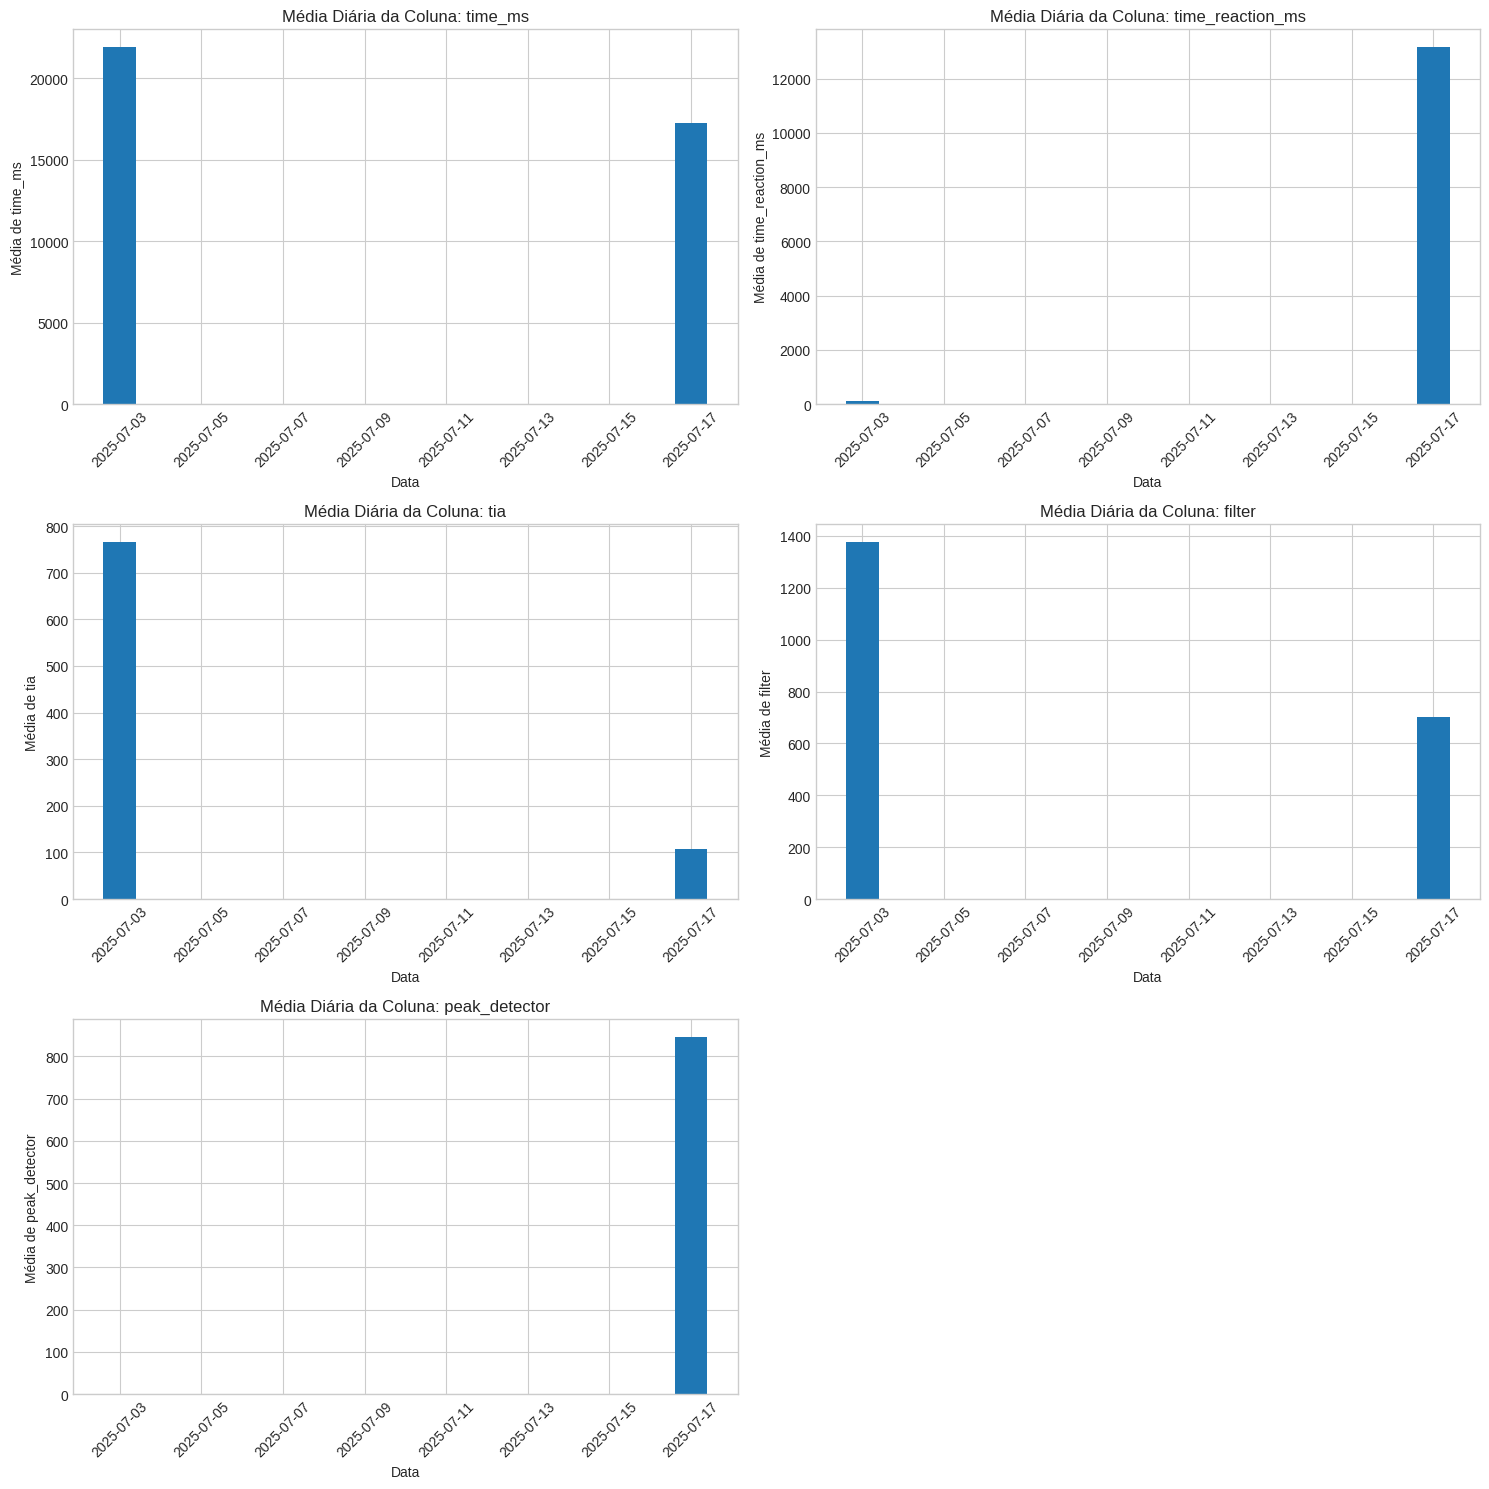

In [15]:
# Extrair a data do timestamp
df_all_unificado['date'] = df_all_unificado['timestamp'].dt.date

# Agrupar por data e calcular a média (ou outra agregação) das colunas numéricas
df_daily_avg = df_all_unificado.groupby('date')[numeric_cols].mean().reset_index()

# Gerar gráficos de colunas para cada coluna numérica
print("Gerando Gráficos de Colunas por Data:")

n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if col in df_daily_avg.columns:
        axes[i].bar(df_daily_avg['date'], df_daily_avg[col])
        axes[i].set_title(f'Média Diária da Coluna: {col}')
        axes[i].set_xlabel('Data')
        axes[i].set_ylabel(f'Média de {col}')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        fig.delaxes(axes[i])

# Ocultar subplots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 16- Graficos de disperção por minuto de leitura dos sensores

Gerando Gráficos de Dispersão por Minuto:


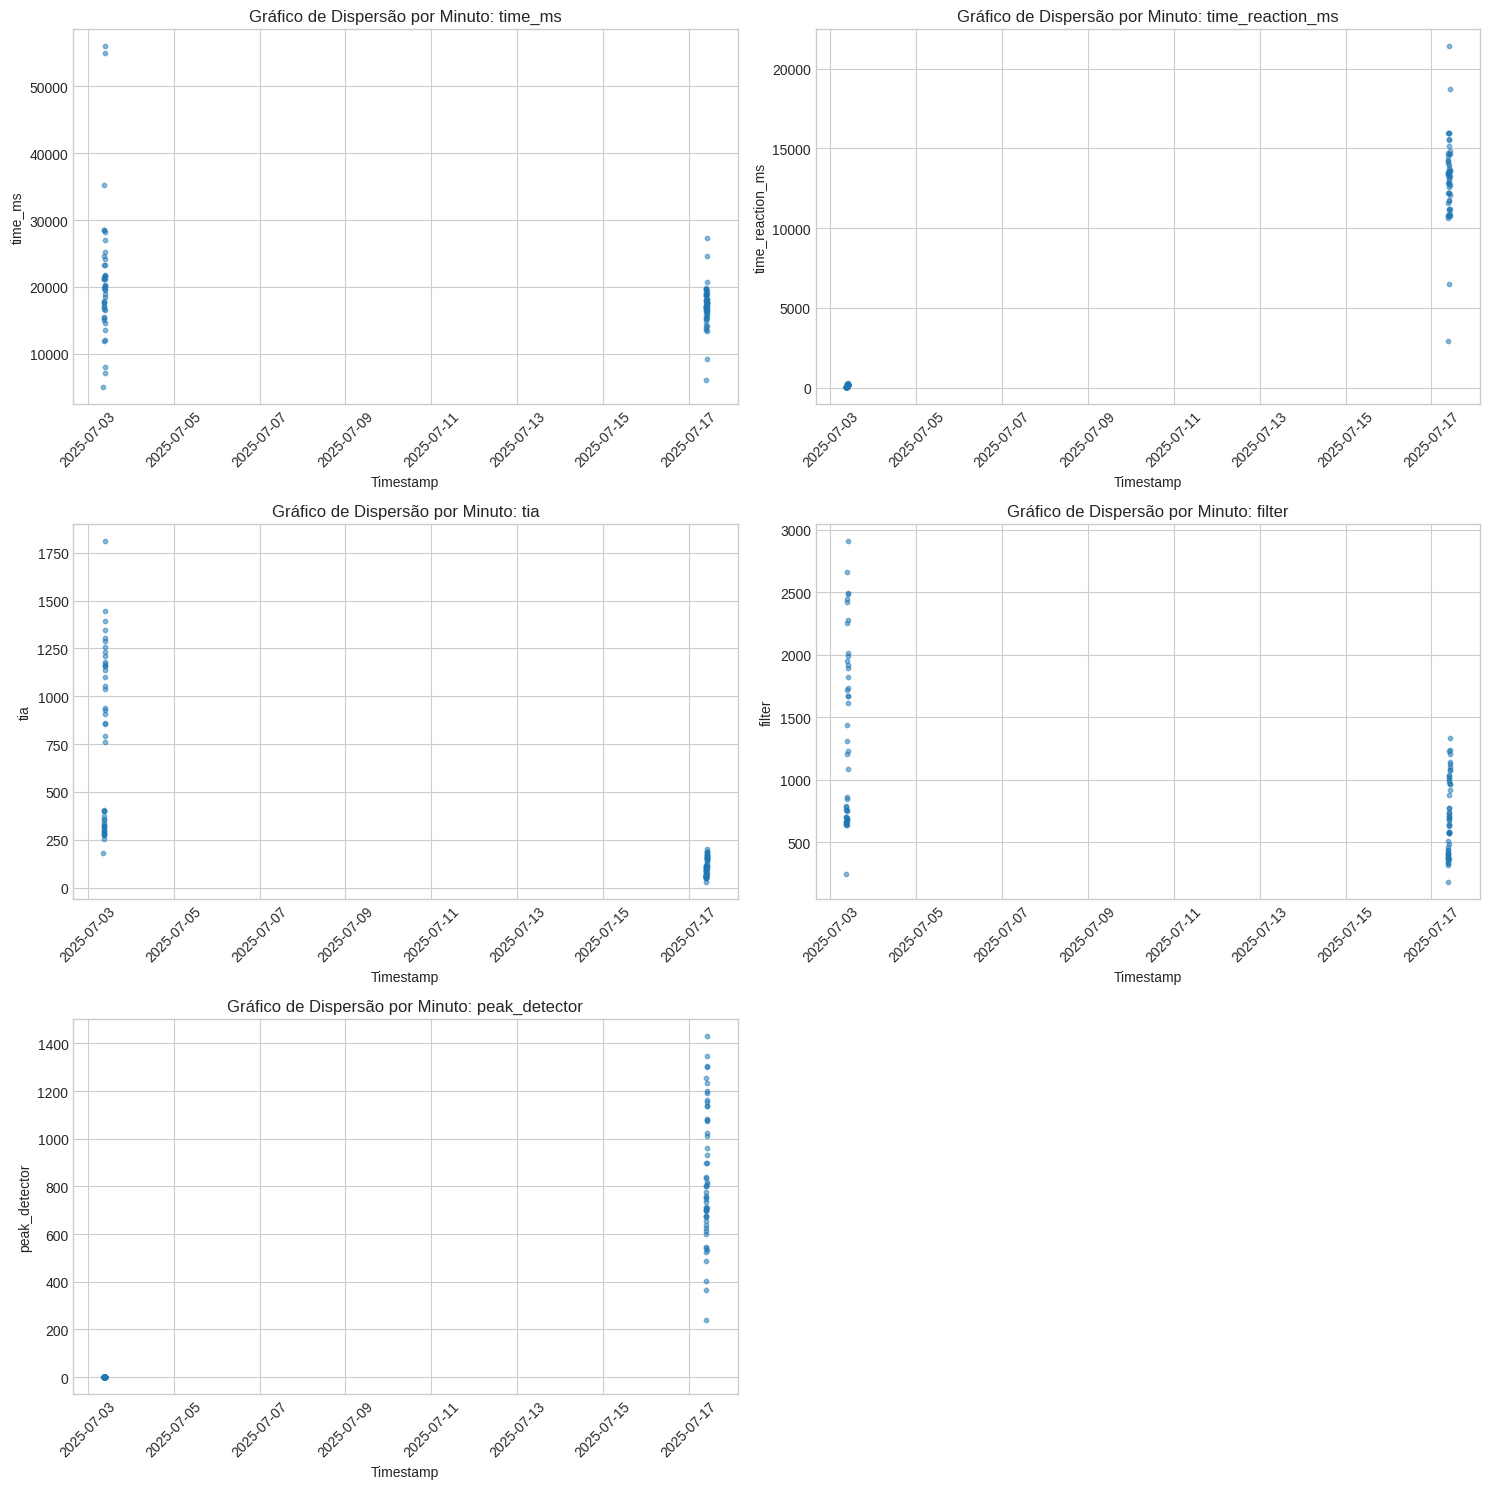

In [16]:
# Resample the data to minute frequency and take the mean
# Select only numeric columns for resampling and mean aggregation
numeric_cols_resample = df_all_unificado.select_dtypes(include=np.number).columns.tolist()
df_all_unificado_minute = df_all_unificado.set_index('timestamp')[numeric_cols_resample].resample('min').mean().reset_index()


# Select numerical columns for plotting (these are already numeric after resampling)
numeric_cols_plot = df_all_unificado_minute.select_dtypes(include=np.number).columns.tolist()

print("Gerando Gráficos de Dispersão por Minuto:")

n_cols = 2
# Adjust n_rows based on the number of numeric columns after resampling
n_rows = (len(numeric_cols_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_plot):
    if col in df_all_unificado_minute.columns:
        # Plot using timestamp on the x-axis and the numerical column on the y-axis
        axes[i].scatter(df_all_unificado_minute['timestamp'], df_all_unificado_minute[col], alpha=0.5, s=10) # Use alpha and s for better visualization with many points
        axes[i].set_title(f'Gráfico de Dispersão por Minuto: {col}')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    else:
        # Hide the subplot if there is no column to plot
        fig.delaxes(axes[i])

# Hide empty subplots, if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Os gráficos mostram que teve leituras em datas e tempos  expecíficos e abaixo uma visualização da coluna time_ms.

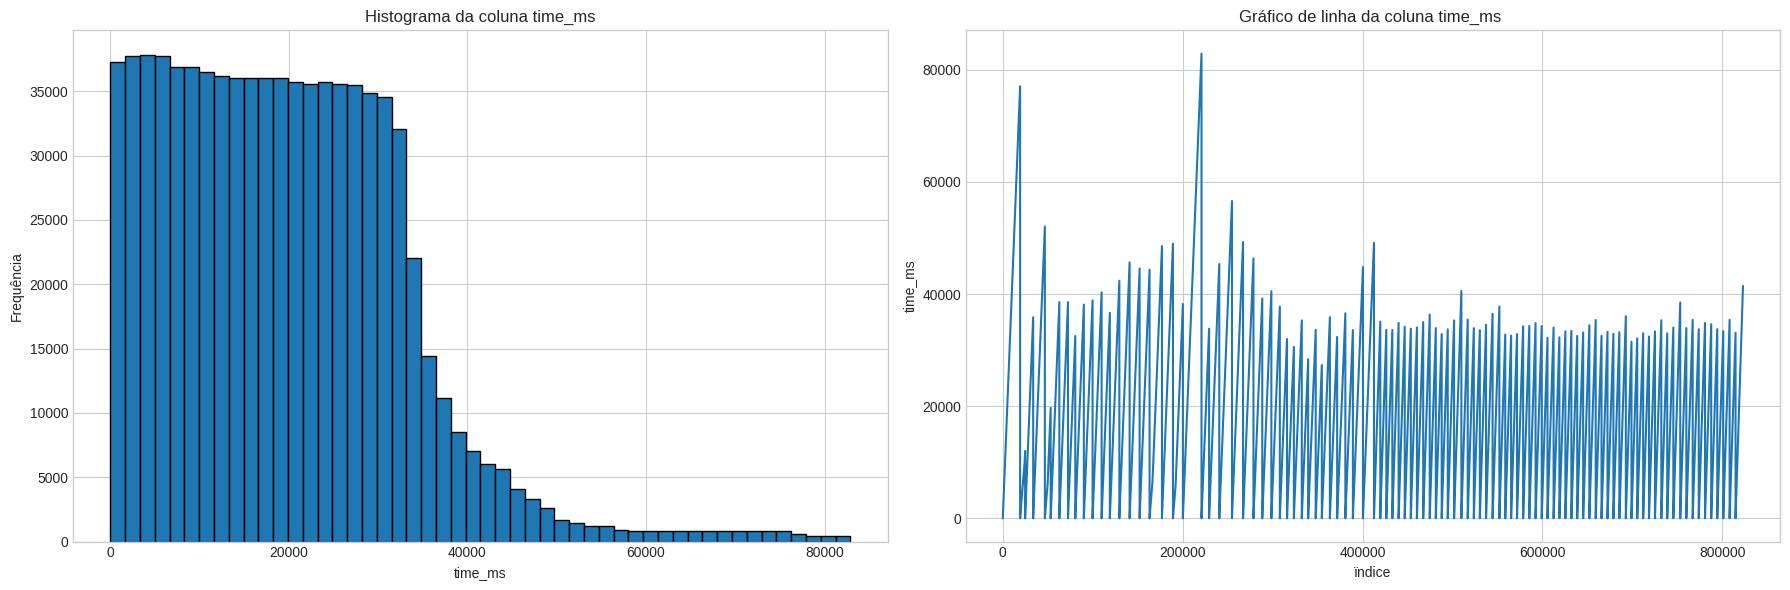

In [17]:

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma do filter
axes[0].hist(df_all_unificado['time_ms'], bins=50, edgecolor='black')
axes[0].set_title('Histograma da coluna time_ms')
axes[0].set_xlabel('time_ms')
axes[0].set_ylabel('Frequência')
axes[0].grid(True)

# Gráfico de linha do filter
axes[1].plot( df_all_unificado['time_ms'])
axes[1].set_title('Gráfico de linha da coluna time_ms ')
axes[1].set_xlabel('ïndice')
axes[1].set_ylabel('time_ms')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Abaixo histograma da coluna 'tia'

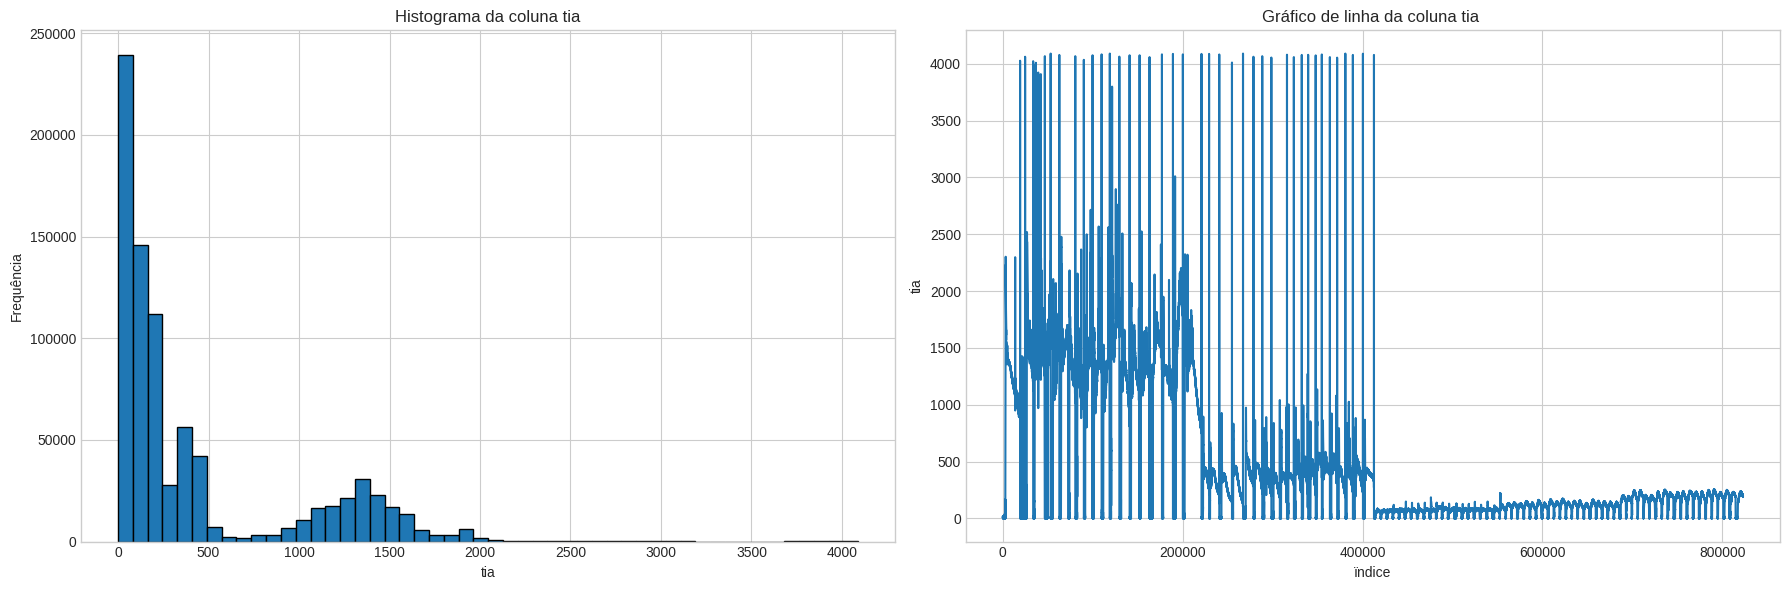

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma do filter
axes[0].hist(df_all_unificado['tia'], bins=50, edgecolor='black')
axes[0].set_title('Histograma da coluna tia')
axes[0].set_xlabel('tia')
axes[0].set_ylabel('Frequência')
axes[0].grid(True)

# Gráfico de linha do filter
axes[1].plot( df_all_unificado['tia'])
axes[1].set_title('Gráfico de linha da coluna tia ')
axes[1].set_xlabel('ïndice')
axes[1].set_ylabel('tia')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Histograma da coluna 'filter'

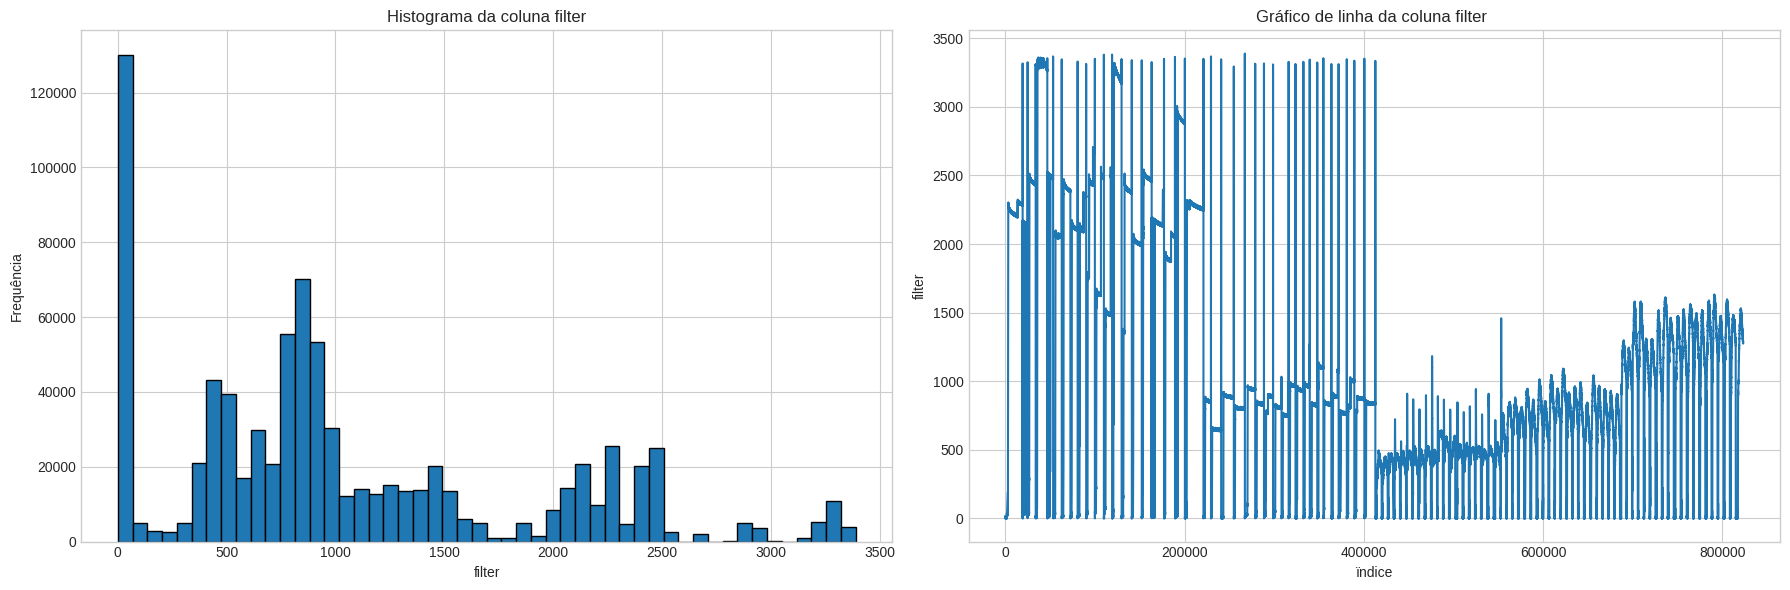

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma do filter
axes[0].hist(df_all_unificado['filter'], bins=50, edgecolor='black')
axes[0].set_title('Histograma da coluna filter')
axes[0].set_xlabel('filter')
axes[0].set_ylabel('Frequência')
axes[0].grid(True)

# Gráfico de linha do filter
axes[1].plot( df_all_unificado['filter'])
axes[1].set_title('Gráfico de linha da coluna filter ')
axes[1].set_xlabel('ïndice')
axes[1].set_ylabel('filter')
axes[1].grid(True)

plt.tight_layout()
plt.show()


# 17- Boxplot para visualizar outliers por leitura dos sensores por minuto

Gerando Boxplots por Minuto:


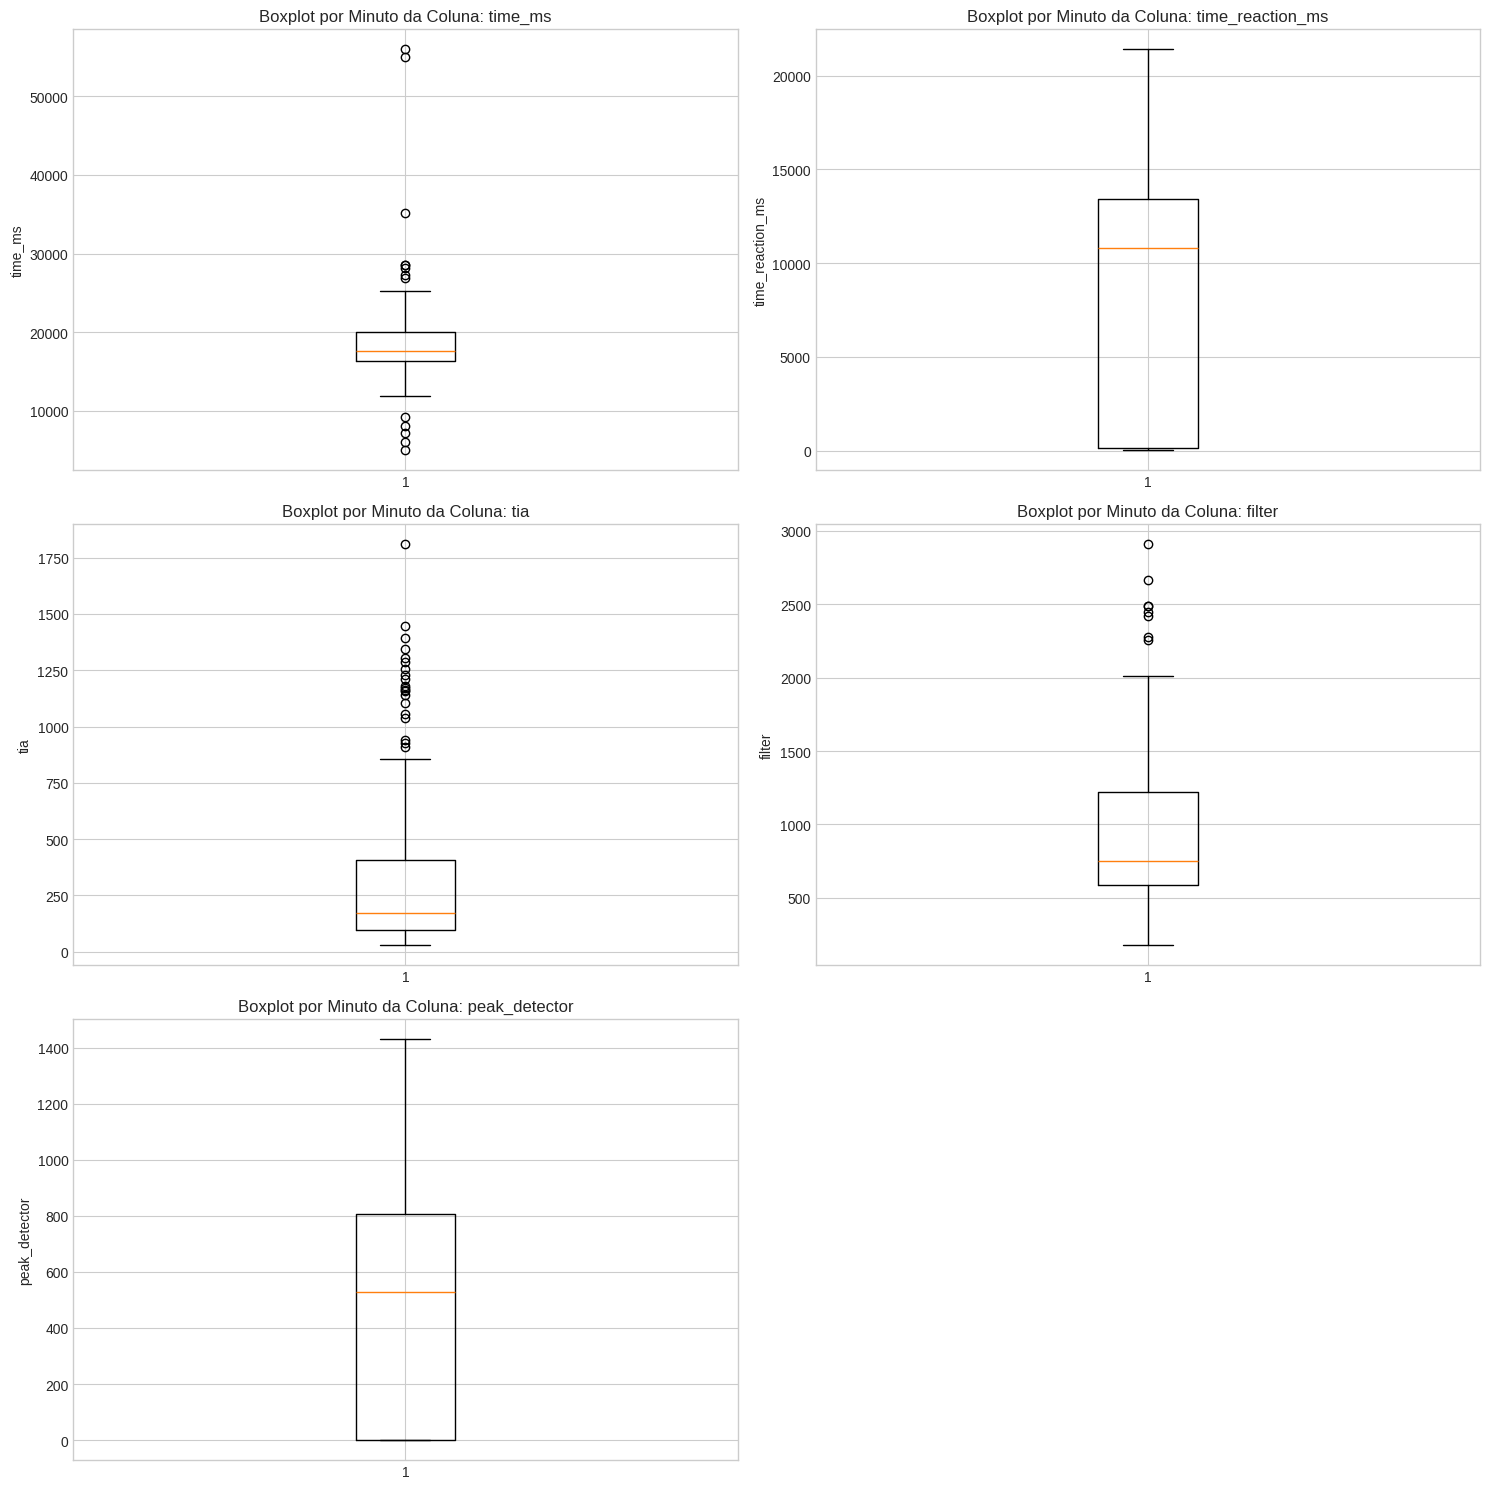

In [20]:
# Gerar boxplots das colunas no dataset reamostrado por minuto

# Selecionar colunas numéricas para plotagem (já são numéricas após resample)
numeric_cols_plot_minute = df_all_unificado_minute.select_dtypes(include=np.number).columns.tolist()

print("Gerando Boxplots por Minuto:")

n_cols = 2
n_rows = (len(numeric_cols_plot_minute) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_plot_minute):
    if col in df_all_unificado_minute.columns:
        axes[i].boxplot(df_all_unificado_minute[col].dropna()) # Usar dropna para lidar com NaNs no boxplot
        axes[i].set_title(f'Boxplot por Minuto da Coluna: {col}')
        axes[i].set_ylabel(col)
    else:
        # Oculta o subplot se não houver coluna para plotar
        fig.delaxes(axes[i])


# Ocultar subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 18- Analises estatisticas das variaveis alvo

In [21]:
# Mostrar dados estatísticos para a coluna 'tia'
print("Dados estatísticos para a coluna 'tia':")
display(df_all_unificado[['tia']].describe())

Dados estatísticos para a coluna 'tia':


tia
count  823082.000000
mean      437.915192
std       549.479812
min         0.000000
25%        74.000000
50%       186.000000
75%       461.000000
max      4090.000000

In [22]:
# Mostrar dados estatísticos para a coluna 'filter'
print("Dados estatísticos para a coluna 'filter':")
display(df_all_unificado[['filter']].describe())

Dados estatísticos para a coluna 'filter':


filter
count  823082.000000
mean     1040.278366
std       828.409941
min         0.000000
25%       469.000000
50%       841.000000
75%      1461.000000
max      3389.000000

In [23]:
# Mostrar dados estatísticos para a coluna 'time_reaction-ms'
print("Dados estatísticos para a coluna 'time_reaction_ms':")
display(df_all_unificado[['time_reaction_ms']].describe())

Dados estatísticos para a coluna 'time_reaction_ms':


time_reaction_ms
count     823082.000000
mean        6621.653465
std         9348.622887
min            0.000000
25%           59.000000
50%          223.000000
75%        12853.000000
max        29998.000000

In [24]:
# Mostrar dados estatísticos para a coluna 'peak_detector'
print("Dados estatísticos para a coluna 'peak_detector':")
display(df_all_unificado[['peak_detector']].describe())

Dados estatísticos para a coluna 'peak_detector':


peak_detector
count  823082.000000
mean      421.537740
std       534.922278
min         0.000000
25%         0.000000
50%         0.000000
75%       871.000000
max      1637.000000

In [25]:
print("Tipo de dados da coluna 'origem':")
print(df_all_unificado['origem'].dtype)

print("\nValores únicos na coluna 'origem':")
print(df_all_unificado['origem'].unique())

# Para colunas de texto, min e max se referem à ordem alfabética
print("\nValor mínimo (alfabético) na coluna 'origem':")
print(df_all_unificado['origem'].min())

print("\nValor máximo (alfabético) na coluna 'origem':")
print(df_all_unificado['origem'].max())

Tipo de dados da coluna 'origem':
object

Valores únicos na coluna 'origem':
['Nivel 3' 'Nivel1' 'Solução 0' 'Solução 1' 'Solução 2']

Valor mínimo (alfabético) na coluna 'origem':
Nivel 3

Valor máximo (alfabético) na coluna 'origem':
Solução 2


# 19- Criando a coluna target com a classificação das faixas de glisemia, segundo dados de imagens do glicosímetro fornecidas juntamente com os dados como em um dos exemplos abaixo.

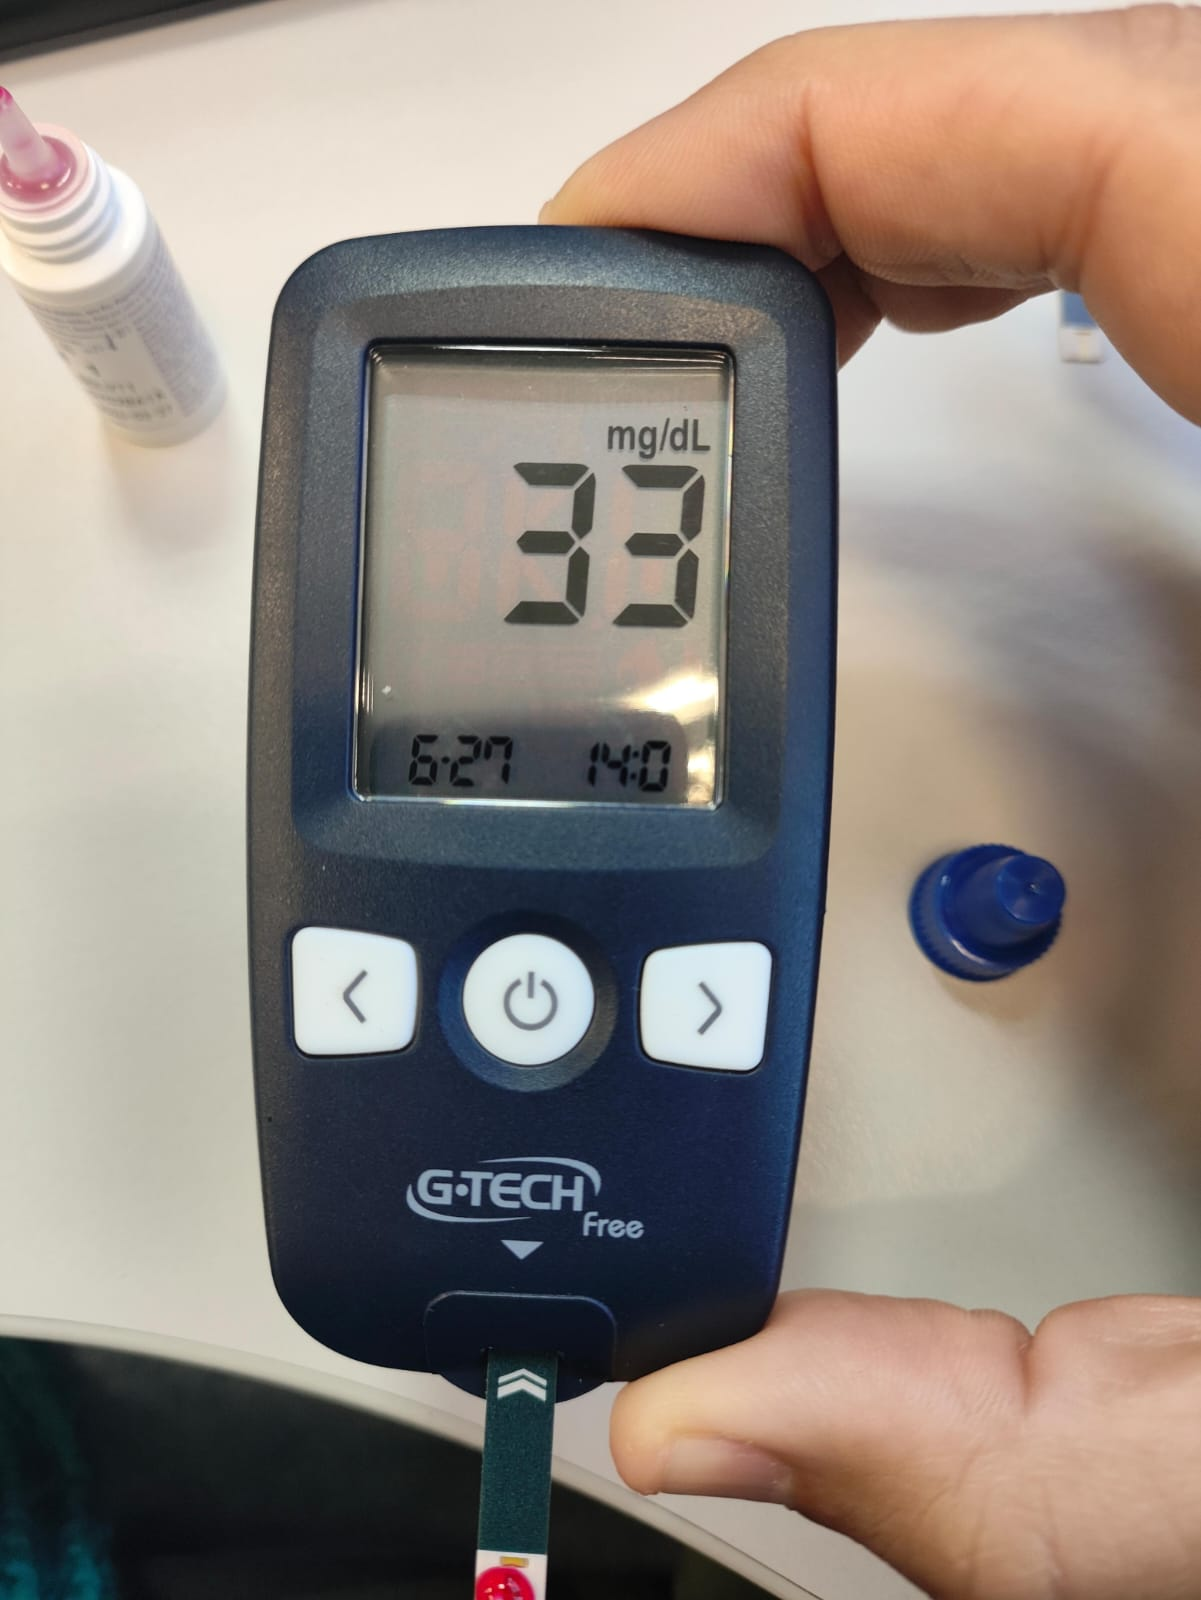

# Criação da coluna target

In [26]:
# Create a new column 'target' based on the 'tia' column with specified categories

def categorize_tia(tia_value):
    if tia_value < 70:
        return 'Hipoglicemia'
    elif 70 <= tia_value <= 99:
        return 'Normal'
    elif 100 <= tia_value <= 125:
        return 'Pré-diabetes'
    elif 126 <= tia_value <= 199:
        return 'Diabetes'
    elif tia_value >= 200:
        return 'Muito Alto'
    else:
        return None # Handle potential NaN or other unexpected values

df_all_unificado['target'] = df_all_unificado['tia'].apply(categorize_tia)

# Display the first few rows with the new 'target' column
print("DataFrame with 'target' column:")
display(df_all_unificado.head())

# Display the value counts for the new 'target' column
print("\nValue counts for the 'target' column:")
display(df_all_unificado['target'].value_counts())

DataFrame with 'target' column:


time_ms  time_reaction_ms  tia  filter       file_datetime  \
0        4                 0    8       5 2025-07-03 09:20:27   
1       12                 0    8       6 2025-07-03 09:20:27   
2       20                 0    8      10 2025-07-03 09:20:27   
3       28                 0    8       4 2025-07-03 09:20:27   
4       36                 0    6       7 2025-07-03 09:20:27   

                timestamp   folder                         file_name   origem  \
0 2025-07-03 09:20:27.004  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
1 2025-07-03 09:20:27.012  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
2 2025-07-03 09:20:27.020  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
3 2025-07-03 09:20:27.028  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
4 2025-07-03 09:20:27.036  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   

   peak_detector        date        target  
0            0.0  2025-07-03  Hipoglicemia  
1            0.0  2025-07-03  Hipoglicemia  
2            0.0  2025-07-03  Hipoglicemia  
3            0.0  2025-07-03  Hipoglicemia  
4            0.0  2025-07-03  Hipoglicemia


Value counts for the 'target' column:


target
Muito Alto      390533
Hipoglicemia    184662
Diabetes        109544
Normal           87392
Pré-diabetes     50951
Name: count, dtype: int64

# 20- Transformando a coluna target em valores inteiros

In [27]:
# Define the mapping from string categories to integer values
target_mapping = {
    'Normal': 1,
    'Pré-diabetes': 2,
    'Diabetes': 3,
    'Hipoglicemia': 4,
    'Muito Alto': 5
}

# Apply the mapping to the 'target' column
df_all_unificado['target'] = df_all_unificado['target'].map(target_mapping)

# Display the data type of the 'target' column to confirm the change
print("Tipo de dados da coluna 'target' após a transformação:")
print(df_all_unificado['target'].dtype)

# Display the first few rows with the transformed 'target' column
print("\nDataFrame with transformed 'target' column:")
display(df_all_unificado.head())

# Display the value counts for the transformed 'target' column
print("\nValue counts for the transformed 'target' column:")
display(df_all_unificado['target'].value_counts())

Tipo de dados da coluna 'target' após a transformação:
int64

DataFrame with transformed 'target' column:


time_ms  time_reaction_ms  tia  filter       file_datetime  \
0        4                 0    8       5 2025-07-03 09:20:27   
1       12                 0    8       6 2025-07-03 09:20:27   
2       20                 0    8      10 2025-07-03 09:20:27   
3       28                 0    8       4 2025-07-03 09:20:27   
4       36                 0    6       7 2025-07-03 09:20:27   

                timestamp   folder                         file_name   origem  \
0 2025-07-03 09:20:27.004  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
1 2025-07-03 09:20:27.012  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
2 2025-07-03 09:20:27.020  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
3 2025-07-03 09:20:27.028  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   
4 2025-07-03 09:20:27.036  Nivel 3  serial_log_25-07-03-09-20-27.csv  Nivel 3   

   peak_detector        date  target  
0            0.0  2025-07-03       4  
1            0.0  2025-07-03       4  
2            0.0  2025-07-03       4  
3            0.0  2025-07-03       4  
4            0.0  2025-07-03       4


Value counts for the transformed 'target' column:


target
5    390533
4    184662
3    109544
1     87392
2     50951
Name: count, dtype: int64

# 21- Transformando a coluna origem em valores inteiros

In [28]:
# Define the mapping from string categories to integer values for the 'origem' column
origem_mapping = {
    'Solução 0': 0,
    'Solução 1': 1,
    'Solução 2': 2,
    'Nivel1': 3,
    'Nivel 3': 4
}

# Apply the mapping to the 'origem' column
df_all_unificado['origem'] = df_all_unificado['origem'].map(origem_mapping)

# Display the data type of the 'origem' column to confirm the change
print("Tipo de dados da coluna 'origem' após a transformação:")
print(df_all_unificado['origem'].dtype)

# Display the first few rows with the transformed 'origem' column
print("\nDataFrame with transformed 'origem' column:")
display(df_all_unificado.head())

# Display the value counts for the transformed 'origem' column
print("\nValue counts for the transformed 'origem' column:")
display(df_all_unificado['origem'].value_counts())

Tipo de dados da coluna 'origem' após a transformação:
int64

DataFrame with transformed 'origem' column:


time_ms  time_reaction_ms  tia  filter       file_datetime  \
0        4                 0    8       5 2025-07-03 09:20:27   
1       12                 0    8       6 2025-07-03 09:20:27   
2       20                 0    8      10 2025-07-03 09:20:27   
3       28                 0    8       4 2025-07-03 09:20:27   
4       36                 0    6       7 2025-07-03 09:20:27   

                timestamp   folder                         file_name  origem  \
0 2025-07-03 09:20:27.004  Nivel 3  serial_log_25-07-03-09-20-27.csv       4   
1 2025-07-03 09:20:27.012  Nivel 3  serial_log_25-07-03-09-20-27.csv       4   
2 2025-07-03 09:20:27.020  Nivel 3  serial_log_25-07-03-09-20-27.csv       4   
3 2025-07-03 09:20:27.028  Nivel 3  serial_log_25-07-03-09-20-27.csv       4   
4 2025-07-03 09:20:27.036  Nivel 3  serial_log_25-07-03-09-20-27.csv       4   

   peak_detector        date  target  
0            0.0  2025-07-03       4  
1            0.0  2025-07-03       4  
2            0.0  2025-07-03       4  
3            0.0  2025-07-03       4  
4            0.0  2025-07-03       4


Value counts for the transformed 'origem' column:


origem
4    220956
3    191792
0    139433
2    137479
1    133422
Name: count, dtype: int64

# 22- Tratando outliers da coluna 'tia' e os substituindo pela mediana

In [29]:
# Calculate the median of the 'tia' column
median_tia = df_all_unificado['tia'].median()

# Calculate Q1, Q3, and IQR for the 'tia' column to identify outliers
Q1_tia = df_all_unificado['tia'].quantile(0.25)
Q3_tia = df_all_unificado['tia'].quantile(0.75)
IQR_tia = Q3_tia - Q1_tia

lower_bound_tia = Q1_tia - 1.5 * IQR_tia
upper_bound_tia = Q3_tia + 1.5 * IQR_tia

# Identify outliers in the 'tia' column
outliers_tia = df_all_unificado[(df_all_unificado['tia'] < lower_bound_tia) | (df_all_unificado['tia'] > upper_bound_tia)]

# Replace outliers with the median
df_all_unificado.loc[outliers_tia.index, 'tia'] = median_tia

print("Outliers na coluna 'tia' substituídos pela mediana.")

# Verify the change by displaying the statistical summary of the 'tia' column
print("\nDados estatísticos para a coluna 'tia' após a substituição de outliers:")
display(df_all_unificado[['tia']].describe())

# Optionally, you can check the number of outliers again to confirm they are gone (or replaced)
Q1_tia_new = df_all_unificado['tia'].quantile(0.25)
Q3_tia_new = df_all_unificado['tia'].quantile(0.75)
IQR_tia_new = Q3_tia_new - Q1_tia_new

lower_bound_tia_new = Q1_tia_new - 1.5 * IQR_tia_new
upper_bound_tia_new = Q3_tia_new + 1.5 * IQR_tia_new

outliers_tia_new = df_all_unificado[(df_all_unificado['tia'] < lower_bound_tia_new) | (df_all_unificado['tia'] > upper_bound_tia_new)]

print(f"\nNúmero de outliers na coluna 'tia' após a substituição: {len(outliers_tia_new)}")

Outliers na coluna 'tia' substituídos pela mediana.

Dados estatísticos para a coluna 'tia' após a substituição de outliers:


tia
count  823082.000000
mean      186.203201
std       176.837948
min         0.000000
25%        74.000000
50%       186.000000
75%       213.000000
max      1041.000000


Número de outliers na coluna 'tia' após a substituição: 66178


# 22.1 Ordenar

In [30]:
# Se a coluna 'timestamp' não for do tipo datetime, converta-a primeiro
df_all_unificado['timestamp'] = pd.to_datetime(df_all_unificado['timestamp'])

# Ordena o DataFrame inteiro pela coluna de timestamp
print("Ordenando o DataFrame por timestamp...")
df_all_unificado.sort_values(by='timestamp', inplace=True)

# Reseta o índice para que ele siga a nova ordem cronológica
df_all_unificado.reset_index(drop=True, inplace=True)

print("DataFrame principal agora está em ordem cronológica.")

Ordenando o DataFrame por timestamp...
DataFrame principal agora está em ordem cronológica.


# 22.2 Criar Features de janelas deslizantes

In [31]:
print("Iniciando a criação das features de janela deslizante...")

# Define os tamanhos das janelas que vamos usar
window_sizes = [5, 10, 30]
feature_column = 'tia' # Coluna alvo para criar as features

for window in window_sizes:
    # Calcula a média móvel
    df_all_unificado[f'{feature_column}_mean_w{window}'] = df_all_unificado[feature_column].rolling(window=window).mean()

    # Calcula o desvio padrão móvel
    df_all_unificado[f'{feature_column}_std_w{window}'] = df_all_unificado[feature_column].rolling(window=window).std()

# Preenche os valores nulos (NaN) criados no início do DataFrame
df_all_unificado.fillna(method='bfill', inplace=True)

print("Features de janela deslizante criadas com sucesso!")
print("Novas colunas adicionadas:", [f'{feature_column}_mean_w{w}' for w in window_sizes] + [f'{feature_column}_std_w{w}' for w in window_sizes])

Iniciando a criação das features de janela deslizante...
Features de janela deslizante criadas com sucesso!
Novas colunas adicionadas: ['tia_mean_w5', 'tia_mean_w10', 'tia_mean_w30', 'tia_std_w5', 'tia_std_w10', 'tia_std_w30']


/tmp/ipython-input-91282858.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all_unificado.fillna(method='bfill', inplace=True)


# 22.3 Criando as features de lag defasagem

In [32]:
print("Iniciando a criação das features de lag...")

# Define os lags (defasagens)
lags = [1, 2, 3]
feature_column = 'tia' # Coluna alvo para criar os lags

# Loop para criar cada feature de lag
for lag in lags:
    df_all_unificado[f'{feature_column}_lag_{lag}'] = df_all_unificado[feature_column].shift(lag)

# A operação de lag também cria valores nulos (NaN) no início do DataFrame.
# usar o 'backfill' para preenchê-los.
df_all_unificado.fillna(method='bfill', inplace=True)

print("Features de lag criadas com sucesso!")

# Exibe os nomes das novas colunas de lag que foram adicionadas
print("\nNovas colunas de lag adicionadas:", [f'{feature_column}_lag_{l}' for l in lags])

# Visualizar o resultado para entender o que foi feito
print("\nVisualização do DataFrame com as features de lag:")
print(df_all_unificado[['tia'] + [f'{feature_column}_lag_{l}' for l in lags]].head(10))

Iniciando a criação das features de lag...


/tmp/ipython-input-628311910.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all_unificado.fillna(method='bfill', inplace=True)


Features de lag criadas com sucesso!

Novas colunas de lag adicionadas: ['tia_lag_1', 'tia_lag_2', 'tia_lag_3']

Visualização do DataFrame com as features de lag:
   tia  tia_lag_1  tia_lag_2  tia_lag_3
0    3        3.0        3.0        3.0
1    3        3.0        3.0        3.0
2    2        3.0        3.0        3.0
3   13        2.0        3.0        3.0
4    0       13.0        2.0        3.0
5    1        0.0       13.0        2.0
6    3        1.0        0.0       13.0
7    1        3.0        1.0        0.0
8    0        1.0        3.0        1.0
9    2        0.0        1.0        3.0


# 23- Salvando o dataset tratado e o carregando

In [33]:
# Save the DataFrame to a new CSV file
df_all_unificado.to_csv("/content/df_all_tratado_unificado.csv", index=False)
print("DataFrame salvo como '/content/df_all_tratado_unificado.csv'")

# Load the new CSV file into a DataFrame
df_all_tratado_unificado = pd.read_csv("/content/df_all_tratado_unificado.csv")
print("\nDataFrame carregado a partir de '/content/df_all_tratado_unificado.csv'")

# Display the first 20 rows of the loaded DataFrame
print("\nPrimeiras 20 linhas do DataFrame carregado:")
display(df_all_tratado_unificado.head(20))

DataFrame salvo como '/content/df_all_tratado_unificado.csv'

DataFrame carregado a partir de '/content/df_all_tratado_unificado.csv'

Primeiras 20 linhas do DataFrame carregado:


time_ms  time_reaction_ms  tia  filter        file_datetime  \
0         4                 0    3       5  2025-07-03 08:44:50   
1        12                 0    3       9  2025-07-03 08:44:50   
2        20                 0    2       5  2025-07-03 08:44:50   
3        28                 0   13      14  2025-07-03 08:44:50   
4        36                 0    0       9  2025-07-03 08:44:50   
5        44                 0    1       9  2025-07-03 08:44:50   
6        52                 1    3       8  2025-07-03 08:44:50   
7        60                 0    1       7  2025-07-03 08:44:50   
8        68                 6    0       8  2025-07-03 08:44:50   
9        76                 0    2      14  2025-07-03 08:44:50   
10       84                 2    4       6  2025-07-03 08:44:50   
11       91                 0    7      15  2025-07-03 08:44:50   
12       95                 0    4       7  2025-07-03 08:44:50   
13       99                 0    4       6  2025-07-03 08:44:50   
14      103                 0    4       6  2025-07-03 08:44:50   
15      107                 0    2       7  2025-07-03 08:44:50   
16      111                 8    3       6  2025-07-03 08:44:50   
17      115                 1    3       6  2025-07-03 08:44:50   
18      119                 0    1       7  2025-07-03 08:44:50   
19      123                 0    2       6  2025-07-03 08:44:50   

                  timestamp  folder                         file_name  origem  \
0   2025-07-03 08:44:50.004  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
1   2025-07-03 08:44:50.012  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
2   2025-07-03 08:44:50.020  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
3   2025-07-03 08:44:50.028  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
4   2025-07-03 08:44:50.036  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
5   2025-07-03 08:44:50.044  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
6   2025-07-03 08:44:50.052  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
7   2025-07-03 08:44:50.060  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
8   2025-07-03 08:44:50.068  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
9   2025-07-03 08:44:50.076  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
10  2025-07-03 08:44:50.084  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
11  2025-07-03 08:44:50.091  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
12  2025-07-03 08:44:50.095  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
13  2025-07-03 08:44:50.099  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
14  2025-07-03 08:44:50.103  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
15  2025-07-03 08:44:50.107  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
16  2025-07-03 08:44:50.111  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
17  2025-07-03 08:44:50.115  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
18  2025-07-03 08:44:50.119  Nivel1  serial_log_25-07-03-08-44-50.csv       3   
19  2025-07-03 08:44:50.123  Nivel1  serial_log_25-07-03-08-44-50.csv       3   

    peak_detector  ... target  tia_mean_w5  tia_std_w5  tia_mean_w10  \
0             0.0  ...      4          4.2    5.069517           2.8   
1             0.0  ...      4          4.2    5.069517           2.8   
2             0.0  ...      4          4.2    5.069517           2.8   
3             0.0  ...      4          4.2    5.069517           2.8   
4             0.0  ...      4          4.2    5.069517           2.8   
5             0.0  ...      4          3.8    5.263079           2.8   
6             0.0  ...      4          3.8    5.263079           2.8   
7             0.0  ...      4          3.6    5.366563           2.8   
8             0.0  ...      4          1.0    1.224745           2.8   
9             0.0  ...      4          1.4    1.140175           2.8   
10            0.0  ...      4          2.0    1.581139           2.9   
11            0.0  ...      4 

# 24- Observando o dataset acima podemos ver a coluna 'folder' do tipo 'String' ou object mas esta deixamos somente para entendimento dos dados, pois faz a mesma coisa da coluna 'origem' ou seja classifica a pasta de origem dos dados e na coluna 'origem' isto ja foi feito e transformado em 'int'

# 25- Nesta etapara sera feita a separação do dataset em treino 60% teste 20% e validação 20% pois tenho uma grande quantidade de dados

In [34]:
# Separação inicial em treino (60%) e o restante (40%)
df_treino, df_restante = train_test_split(df_all_tratado_unificado, test_size=0.4, random_state=42)

# Separação do restante (40%) em teste (20%) e validação (20%)
# test_size=0.5 significa 20% do dataset original (0.5 * 40% = 20%)
df_teste, df_validacao = train_test_split(df_restante, test_size=0.5, random_state=42)

print(f"Tamanho do dataset original: {len(df_all_tratado_unificado)}")
print(f"Tamanho do conjunto de treino: {len(df_treino)} ({len(df_treino)/len(df_all_tratado_unificado):.2%})")
print(f"Tamanho do conjunto de teste: {len(df_teste)} ({len(df_teste)/len(df_all_tratado_unificado):.2%})")
print(f"Tamanho do conjunto de validação: {len(df_validacao)} ({len(df_validacao)/len(df_all_tratado_unificado):.2%})")

# Opcional: Mostrar as primeiras linhas de cada conjunto para verificação
# print("\nPrimeiras linhas do conjunto de treino:")
# display(df_treino.head())

# print("\nPrimeiras linhas do conjunto de teste:")
# display(df_teste.head())

# print("\nPrimeiras linhas do conjunto de validação:")
# display(df_validacao.head())

Tamanho do dataset original: 823082
Tamanho do conjunto de treino: 493849 (60.00%)
Tamanho do conjunto de teste: 164616 (20.00%)
Tamanho do conjunto de validação: 164617 (20.00%)


# 25.1- Visualização dos dados

In [35]:
df_all_tratado_unificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823082 entries, 0 to 823081
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time_ms           823082 non-null  int64  
 1   time_reaction_ms  823082 non-null  int64  
 2   tia               823082 non-null  int64  
 3   filter            823082 non-null  int64  
 4   file_datetime     823082 non-null  object 
 5   timestamp         823082 non-null  object 
 6   folder            823082 non-null  object 
 7   file_name         823082 non-null  object 
 8   origem            823082 non-null  int64  
 9   peak_detector     823082 non-null  float64
 10  date              823082 non-null  object 
 11  target            823082 non-null  int64  
 12  tia_mean_w5       823082 non-null  float64
 13  tia_std_w5        823082 non-null  float64
 14  tia_mean_w10      823082 non-null  float64
 15  tia_std_w10       823082 non-null  float64
 16  tia_mean_w30      82

# 26- Padronização dos dados de treino e aplicação da mesma regra nos conjuntos de teste e validação

In [36]:
from sklearn.preprocessing import StandardScaler

# Colunas a serem padronizadas
cols_to_scale = [
    'time_reaction_ms', 'filter', 'peak_detector', 'tia',
    'tia_mean_w5', 'tia_std_w5', 'tia_mean_w10', 'tia_std_w10',
    'tia_mean_w30', 'tia_std_w30', 'tia_lag_1', 'tia_lag_2', 'tia_lag_3'
]

scaler = StandardScaler()
scaler.fit(df_treino[cols_to_scale])

# Cria as cópias escaladas
df_treino_scaled = df_treino.copy()
df_validacao_scaled = df_validacao.copy()
df_teste_scaled = df_teste.copy()

# Aplica a transformação
df_treino_scaled[cols_to_scale] = scaler.transform(df_treino[cols_to_scale])
df_validacao_scaled[cols_to_scale] = scaler.transform(df_validacao[cols_to_scale])
df_teste_scaled[cols_to_scale] = scaler.transform(df_teste[cols_to_scale])

print("Padronização aplicada corretamente.")

Padronização aplicada corretamente.


#  27- Início do treino com o modelo de regressão linear simples.

Métricas de Avaliação:
  Treino - MSE: 0.01, R²: 0.99
  Validação - MSE: 0.01, R²: 0.99


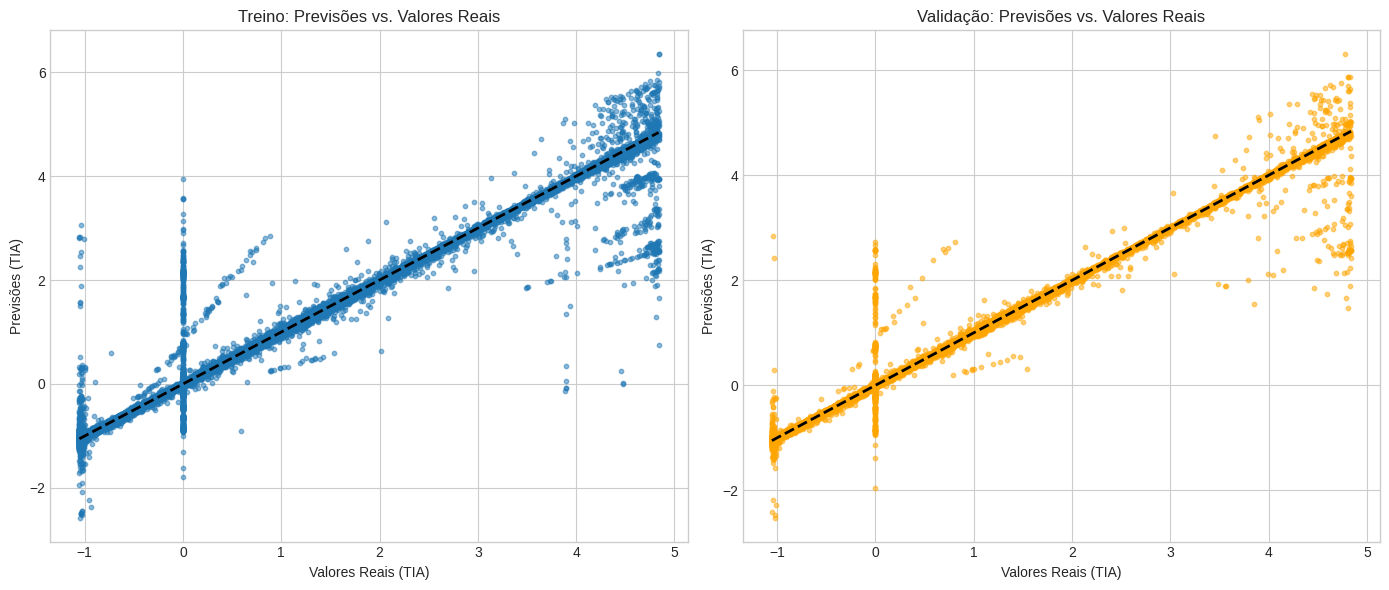

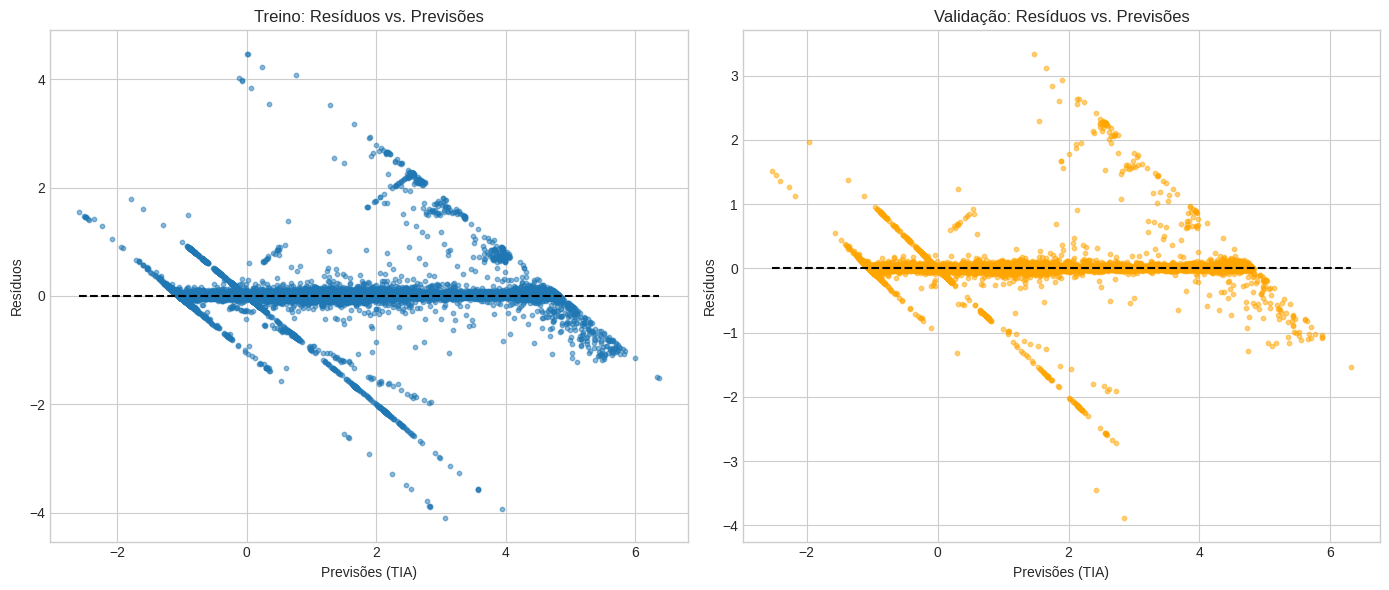

In [37]:
# Definir as features (X) e o target (y)
# Incluindo TODAS as novas features que criamos
features = [
    'time_reaction_ms',
    'filter',
    'peak_detector',
    'origem',
    'tia_mean_w5',      # Nova feature
    'tia_std_w5',       # Nova feature
    'tia_mean_w10',     # Nova feature
    'tia_std_w10',      # Nova feature
    'tia_mean_w30',     # Nova feature
    'tia_std_w30',      # Nova feature
    'tia_lag_1',        # Nova feature
    'tia_lag_2',        # Nova feature
    'tia_lag_3'         # Nova feature
]
target = 'tia'

X_treino = df_treino_scaled[features]
y_treino = df_treino_scaled[target]

X_teste = df_teste_scaled[features]
y_teste = df_teste_scaled[target]

X_validacao = df_validacao_scaled[features]
y_validacao = df_validacao_scaled[target]

# Inicializar e treinar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_treino, y_treino)

# Fazer previsões nos conjuntos de treino e validação
y_pred_treino = model.predict(X_treino)
y_pred_validacao = model.predict(X_validacao)

# Avaliar o modelo
mse_treino = mean_squared_error(y_treino, y_pred_treino)
r2_treino = r2_score(y_treino, y_pred_treino)

mse_validacao = mean_squared_error(y_validacao, y_pred_validacao)
r2_validacao = r2_score(y_validacao, y_pred_validacao)

print("Métricas de Avaliação:")
print(f"  Treino - MSE: {mse_treino:.2f}, R²: {r2_treino:.2f}")
print(f"  Validação - MSE: {mse_validacao:.2f}, R²: {r2_validacao:.2f}")

# Gráficos de dispersão das previsões vs. valores reais
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_treino, y_pred_treino, alpha=0.5, s=10)
plt.title('Treino: Previsões vs. Valores Reais')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_treino.min(), y_treino.max()], [y_treino.min(), y_treino.max()], 'k--', lw=2)

plt.subplot(1, 2, 2)
plt.scatter(y_validacao, y_pred_validacao, alpha=0.5, s=10, color='orange')
plt.title('Validação: Previsões vs. Valores Reais')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_validacao.min(), y_validacao.max()], [y_validacao.min(), y_validacao.max()], 'k--', lw=2)

plt.tight_layout()
plt.show()

# Gráfico de Resíduos
plt.figure(figsize=(14, 6))

residuos_treino = y_treino - y_pred_treino
residuos_validacao = y_validacao - y_pred_validacao

plt.subplot(1, 2, 1)
plt.scatter(y_pred_treino, residuos_treino, alpha=0.5, s=10)
plt.title('Treino: Resíduos vs. Previsões')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_treino.min(), y_pred_treino.max(), colors='k', linestyles='dashed')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_validacao, residuos_validacao, alpha=0.5, s=10, color='orange')
plt.title('Validação: Resíduos vs. Previsões')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_validacao.min(), y_pred_validacao.max(), colors='k', linestyles='dashed')

plt.tight_layout()
plt.show()

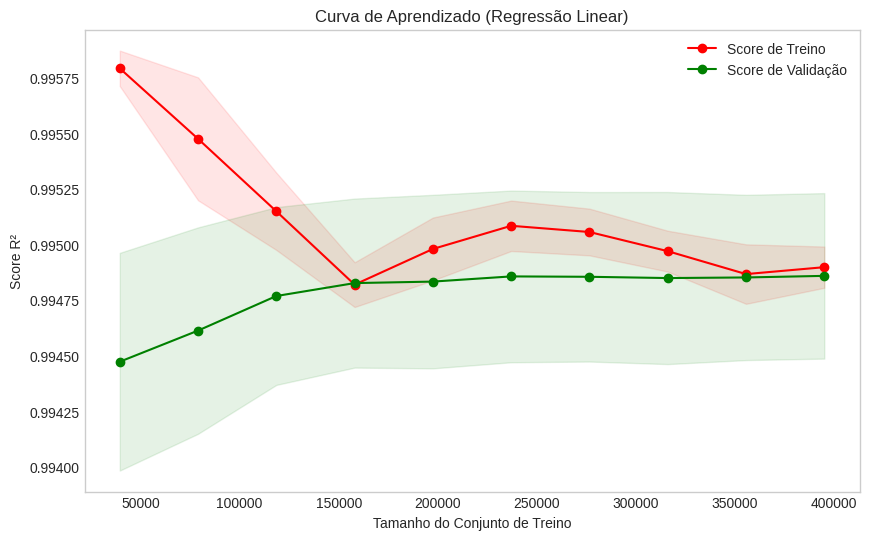

# 28- Teste com o modelo RandomForestRegressor mais robusto

In [38]:
# Initialize and train the Random Forest Regressor model
# Using default parameters for a start
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_treino, y_treino)

# Make predictions on the training and validation sets
y_pred_treino_rf = rf_model.predict(X_treino)
y_pred_validacao_rf = rf_model.predict(X_validacao)

# Evaluate the model
mse_treino_rf = mean_squared_error(y_treino, y_pred_treino_rf)
r2_treino_rf = r2_score(y_treino, y_pred_treino_rf)

mse_validacao_rf = mean_squared_error(y_validacao, y_pred_validacao_rf)
r2_validacao_rf = r2_score(y_validacao, y_pred_validacao_rf)

print("Métricas de Avaliação (Random Forest Regressor):")
print(f"  Treino - MSE: {mse_treino_rf:.2f}, R²: {r2_treino_rf:.2f}")
print(f"  Validação - MSE: {mse_validacao_rf:.2f}, R²: {r2_validacao_rf:.2f}")

# You can also visualize the results similar to the linear regression model if desired.
# For example, scatter plots of predictions vs actual values, and residual plots.
# Due to the potentially large number of data points, visualizing a subset might be more practical.




Métricas de Avaliação (Random Forest Regressor):
  Treino - MSE: 0.00, R²: 1.00
  Validação - MSE: 0.00, R²: 1.00



### Avaliação do Modelo Random Forest Regressor

Abaixo estão as métricas de avaliação para o modelo Random Forest Regressor nos conjuntos de treino e validação.

Para uma análise visual, podemos gerar gráficos de dispersão das previsões vs. valores reais e gráficos de resíduos, similar ao que foi feito para o modelo de Regressão Linear. No entanto, devido ao grande volume de dados, a visualização de um subconjunto aleatório pode ser mais informativa.



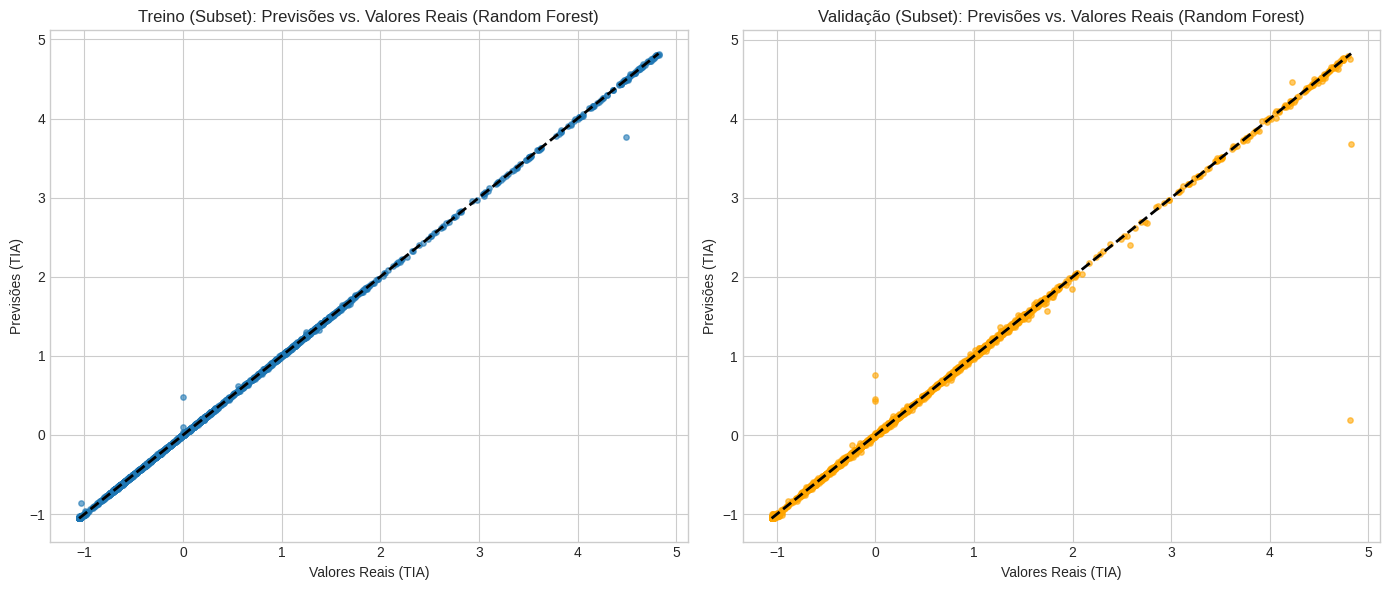

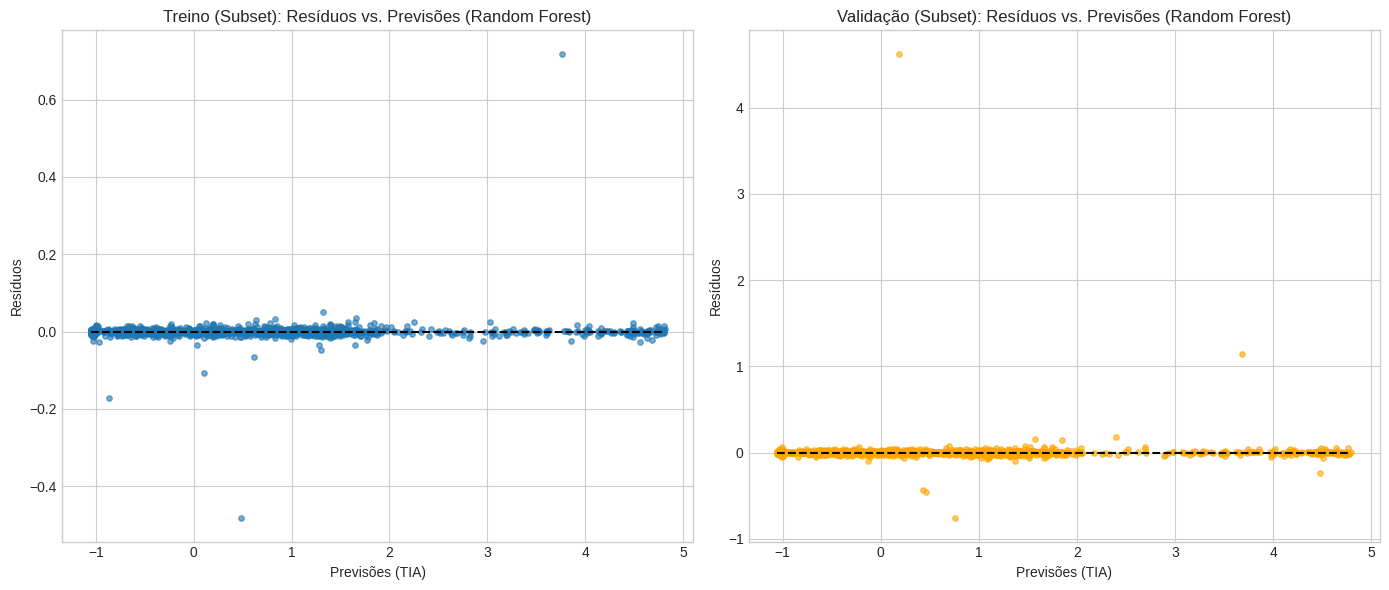

In [39]:
# Optional: Visualize a subset of the predictions vs actual values

subset_size = 5000 # Adjust as needed

# Select a random subset of indices
random_indices_treino = np.random.choice(len(y_treino), size=min(subset_size, len(y_treino)), replace=False)
random_indices_validacao = np.random.choice(len(y_validacao), size=min(subset_size, len(y_validacao)), replace=False)

y_treino_subset = y_treino.iloc[random_indices_treino]
y_pred_treino_rf_subset = y_pred_treino_rf[random_indices_treino]

y_validacao_subset = y_validacao.iloc[random_indices_validacao]
y_pred_validacao_rf_subset = y_pred_validacao_rf[random_indices_validacao]


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_treino_subset, y_pred_treino_rf_subset, alpha=0.6, s=15)
plt.title('Treino (Subset): Previsões vs. Valores Reais (Random Forest)')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_treino_subset.min(), y_treino_subset.max()], [y_treino_subset.min(), y_treino_subset.max()], 'k--', lw=2) # Linha de referência ideal


plt.subplot(1, 2, 2)
plt.scatter(y_validacao_subset, y_pred_validacao_rf_subset, alpha=0.6, s=15, color='orange')
plt.title('Validação (Subset): Previsões vs. Valores Reais (Random Forest)')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_validacao_subset.min(), y_validacao_subset.max()], [y_validacao_subset.min(), y_validacao_subset.max()], 'k--', lw=2) # Linha de referência ideal

plt.tight_layout()
plt.show()

# Optional: Residual plots for a subset
residuos_treino_rf_subset = y_treino_subset - y_pred_treino_rf_subset
residuos_validacao_rf_subset = y_validacao_subset - y_pred_validacao_rf_subset

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_treino_rf_subset, residuos_treino_rf_subset, alpha=0.6, s=15)
plt.title('Treino (Subset): Resíduos vs. Previsões (Random Forest)')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_treino_rf_subset.min(), y_pred_treino_rf_subset.max(), colors='k', linestyles='dashed')


plt.subplot(1, 2, 2)
plt.scatter(y_pred_validacao_rf_subset, residuos_validacao_rf_subset, alpha=0.6, s=15, color='orange')
plt.title('Validação (Subset): Resíduos vs. Previsões (Random Forest)')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_validacao_rf_subset.min(), y_pred_validacao_rf_subset.max(), colors='k', linestyles='dashed')

plt.tight_layout()
plt.show()


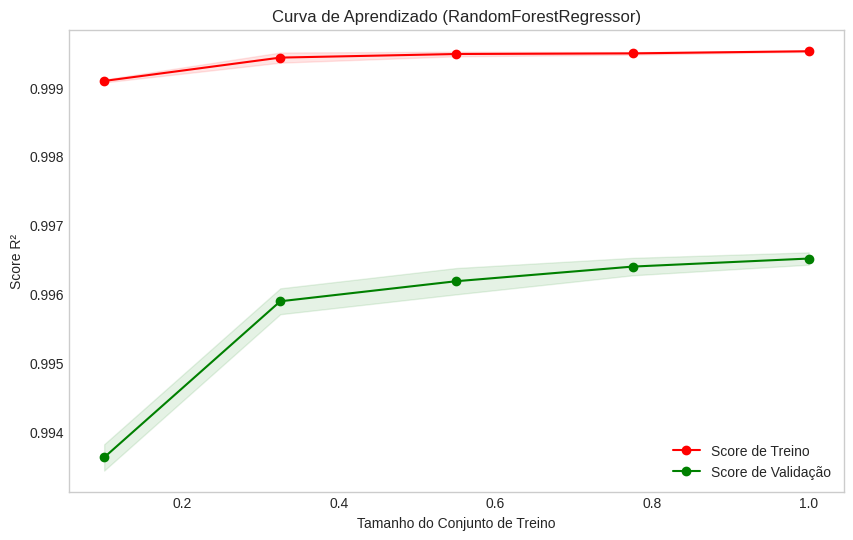

# 29- Treino com o modelo XGBRegressor com ajustes de hiperparâmetros para teste

In [40]:
# Initialize and train the XGBoost Regressor model
# Added some common hyperparameters for tuning
xgb_model = XGBRegressor(
    objective='reg:squarederror', # Objective for regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Maximum depth of a tree
    subsample=0.8,                # Fraction of samples used for fitting the individual base learners
    colsample_bytree=0.8,         # Fraction of features used for fitting the individual base learners
    random_state=42,
    n_jobs=-1                     # Use all available cores
)

xgb_model.fit(X_treino, y_treino)

# Make predictions on the training and validation sets
y_pred_treino_xgb = xgb_model.predict(X_treino)
y_pred_validacao_xgb = xgb_model.predict(X_validacao)

# Evaluate the model
mse_treino_xgb = mean_squared_error(y_treino, y_pred_treino_xgb)
r2_treino_xgb = r2_score(y_treino, y_pred_treino_xgb)

mse_validacao_xgb = mean_squared_error(y_validacao, y_pred_validacao_xgb)
r2_validacao_xgb = r2_score(y_validacao, y_pred_validacao_xgb)

print("Métricas de Avaliação (XGBoost Regressor):")
print(f"  Treino - MSE: {mse_treino_xgb:.2f}, R²: {r2_treino_xgb:.2f}")
print(f"  Validação - MSE: {mse_validacao_xgb:.2f}, R²: {r2_validacao_xgb:.2f}")

# You can also visualize the results similar to the linear regression model if desired.
# For example, scatter plots of predictions vs actual values, and residual plots.
# Due to the potentially large number of data points, visualizing a subset might be more practical.

Métricas de Avaliação (XGBoost Regressor):
  Treino - MSE: 0.00, R²: 1.00
  Validação - MSE: 0.00, R²: 1.00


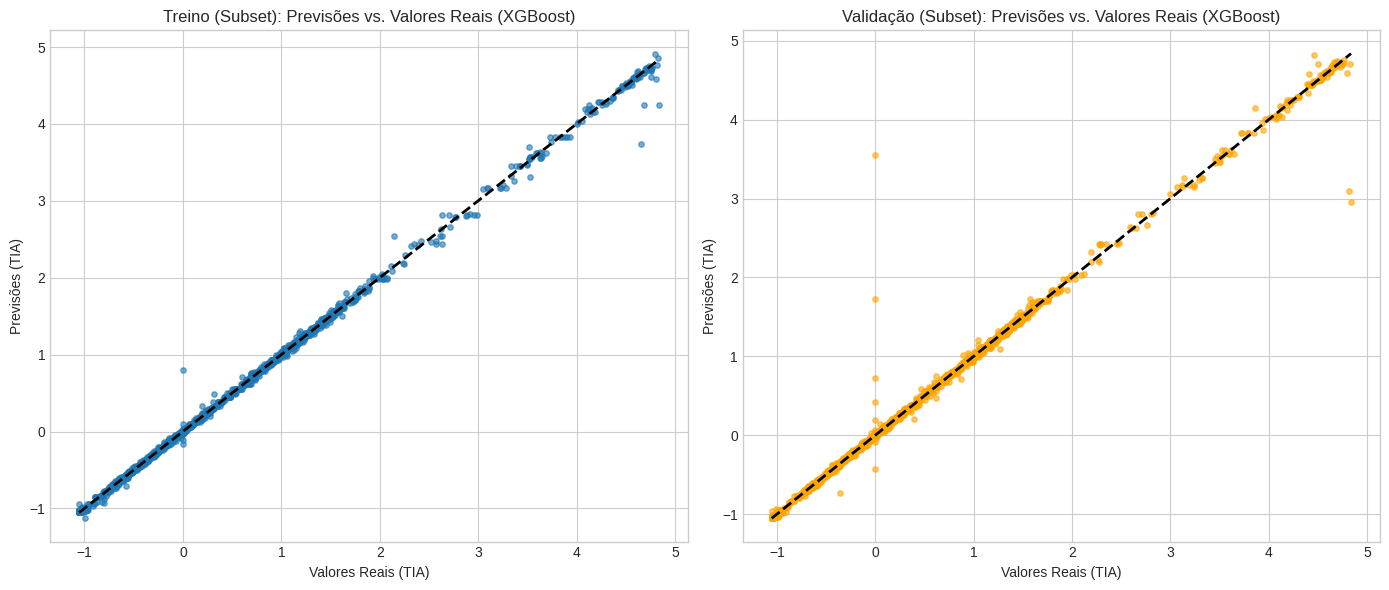

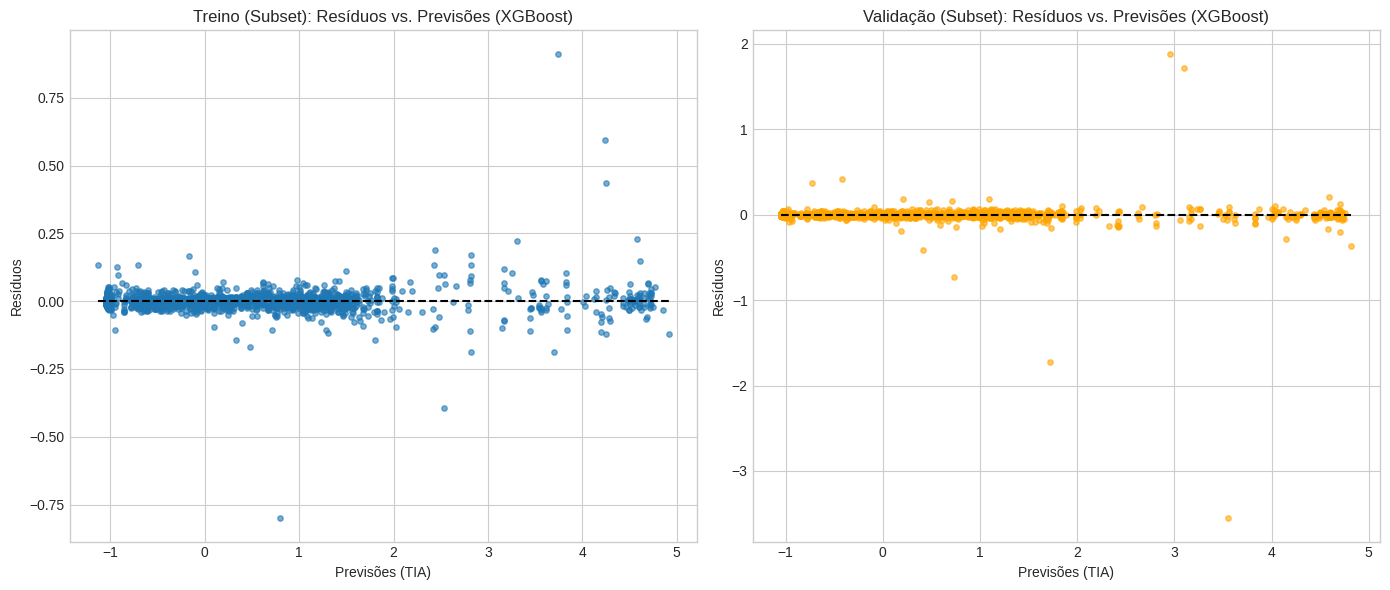

In [41]:
# Visualize a subset of the predictions vs actual values for XGBoost
subset_size = 5000 # Adjust as needed

# Select a random subset of indices
random_indices_treino = np.random.choice(len(y_treino), size=min(subset_size, len(y_treino)), replace=False)
random_indices_validacao = np.random.choice(len(y_validacao), size=min(subset_size, len(y_validacao)), replace=False)

y_treino_subset = y_treino.iloc[random_indices_treino]
y_pred_treino_xgb_subset = y_pred_treino_xgb[random_indices_treino]

y_validacao_subset = y_validacao.iloc[random_indices_validacao]
y_pred_validacao_xgb_subset = y_pred_validacao_xgb[random_indices_validacao]


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_treino_subset, y_pred_treino_xgb_subset, alpha=0.6, s=15)
plt.title('Treino (Subset): Previsões vs. Valores Reais (XGBoost)')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_treino_subset.min(), y_treino_subset.max()], [y_treino_subset.min(), y_treino_subset.max()], 'k--', lw=2) # Linha de referência ideal


plt.subplot(1, 2, 2)
plt.scatter(y_validacao_subset, y_pred_validacao_xgb_subset, alpha=0.6, s=15, color='orange')
plt.title('Validação (Subset): Previsões vs. Valores Reais (XGBoost)')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_validacao_subset.min(), y_validacao_subset.max()], [y_validacao_subset.min(), y_validacao_subset.max()], 'k--', lw=2) # Linha de referência ideal

plt.tight_layout()
plt.show()

# Residual plots for a subset for XGBoost
residuos_treino_xgb_subset = y_treino_subset - y_pred_treino_xgb_subset
residuos_validacao_xgb_subset = y_validacao_subset - y_pred_validacao_xgb_subset

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_treino_xgb_subset, residuos_treino_xgb_subset, alpha=0.6, s=15)
plt.title('Treino (Subset): Resíduos vs. Previsões (XGBoost)')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_treino_xgb_subset.min(), y_pred_treino_xgb_subset.max(), colors='k', linestyles='dashed')


plt.subplot(1, 2, 2)
plt.scatter(y_pred_validacao_xgb_subset, residuos_validacao_xgb_subset, alpha=0.6, s=15, color='orange')
plt.title('Validação (Subset): Resíduos vs. Previsões (XGBoost)')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_validacao_xgb_subset.min(), y_pred_validacao_xgb_subset.max(), colors='k', linestyles='dashed')

plt.tight_layout()
plt.show()

# 31- Modelo LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3065
[LightGBM] [Info] Number of data points in the train set: 493849, number of used features: 13
[LightGBM] [Info] Start training from score -0.001406
Métricas de Avaliação (LightGBM Regressor):
  Treino - MSE: 0.01, R²: 0.99
  Validação - MSE: 0.01, R²: 0.99


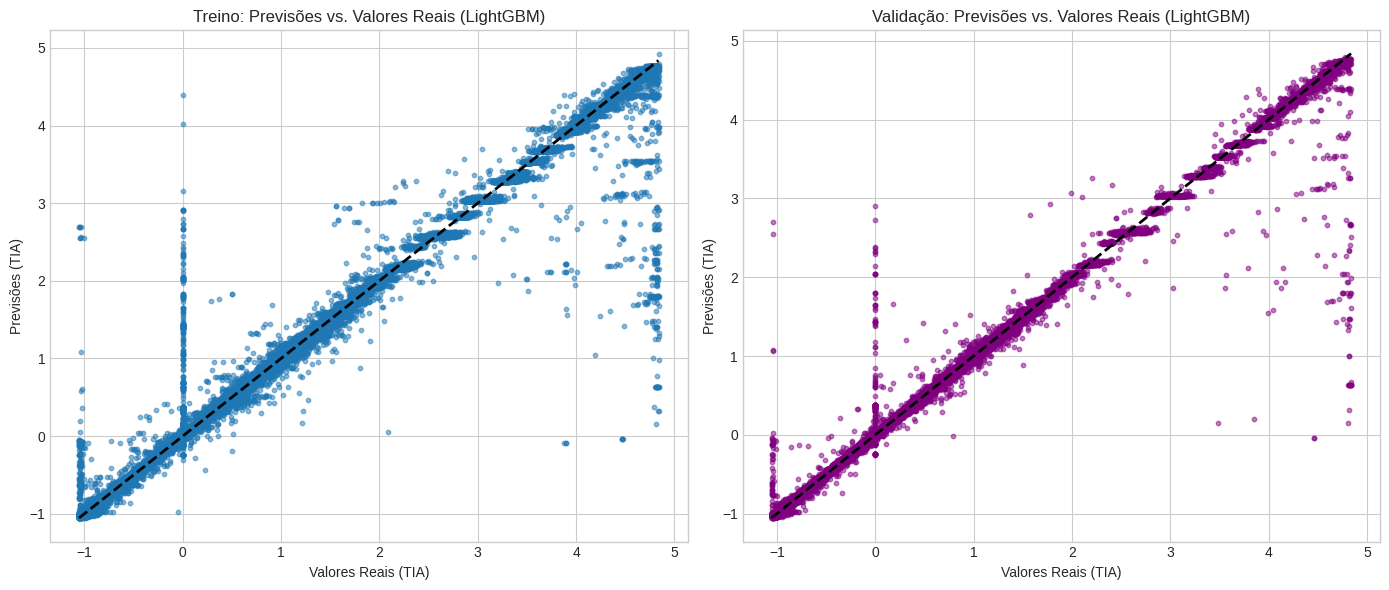

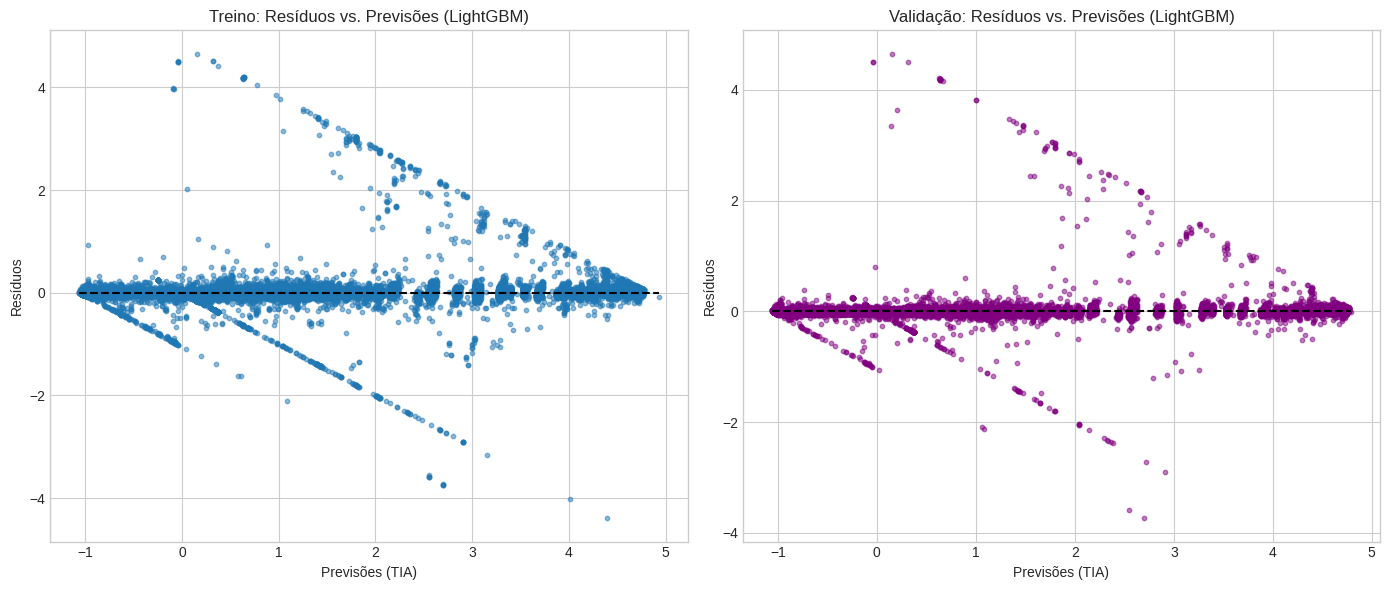

In [42]:
# Definir as features (X) e o target (y)
# Excluindo as colunas não relevantes para o treinamento
features = [
    'time_reaction_ms',
    'filter',
    'peak_detector',
    'origem',
    'tia_mean_w5',      # Nova feature
    'tia_std_w5',       # Nova feature
    'tia_mean_w10',     # Nova feature
    'tia_std_w10',      # Nova feature
    'tia_mean_w30',     # Nova feature
    'tia_std_w30',      # Nova feature
    'tia_lag_1',        # Nova feature
    'tia_lag_2',        # Nova feature
    'tia_lag_3'         # Nova feature
]
target = 'tia'

X_treino = df_treino_scaled[features]
y_treino = df_treino_scaled[target]

X_teste = df_teste_scaled[features]
y_teste = df_teste_scaled[target]

X_validacao = df_validacao_scaled[features]
y_validacao = df_validacao_scaled[target]

# Inicializar e treinar o modelo LightGBM Regressor
# Adicionados alguns hiperparâmetros comuns para ajuste
lgbm_model = LGBMRegressor(
    objective='regression_l1',  # Objective for Mean Absolute Error (MAE)
    n_estimators=200,           # Increased number of boosting rounds
    learning_rate=0.05,         # Reduced learning rate
    num_leaves=63,              # Increased number of leaves (should be < 2^max_depth)
    max_depth=-1,               # No limit on tree depth
    random_state=42,
    n_jobs=-1                   # Use all available cores
)

lgbm_model.fit(X_treino, y_treino)

# Fazer previsões nos conjuntos de treino e validação
y_pred_treino_lgbm = lgbm_model.predict(X_treino)
y_pred_validacao_lgbm = lgbm_model.predict(X_validacao)

# Avaliar o modelo
mse_treino_lgbm = mean_squared_error(y_treino, y_pred_treino_lgbm)
r2_treino_lgbm = r2_score(y_treino, y_pred_treino_lgbm)

mse_validacao_lgbm = mean_squared_error(y_validacao, y_pred_validacao_lgbm)
r2_validacao_lgbm = r2_score(y_validacao, y_pred_validacao_lgbm)

print("Métricas de Avaliação (LightGBM Regressor):")
print(f"  Treino - MSE: {mse_treino_lgbm:.2f}, R²: {r2_treino_lgbm:.2f}")
print(f"  Validação - MSE: {mse_validacao_lgbm:.2f}, R²: {r2_validacao_lgbm:.2f}")

# Gráficos de dispersão das previsões vs. valores reais para LightGBM
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_treino, y_pred_treino_lgbm, alpha=0.5, s=10)
plt.title('Treino: Previsões vs. Valores Reais (LightGBM)')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_treino.min(), y_treino.max()], [y_treino.min(), y_treino.max()], 'k--', lw=2) # Linha de referência ideal

plt.subplot(1, 2, 2)
plt.scatter(y_validacao, y_pred_validacao_lgbm, alpha=0.5, s=10, color='purple')
plt.title('Validação: Previsões vs. Valores Reais (LightGBM)')
plt.xlabel('Valores Reais (TIA)')
plt.ylabel('Previsões (TIA)')
plt.plot([y_validacao.min(), y_validacao.max()], [y_validacao.min(), y_validacao.max()], 'k--', lw=2) # Linha de referência ideal

plt.tight_layout()
plt.show()

# Gráfico de Resíduos para LightGBM
plt.figure(figsize=(14, 6))

residuos_treino_lgbm = y_treino - y_pred_treino_lgbm
residuos_validacao_lgbm = y_validacao - y_pred_validacao_lgbm

plt.subplot(1, 2, 1)
plt.scatter(y_pred_treino_lgbm, residuos_treino_lgbm, alpha=0.5, s=10)
plt.title('Treino: Resíduos vs. Previsões (LightGBM)')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_treino_lgbm.min(), y_pred_treino_lgbm.max(), colors='k', linestyles='dashed')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_validacao_lgbm, residuos_validacao_lgbm, alpha=0.5, s=10, color='purple')
plt.title('Validação: Resíduos vs. Previsões (LightGBM)')
plt.xlabel('Previsões (TIA)')
plt.ylabel('Resíduos')
plt.hlines(0, y_pred_validacao_lgbm.min(), y_pred_validacao_lgbm.max(), colors='k', linestyles='dashed')

plt.tight_layout()
plt.show()

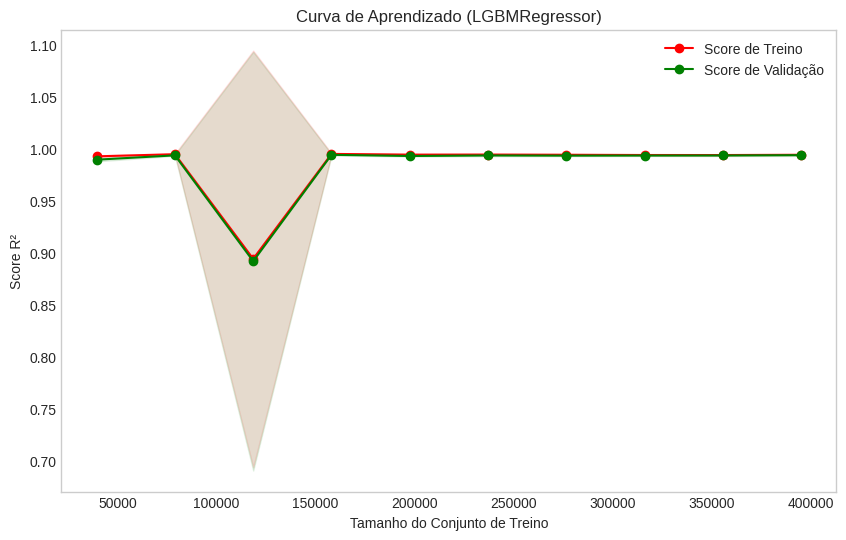

# 32- Métricas de avaliação dos modelos

Relatório de Desempenho dos Modelos de Regressão:


Modelo   Conjunto       MSE        R²
0  Regressão Linear Simples     Treino  0.005106  0.994894
1  Regressão Linear Simples  Validação  0.005159  0.994844
2   Random Forest Regressor     Treino  0.000415  0.999585
3   Random Forest Regressor  Validação  0.002637  0.997365
4         XGBoost Regressor     Treino  0.001185  0.998815
5         XGBoost Regressor  Validação  0.002685  0.997317
6        LightGBM Regressor     Treino  0.005458  0.994542
7        LightGBM Regressor  Validação  0.006264  0.993740

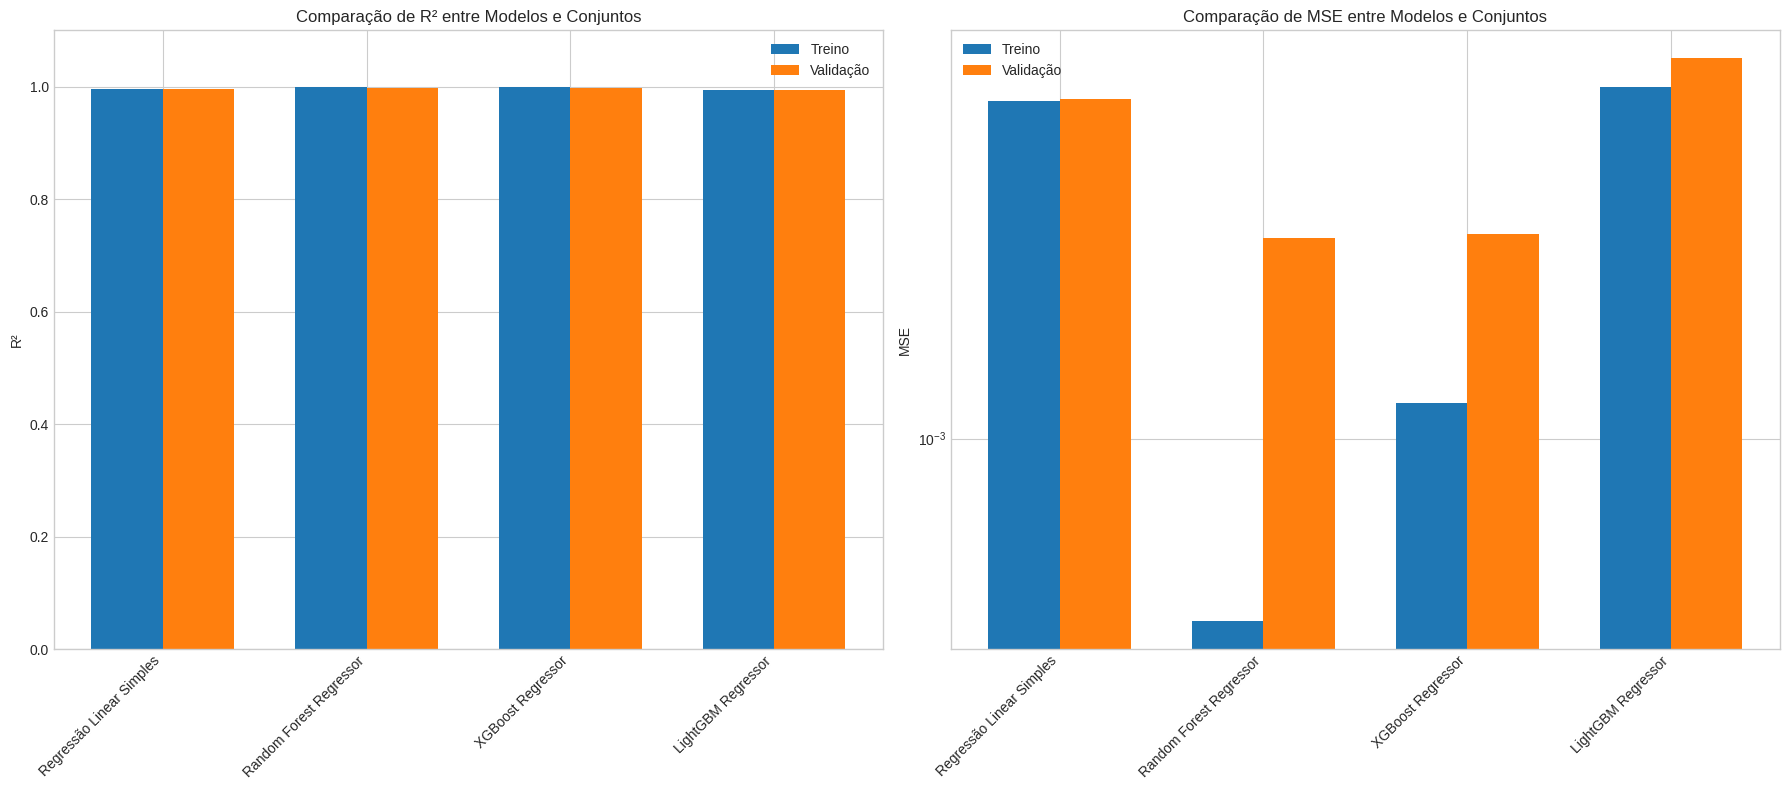

In [43]:
# Criar um DataFrame para resumir as métricas
metrics_data = {
    'Modelo': ['Regressão Linear Simples', 'Regressão Linear Simples',
               'Random Forest Regressor', 'Random Forest Regressor',
               'XGBoost Regressor', 'XGBoost Regressor',
               'LightGBM Regressor', 'LightGBM Regressor'],
    'Conjunto': ['Treino', 'Validação', 'Treino', 'Validação',
                 'Treino', 'Validação', 'Treino', 'Validação'],
    'MSE': [mse_treino, mse_validacao, mse_treino_rf, mse_validacao_rf,
            mse_treino_xgb, mse_validacao_xgb, mse_treino_lgbm, mse_validacao_lgbm],
    'R²': [r2_treino, r2_validacao, r2_treino_rf, r2_validacao_rf,
           r2_treino_xgb, r2_validacao_xgb, r2_treino_lgbm, r2_validacao_lgbm]
}

df_metrics = pd.DataFrame(metrics_data)

print("Relatório de Desempenho dos Modelos de Regressão:")
display(df_metrics)

# Gerar gráficos de barras para R² e MSE
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico de Barras para R²
bar_width = 0.35
models = df_metrics['Modelo'].unique()
x = np.arange(len(models))

treino_r2 = df_metrics[df_metrics['Conjunto'] == 'Treino']['R²']
validacao_r2 = df_metrics[df_metrics['Conjunto'] == 'Validação']['R²']

rects1 = axes[0].bar(x - bar_width/2, treino_r2, bar_width, label='Treino')
rects2 = axes[0].bar(x + bar_width/2, validacao_r2, bar_width, label='Validação')

axes[0].set_ylabel('R²')
axes[0].set_title('Comparação de R² entre Modelos e Conjuntos')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha="right")
axes[0].legend()
axes[0].set_ylim(0, 1.1) # R² is typically between 0 and 1

# Gráfico de Barras para MSE
treino_mse = df_metrics[df_metrics['Conjunto'] == 'Treino']['MSE']
validacao_mse = df_metrics[df_metrics['Conjunto'] == 'Validação']['MSE']

rects3 = axes[1].bar(x - bar_width/2, treino_mse, bar_width, label='Treino')
rects4 = axes[1].bar(x + bar_width/2, validacao_mse, bar_width, label='Validação')

axes[1].set_ylabel('MSE')
axes[1].set_title('Comparação de MSE entre Modelos e Conjuntos')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha="right")
axes[1].legend()
axes[1].set_yscale('log') # Use log scale for MSE due to large differences

plt.tight_layout()
plt.show()

# 33- Agora vamos fazer a validação final do modelo utilizando dados dos sensores obtidos no laboratório nos ultimos dias, somente lembrando que estes dados são brutos e terão que ter um tratamento prévio para o modelo fazer as previsões.

In [44]:
print("Selecione o arquivo .zip (ex.: Dados de teste do desafio 2.zip)")
uploaded = files.upload()


# Descobre o primeiro arquivo .zip enviado
a = [n for n in uploaded.keys() if n.lower().endswith('.zip')]
assert len(a) > 0, "Envie um arquivo .zip com seus dados."
zip_name = a[0]


# Extrai o zip na pasta /content
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as z:
    z.extractall('/content')


# Tenta localizar a pasta principal dos dados
candidates = [p for p in glob.glob('/content/*')
if os.path.isdir(p) and os.path.basename(p).lower().startswith('Dados de teste do desafio 2')]
base_path = candidates[0] if candidates else '/content/Dados de teste do desafio 2'
print('base_path =', base_path)

Selecione o arquivo .zip (ex.: Dados de teste do desafio 2.zip)


Saving Dados de teste do desafio 2.zip to Dados de teste do desafio 2.zip
base_path = /content/Dados de teste do desafio 2


# 34- Visão geral dos arquivos

In [45]:
data_exts = ('.csv', '.txt')

def list_data_files(root):
    files = []
    for dpath, dnames, fnames in os.walk(root):
        for fn in fnames:
            if fn.lower().endswith(data_exts):
                files.append(os.path.join(dpath, fn))
    return sorted(files)

all_files = list_data_files(base_path)
print(f"Arquivos de dados encontrados: {len(all_files)}")

from collections import Counter
by_folder = Counter(os.path.basename(os.path.dirname(p)) for p in all_files)
for folder, count in by_folder.items():
    print(f"- {folder}: {count} arquivos")

# Mostra alguns exemplos de caminhos
for p in all_files[:5]:
    print("ex:", p)



Arquivos de dados encontrados: 5
- Dados de teste do desafio 2: 5 arquivos
ex: /content/Dados de teste do desafio 2/serial_log_25-09-09-10-18-46.csv
ex: /content/Dados de teste do desafio 2/serial_log_25-09-09-10-22-19.csv
ex: /content/Dados de teste do desafio 2/serial_log_25-09-09-10-26-10.csv
ex: /content/Dados de teste do desafio 2/serial_log_25-09-09-11-13-26.csv
ex: /content/Dados de teste do desafio 2/serial_log_25-09-09-11-15-06.csv


# 35- Funções auxiliares para leitura de CSV/TXT conversão de valores hexadecimais para inteiros. Extração de file_datetime a partir do nome do arquivo. Função clean_one_file() que padroniza cada dataset. Criação de colunas de metadados: file_datetime, timestamp, folder, file_name e origem. Remoção da coluna reaction_timestamp.

In [46]:
# ---------------------------
# PARTE 3 — Funções utilitárias
# ---------------------------

# ---------------------------
# (1) Remove arquivos de documentação da lista
# ---------------------------
try:
    all_files = [p for p in all_files if 'colunas' not in os.path.basename(p).lower()]
    print("Arquivos após filtrar 'colunas':", len(all_files))
except NameError:
    print("Variável all_files não encontrada — rode a Parte 2 primeiro para gerar a lista de arquivos.")

# ---------------------------
# Configurações de nomes
# ---------------------------
# Mapeia nomes padronizados das colunas (caso arquivos tenham cabeçalho)
RENAME_MAP = {
    'Time (ms)': 'time_ms',
    'Time since reaction (ms)': 'time_reaction_ms',
    'TIA (adc)': 'tia',
    'Filter (adc)': 'filter',
    'Peak Detector (adc)': 'peak_detector',
}
EXPECTED = list(RENAME_MAP.values())

# ---------------------------
# 2) Leitura tolerante a diferentes separadores e encodings
# ---------------------------
def read_any_table(path):
    """Tenta ler o arquivo com detecção automática de separador, com fallback para alguns encodings and explicit delimiters."""
    # Try with sniff from pandas (python engine)
    for enc in ('utf-8', 'latin1'):
        try:
            return pd.read_csv(path, engine='python', sep=None, encoding=enc)
        except Exception:
            pass
    # Explicitly try common delimiters
    for sep in [',', ';', '\t', '|', ' ']: # Added space as a potential delimiter
        for enc in ('utf-8', 'latin1'):
            try:
                return pd.read_csv(path, sep=sep, encoding=enc)
            except Exception:
                pass
    # Manual attempt with whitespace delimiter as a last resort
    try:
        return pd.read_csv(path, delim_whitespace=True)
    except Exception:
        pass

    raise RuntimeError(f"Não foi possível ler: {path}")

# ---------------------------
# 3) Conversão hexadecimal -> inteiro
# ---------------------------
def hex_to_int_series(s: pd.Series) -> pd.Series:
    def conv(x):
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x == '':
            return np.nan
        x = x.replace('"', '').replace("'", "")
        try:
            if x.lower().startswith('0x'):
                return int(x, 16)
            if re.fullmatch(r'[-+]?\d+', x):
                return int(x)
            if re.fullmatch(r'[-+]?\d*\.\d+', x):
                return int(float(x))
            return pd.to_numeric(x, errors='coerce')
        except Exception:
            return pd.to_numeric(x, errors='coerce')
    out = s.apply(conv)
    try:
        return out.astype('Int64')
    except Exception:
        return out

# ---------------------------
# 4) Extrai data/hora do nome do arquivo
# ---------------------------
def parse_file_datetime(file_name: str) -> pd.Timestamp:
    m = re.search(r'(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})', file_name)
    if not m:
        return pd.NaT
    yy, mm, dd, hh, mi, ss = map(int, m.groups())
    year = 2000 + yy
    try:
        return pd.Timestamp(year=year, month=mm, day=dd, hour=hh, minute=mi, second=ss)
    except Exception:
        return pd.NaT

# ---------------------------
# 5) Limpeza completa de UM arquivo (robusto para arquivos sem cabeçalho)
# ---------------------------
def clean_one_file(file_path: str) -> pd.DataFrame:
    """
    Lê e normaliza um arquivo:
    - lê CSV/TXT robustamente, mesmo que sem separador claro
    - renomeia colunas
    - converte hex -> int nas colunas esperadas
    - extrai file_datetime do nome do arquivo
    - cria timestamp = file_datetime + time_ms (em ms)
    - adiciona metadados: folder, file_name
    - remove reaction_timestamp that has no data
    """
    basename = os.path.basename(file_path).lower()
    if 'colunas' in basename:
        raise ValueError("Arquivo de documentação — pulando")

    # --------- Leitura robusta ---------
    try:
        df = read_any_table(file_path)
    except Exception as e:
        raise RuntimeError(f"Erro ao ler o arquivo {file_path}: {e}")

    # Limpa nomes de colunas
    df.columns = [str(c).strip() for c in df.columns]

    # Renomeia colunas existentes
    df = df.rename(columns=RENAME_MAP)

    # Para arquivos sem cabeçalho, define nomes padrão das primeiras 4 colunas
    if set(EXPECTED).isdisjoint(df.columns):
         # This part assumes the order is consistent if there's no header
         # Adjust if the file structure is different
         new_columns = EXPECTED[:df.shape[1]]
         df.columns = new_columns

    # Converte colunas hex -> int
    for col in EXPECTED:
        if col in df.columns:
            df[col] = hex_to_int_series(df[col])

    # Extrai datetime do nome do arquivo
    fdt = parse_file_datetime(os.path.basename(file_path))
    df['file_datetime'] = fdt

    # Constrói timestamps reais
    if 'time_ms' in df.columns:
        # Ensure time_ms is numeric before conversion
        df['time_ms'] = pd.to_numeric(df['time_ms'], errors='coerce')
        df['timestamp'] = df['file_datetime'] + pd.to_timedelta(df['time_ms'], unit='ms')
    else:
        df['timestamp'] = pd.NaT

    # Metadados
    df['folder'] = os.path.basename(os.path.dirname(file_path))
    df['file_name'] = os.path.basename(file_path)
    df['origem'] = df['folder']

    # Remove coluna inútil
    df = df.drop(columns=['reaction_timestamp'], errors='ignore')

    # Ordena por timestamp se existir
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        df = df.sort_values('timestamp').reset_index(drop=True)

    return df

Arquivos após filtrar 'colunas': 5


# 36- Verificação dos dados dos arquivos para teste e validação

In [47]:
if 'all_files' in globals() and len(all_files) > 0:
    exemplo = all_files[0]
    print("Testando em:", exemplo)
    df_ex = clean_one_file(exemplo)
    display(df_ex.head())
else:
    print("Nenhum arquivo exemplo disponível em all_files.")

Testando em: /content/Dados de teste do desafio 2/serial_log_25-09-09-10-18-46.csv


time_ms  time_reaction_ms  tia  filter  peak_detector       file_datetime  \
0        9                 0    1       0             12 2025-09-09 10:18:46   
1       23                 0    1       3             12 2025-09-09 10:18:46   
2       32                 0    1       2             12 2025-09-09 10:18:46   
3       41                 0    1       1             11 2025-09-09 10:18:46   
4       50                 0    1       2             12 2025-09-09 10:18:46   

                timestamp                       folder  \
0 2025-09-09 10:18:46.009  Dados de teste do desafio 2   
1 2025-09-09 10:18:46.023  Dados de teste do desafio 2   
2 2025-09-09 10:18:46.032  Dados de teste do desafio 2   
3 2025-09-09 10:18:46.041  Dados de teste do desafio 2   
4 2025-09-09 10:18:46.050  Dados de teste do desafio 2   

                          file_name                       origem  
0  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
1  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
2  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
3  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
4  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2

# 37- Unificar dados em um único dataset de teste

In [48]:
# ---------------------------
# Process and unify all test files
# ---------------------------

import tqdm  # for progress bar

df_test_list = []
test_errors = []

for f in tqdm.tqdm(all_files, desc="Processing test files"):
    try:
        df_clean_test = clean_one_file(f)
        df_test_list.append(df_clean_test)
    except Exception as e:
        test_errors.append((f, str(e)))

# Concatenate all DataFrames
if df_test_list:
    df_all_test = pd.concat(df_test_list, ignore_index=True)
    print(f"All test files processed! Total rows: {len(df_all_test)}")
else:
    df_all_test = pd.DataFrame()
    print("No test files processed successfully.")

# Display the first few rows
display(df_all_test.head())

# Save the final CSV
df_all_test.to_csv("/content/df_all_test_unificado.csv", index=False)
print("Unified test CSV saved to: /content/df_all_test_unificado.csv")

# Show files with errors (if any)
if test_errors:
    print("\nTest files with errors:")
    for f, msg in test_errors:
        print(f"{f} -> {msg}")

Processing test files: 100%|██████████| 5/5 [00:00<00:00, 17.82it/s]

All test files processed! Total rows: 37526


time_ms  time_reaction_ms  tia  filter  peak_detector       file_datetime  \
0        9                 0    1       0             12 2025-09-09 10:18:46   
1       23                 0    1       3             12 2025-09-09 10:18:46   
2       32                 0    1       2             12 2025-09-09 10:18:46   
3       41                 0    1       1             11 2025-09-09 10:18:46   
4       50                 0    1       2             12 2025-09-09 10:18:46   

                timestamp                       folder  \
0 2025-09-09 10:18:46.009  Dados de teste do desafio 2   
1 2025-09-09 10:18:46.023  Dados de teste do desafio 2   
2 2025-09-09 10:18:46.032  Dados de teste do desafio 2   
3 2025-09-09 10:18:46.041  Dados de teste do desafio 2   
4 2025-09-09 10:18:46.050  Dados de teste do desafio 2   

                          file_name                       origem  
0  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
1  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
2  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
3  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2  
4  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2

Unified test CSV saved to: /content/df_all_test_unificado.csv


# 38- Verificando valores **zerados**

In [49]:
# Carrega o CSV unificado
df_all_test = pd.read_csv('/content/df_all_test_unificado.csv')

# Converte file_datetime e timestamp para datetime
df_all_test['file_datetime'] = pd.to_datetime(df_all_test['file_datetime'], errors='coerce')
df_all_test['timestamp'] = pd.to_datetime(df_all_test['timestamp'], errors='coerce')

# Agora mostramos valores nulos e zeros
print("Valores nulos por coluna:")
print(df_all_test.isna().sum())

print("\nValores zero por coluna:")
for col in df_all_test.select_dtypes(include=np.number).columns:
    zeros = (df_all_test[col] == 0).sum()
    if zeros > 0:
        print(f"{col}: {zeros} zeros")


Valores nulos por coluna:
time_ms             0
time_reaction_ms    0
tia                 0
filter              0
peak_detector       0
file_datetime       0
timestamp           0
folder              0
file_name           0
origem              0
dtype: int64

Valores zero por coluna:
time_reaction_ms: 7576 zeros
tia: 565 zeros
filter: 290 zeros


# 39- Optamos em não deletar as colunas com valores = zero pois são dados válidos. Porém a coluna peak_detector iremos substituir os valores NaN por zero ou seja não houve leitura nestes casos.

In [50]:
# Substituir valores NaN na coluna 'peak_detector' por 0
df_all_test['peak_detector'] = df_all_test['peak_detector'].fillna(0)

print("Valores NaN na coluna 'peak_detector' substituídos por 0.")

# Verificar a mudança mostrando a contagem de valores nulos novamente
print("\nValores nulos por coluna após a substituição em 'peak_detector':")
print(df_all_test.isna().sum())

Valores NaN na coluna 'peak_detector' substituídos por 0.

Valores nulos por coluna após a substituição em 'peak_detector':
time_ms             0
time_reaction_ms    0
tia                 0
filter              0
peak_detector       0
file_datetime       0
timestamp           0
folder              0
file_name           0
origem              0
dtype: int64


# 40- Dimensões do dataset de teste

In [51]:
print("Tamanho do dataset unificado (linhas, colunas):")
print(df_all_test.shape)

Tamanho do dataset unificado (linhas, colunas):
(37526, 10)


# 41- Analise de séries temporais

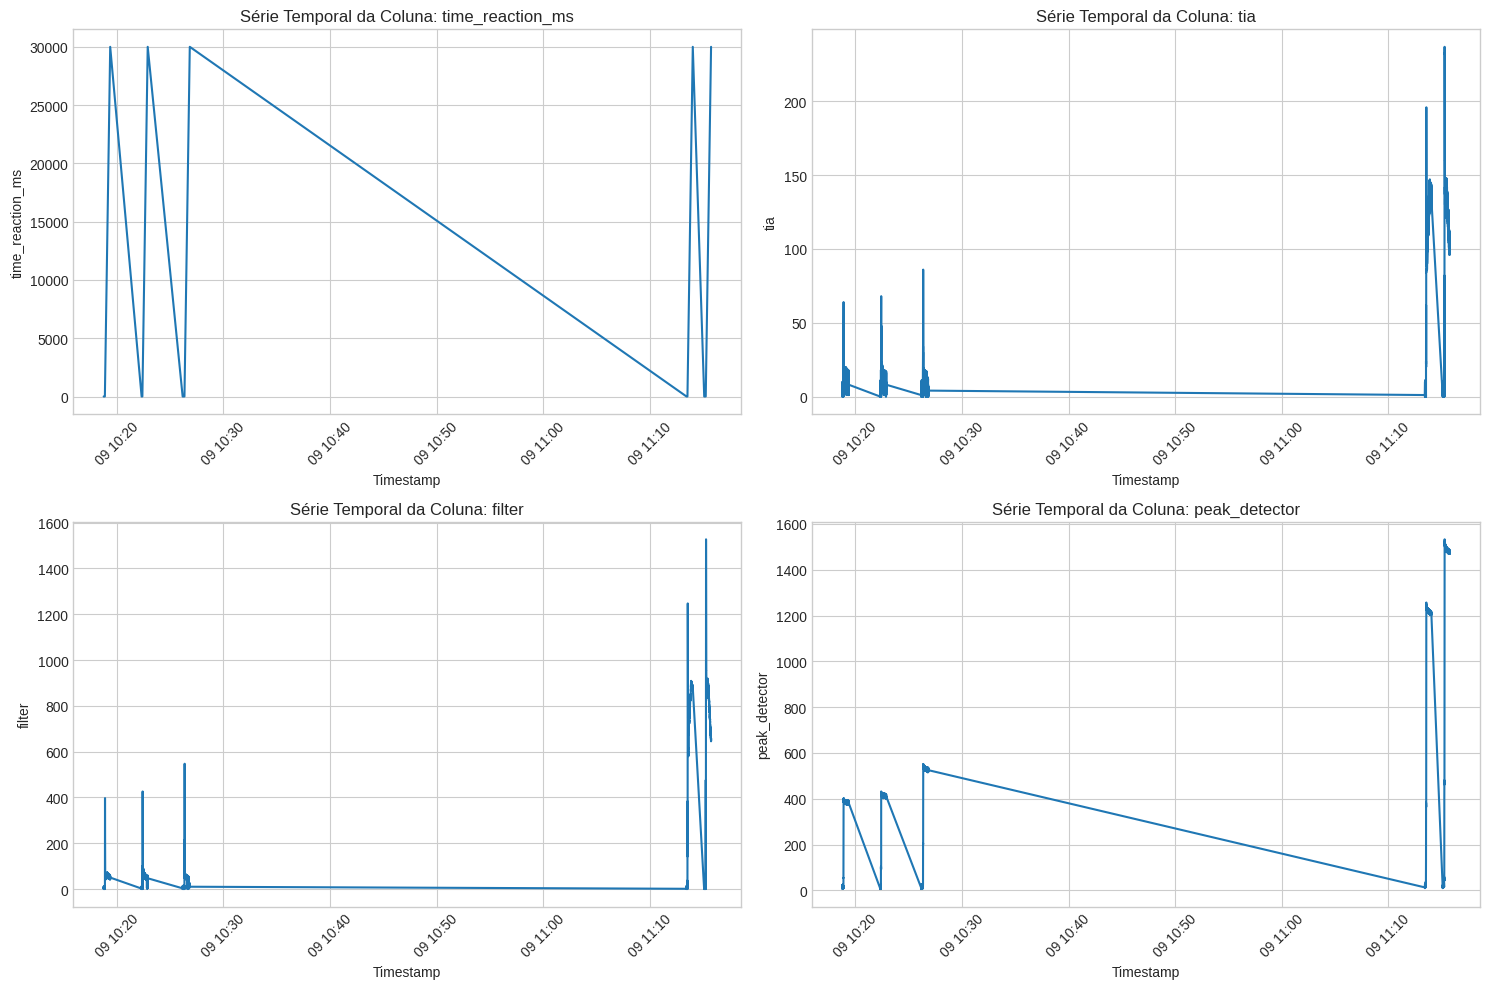

In [52]:
# Selecionar colunas numéricas para plotagem, excluindo 'time_ms' pois 'timestamp' é mais informativo
numeric_cols = df_all_test.select_dtypes(include=np.number).columns.tolist()
cols_to_plot = [col for col in numeric_cols if col not in ['time_ms']]

# Definir o número de colunas por linha para os subplots
n_cols = 2
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Achatar para facilitar a iteração

for i, col in enumerate(cols_to_plot):
    if col in df_all_test.columns:
        # Plotar usando timestamp no eixo x
        axes[i].plot(df_all_test['timestamp'], df_all_test[col])
        axes[i].set_title(f'Série Temporal da Coluna: {col}')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    else:
        # Oculta o subplot se não houver coluna para plotar
        fig.delaxes(axes[i])


# Ocultar subplots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

# 42- Verificação de outliers na base de dados de teste

Análise de Outliers (Regra do Quartil):

Coluna: time_ms
  Q1: 9452.00
  Q3: 28222.00
  IQR: 18770.00
  Limite Inferior (1.5*IQR): -18703.00
  Limite Superior (1.5*IQR): 56377.00
  Número de Outliers: 0
  Porcentagem de Outliers: 0.00%

Coluna: time_reaction_ms
  Q1: 1858.00
  Q3: 20618.00
  IQR: 18760.00
  Limite Inferior (1.5*IQR): -26282.00
  Limite Superior (1.5*IQR): 48758.00
  Número de Outliers: 0
  Porcentagem de Outliers: 0.00%

Coluna: tia
  Q1: 4.00
  Q3: 112.00
  IQR: 108.00
  Limite Inferior (1.5*IQR): -158.00
  Limite Superior (1.5*IQR): 274.00
  Número de Outliers: 0
  Porcentagem de Outliers: 0.00%

Coluna: filter
  Q1: 18.00
  Q3: 725.00
  IQR: 707.00
  Limite Inferior (1.5*IQR): -1042.50
  Limite Superior (1.5*IQR): 1785.50
  Número de Outliers: 0
  Porcentagem de Outliers: 0.00%

Coluna: peak_detector
  Q1: 381.00
  Q3: 1213.00
  IQR: 832.00
  Limite Inferior (1.5*IQR): -867.00
  Limite Superior (1.5*IQR): 2461.00
  Número de Outliers: 0
  Porcentagem de Outliers: 0.

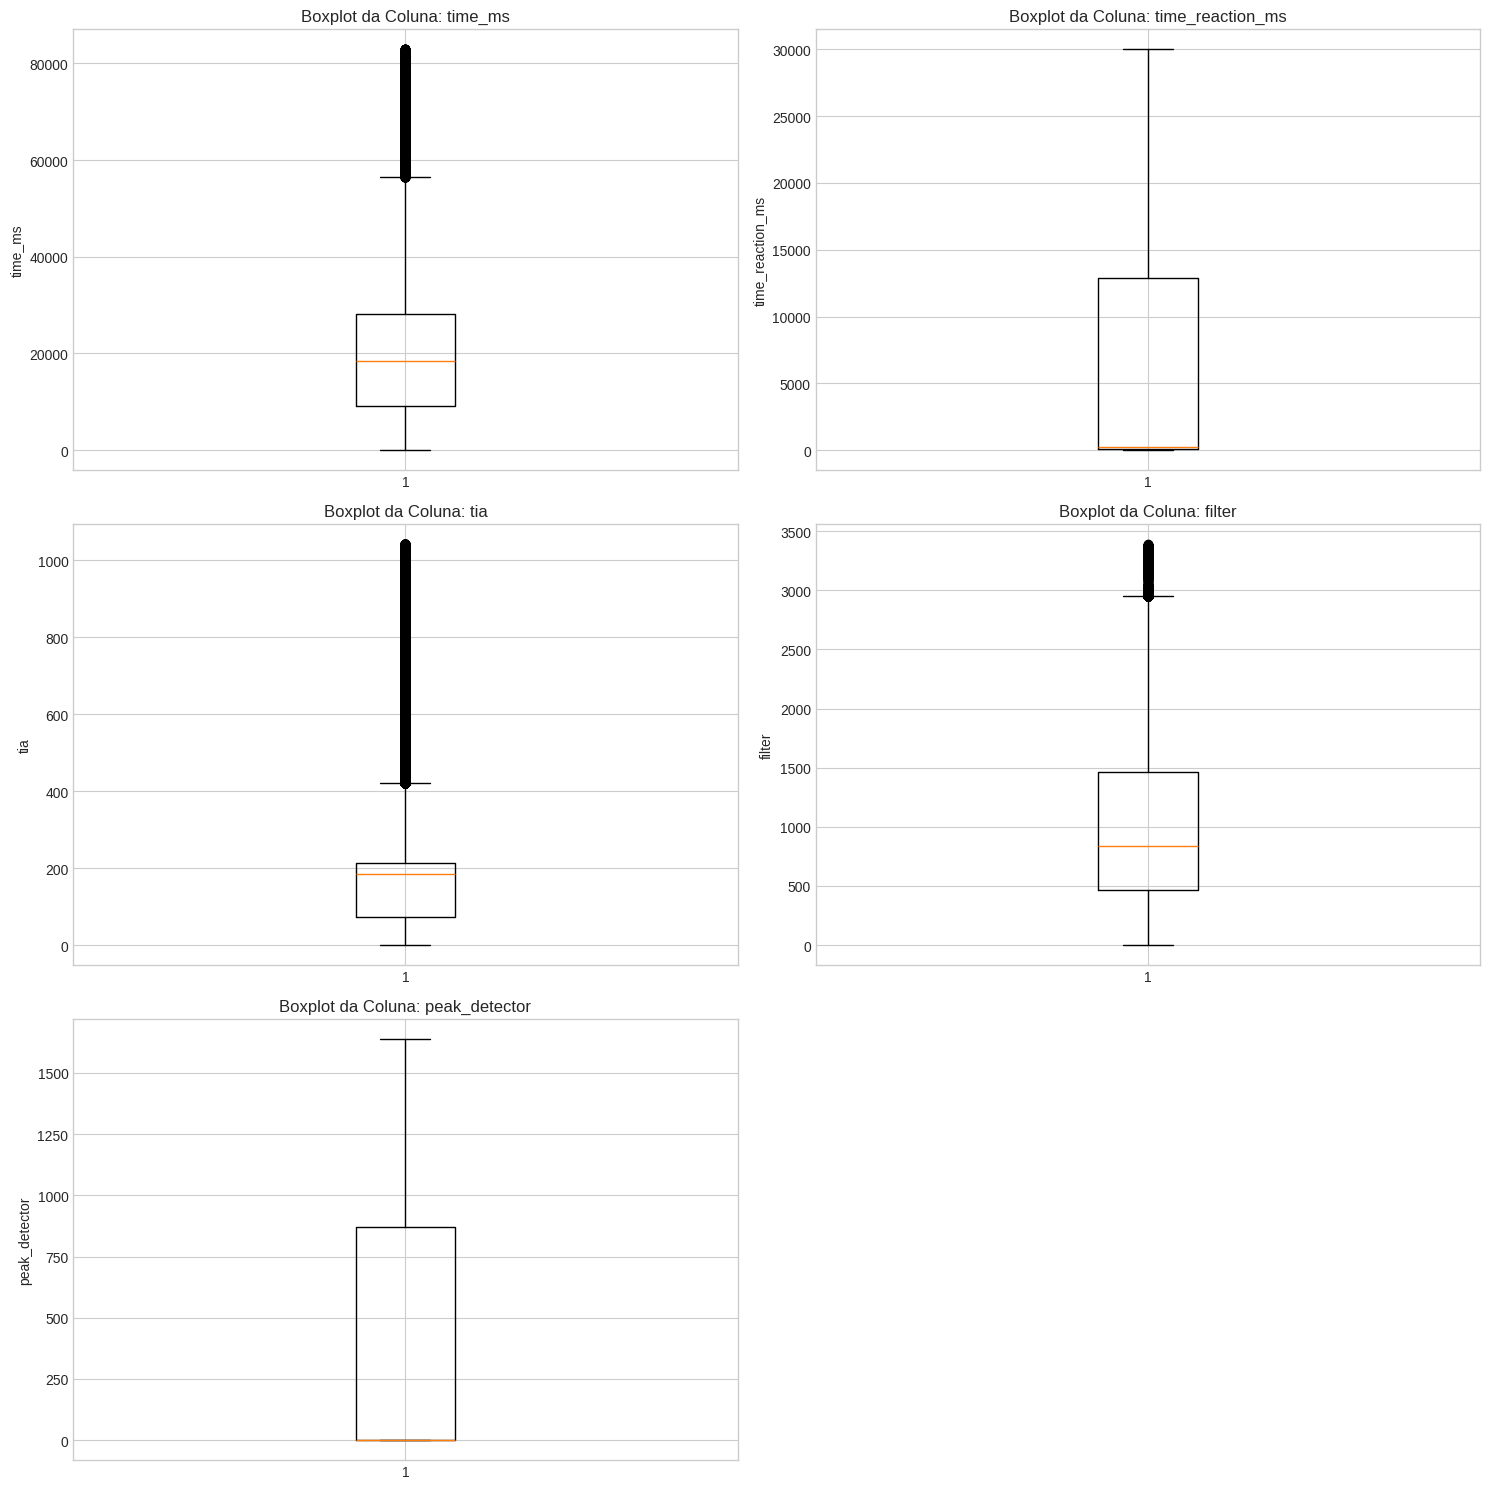

In [53]:
# Verificar a existência de outliers usando a regra do quartil e plotar boxplots

# Selecionar colunas numéricas para análise de outliers
numeric_cols = df_all_test.select_dtypes(include=np.number).columns.tolist()

print("Análise de Outliers (Regra do Quartil):")

outliers_info = {}

for col in numeric_cols:
    Q1 = df_all_test[col].quantile(0.25)
    Q3 = df_all_test[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_all_test[(df_all_test[col] < lower_bound) | (df_all_test[col] > upper_bound)]

    outliers_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': len(outliers),
        'Percentage of Outliers': (len(outliers) / len(df_all_test)) * 100
    }

    print(f"\nColuna: {col}")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Limite Inferior (1.5*IQR): {lower_bound:.2f}")
    print(f"  Limite Superior (1.5*IQR): {upper_bound:.2f}")
    print(f"  Número de Outliers: {outliers_info[col]['Number of Outliers']}")
    print(f"  Porcentagem de Outliers: {outliers_info[col]['Percentage of Outliers']:.2f}%")


# Gerar boxplots para todas as colunas numéricas
print("\nGerando Boxplots:")

n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df_all_unificado[col].dropna()) # Usar dropna para lidar com NaNs no boxplot
    axes[i].set_title(f'Boxplot da Coluna: {col}')
    axes[i].set_ylabel(col)


# Ocultar subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 43- Histogramas

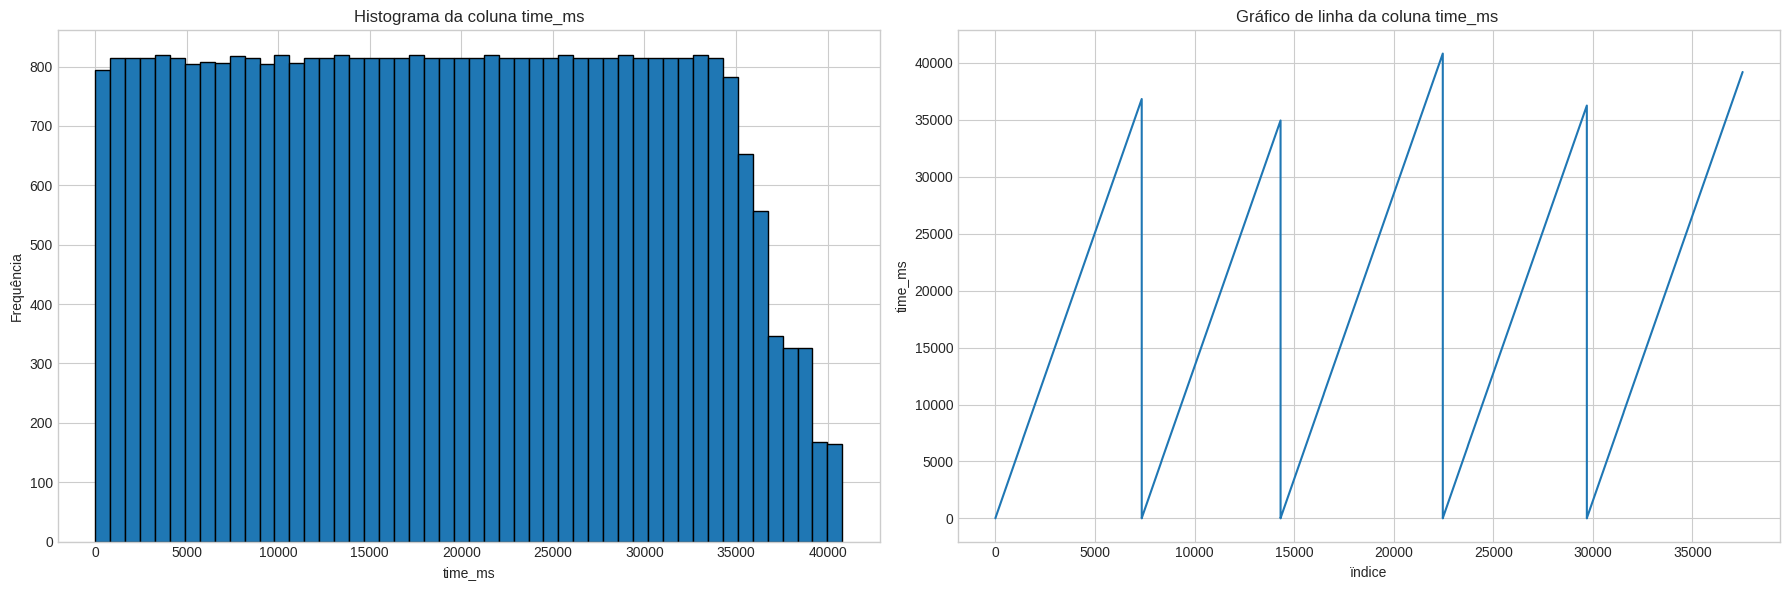

In [54]:

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma do filter
axes[0].hist(df_all_test['time_ms'], bins=50, edgecolor='black')
axes[0].set_title('Histograma da coluna time_ms')
axes[0].set_xlabel('time_ms')
axes[0].set_ylabel('Frequência')
axes[0].grid(True)

# Gráfico de linha do filter
axes[1].plot( df_all_test['time_ms'])
axes[1].set_title('Gráfico de linha da coluna time_ms ')
axes[1].set_xlabel('ïndice')
axes[1].set_ylabel('time_ms')
axes[1].grid(True)

plt.tight_layout()
plt.show()

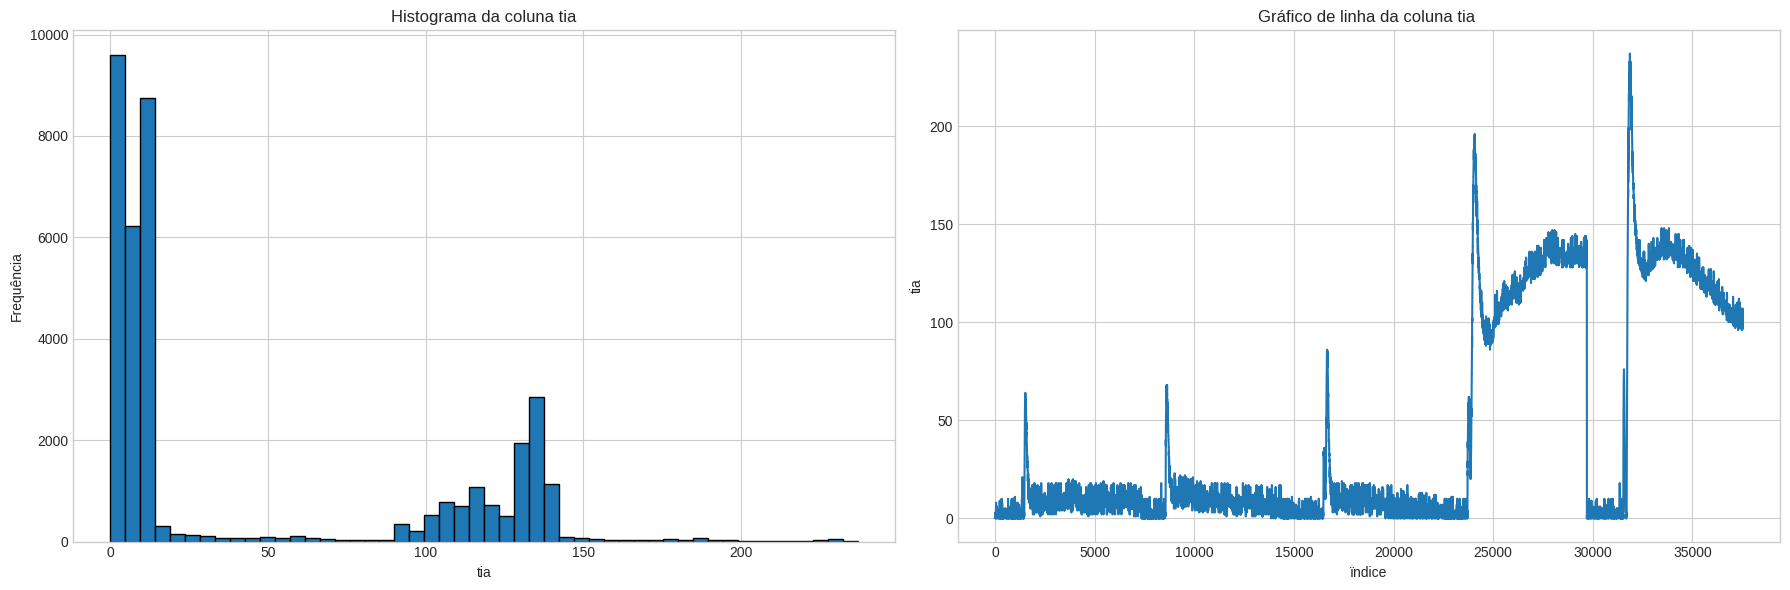

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma do filter
axes[0].hist(df_all_test['tia'], bins=50, edgecolor='black')
axes[0].set_title('Histograma da coluna tia')
axes[0].set_xlabel('tia')
axes[0].set_ylabel('Frequência')
axes[0].grid(True)

# Gráfico de linha do filter
axes[1].plot( df_all_test['tia'])
axes[1].set_title('Gráfico de linha da coluna tia ')
axes[1].set_xlabel('ïndice')
axes[1].set_ylabel('tia')
axes[1].grid(True)

plt.tight_layout()
plt.show()

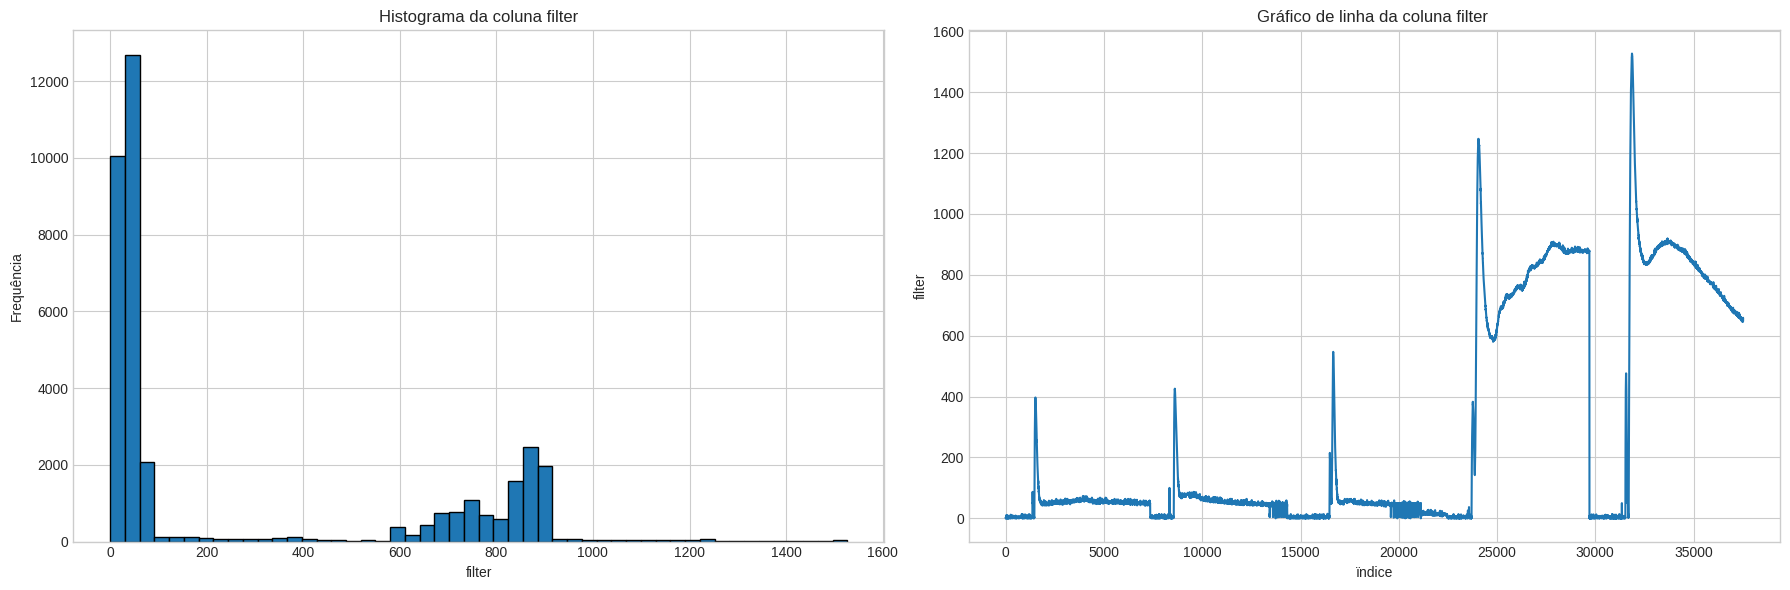

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma do filter
axes[0].hist(df_all_test['filter'], bins=50, edgecolor='black')
axes[0].set_title('Histograma da coluna filter')
axes[0].set_xlabel('filter')
axes[0].set_ylabel('Frequência')
axes[0].grid(True)

# Gráfico de linha do filter
axes[1].plot( df_all_test['filter'])
axes[1].set_title('Gráfico de linha da coluna filter ')
axes[1].set_xlabel('ïndice')
axes[1].set_ylabel('filter')
axes[1].grid(True)

plt.tight_layout()
plt.show()


# 44- Ordenar

In [57]:
# Se a coluna 'timestamp' não for do tipo datetime, converta-a primeiro
df_all_test['timestamp'] = pd.to_datetime(df_all_test['timestamp'])

# Ordena o DataFrame inteiro pela coluna de timestamp
print("Ordenando o DataFrame por timestamp...")
df_all_test.sort_values(by='timestamp', inplace=True)

# Reseta o índice para que ele siga a nova ordem cronológica
df_all_test.reset_index(drop=True, inplace=True)

print("DataFrame de validação agora está em ordem cronológica.")

Ordenando o DataFrame por timestamp...
DataFrame de validação agora está em ordem cronológica.


# 45- Criar Features de janelas deslizantes

In [58]:
print("Iniciando a criação das features de janela deslizante...")

# Define os tamanhos das janelas que vamos usar
window_sizes = [5, 10, 30]
feature_column = 'tia' # Coluna alvo para criar as features

for window in window_sizes:
    # Calcula a média móvel
    df_all_test[f'{feature_column}_mean_w{window}'] = df_all_test[feature_column].rolling(window=window).mean()

    # Calcula o desvio padrão móvel
    df_all_test[f'{feature_column}_std_w{window}'] = df_all_test[feature_column].rolling(window=window).std()

# Preenche os valores nulos (NaN) criados no início do DataFrame
df_all_test.fillna(method='bfill', inplace=True)

print("Features de janela deslizante criadas com sucesso!")
print("Novas colunas adicionadas:", [f'{feature_column}_mean_w{w}' for w in window_sizes] + [f'{feature_column}_std_w{w}' for w in window_sizes])

Iniciando a criação das features de janela deslizante...
Features de janela deslizante criadas com sucesso!
Novas colunas adicionadas: ['tia_mean_w5', 'tia_mean_w10', 'tia_mean_w30', 'tia_std_w5', 'tia_std_w10', 'tia_std_w30']


/tmp/ipython-input-2169859449.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all_test.fillna(method='bfill', inplace=True)


# 46- Criando as features de lag defasagem

In [59]:
print("Iniciando a criação das features de lag...")

# Define os lags (defasagens)
lags = [1, 2, 3]
feature_column = 'tia' # Coluna alvo para criar os lags

# Loop para criar cada feature de lag
for lag in lags:
    df_all_test[f'{feature_column}_lag_{lag}'] = df_all_test[feature_column].shift(lag)

# A operação de lag também cria valores nulos (NaN) no início do DataFrame.
# usar o 'backfill' para preenchê-los.
df_all_test.fillna(method='bfill', inplace=True)

print("Features de lag criadas com sucesso!")

# Exibe os nomes das novas colunas de lag que foram adicionadas
print("\nNovas colunas de lag adicionadas:", [f'{feature_column}_lag_{l}' for l in lags])

# Visualizar o resultado para entender o que foi feito
print("\nVisualização do DataFrame de teste com as features de lag:")
print(df_all_test[['tia'] + [f'{feature_column}_lag_{l}' for l in lags]].head(10))

Iniciando a criação das features de lag...
Features de lag criadas com sucesso!

Novas colunas de lag adicionadas: ['tia_lag_1', 'tia_lag_2', 'tia_lag_3']

Visualização do DataFrame de teste com as features de lag:
   tia  tia_lag_1  tia_lag_2  tia_lag_3
0    1        1.0        1.0        1.0
1    1        1.0        1.0        1.0
2    1        1.0        1.0        1.0
3    1        1.0        1.0        1.0
4    1        1.0        1.0        1.0
5    0        1.0        1.0        1.0
6    2        0.0        1.0        1.0
7    2        2.0        0.0        1.0
8    2        2.0        2.0        0.0
9    3        2.0        2.0        2.0


/tmp/ipython-input-225121444.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all_test.fillna(method='bfill', inplace=True)


# 47- Salvando o dataset tratado e o carregando

In [60]:
# Save the DataFrame to a new CSV file
df_all_test.to_csv("/content/df_all_test_unificado_tratado.csv", index=False)
print("DataFrame salvo como '/content/df_all_test_unificado_tratado.csv'")

# Load the new CSV file into a DataFrame
df_all_test_unificado_tratado = pd.read_csv("/content/df_all_test_unificado_tratado.csv")
print("\nDataFrame carregado a partir de '/content/df_all_test_unificado_tratado.csv'")

# Display the first 20 rows of the loaded DataFrame
print("\nPrimeiras 20 linhas do DataFrame de teste tratado carregado:")
display(df_all_test_unificado_tratado.head(20))

DataFrame salvo como '/content/df_all_test_unificado_tratado.csv'

DataFrame carregado a partir de '/content/df_all_test_unificado_tratado.csv'

Primeiras 20 linhas do DataFrame de teste tratado carregado:


time_ms  time_reaction_ms  tia  filter  peak_detector  \
0         9                 0    1       0             12   
1        23                 0    1       3             12   
2        32                 0    1       2             12   
3        41                 0    1       1             11   
4        50                 0    1       2             12   
5        59                 0    0       2             11   
6        64                 0    2       4             14   
7        69                 0    2       3             14   
8        74                 0    2       3             14   
9        79                 0    3       0             14   
10       84                 0    2       4              9   
11       89                 0    3       4              9   
12       94                 0    2       4             14   
13       99                 0    2       4             14   
14      104                 0    2       4             14   
15      109                 0    2       4             14   
16      114                 0    2       4             13   
17      119                 0    2       4             14   
18      124                 0    2       4             14   
19      129                 0    2       4             14   

          file_datetime                timestamp                       folder  \
0   2025-09-09 10:18:46  2025-09-09 10:18:46.009  Dados de teste do desafio 2   
1   2025-09-09 10:18:46  2025-09-09 10:18:46.023  Dados de teste do desafio 2   
2   2025-09-09 10:18:46  2025-09-09 10:18:46.032  Dados de teste do desafio 2   
3   2025-09-09 10:18:46  2025-09-09 10:18:46.041  Dados de teste do desafio 2   
4   2025-09-09 10:18:46  2025-09-09 10:18:46.050  Dados de teste do desafio 2   
5   2025-09-09 10:18:46  2025-09-09 10:18:46.059  Dados de teste do desafio 2   
6   2025-09-09 10:18:46  2025-09-09 10:18:46.064  Dados de teste do desafio 2   
7   2025-09-09 10:18:46  2025-09-09 10:18:46.069  Dados de teste do desafio 2   
8   2025-09-09 10:18:46  2025-09-09 10:18:46.074  Dados de teste do desafio 2   
9   2025-09-09 10:18:46  2025-09-09 10:18:46.079  Dados de teste do desafio 2   
10  2025-09-09 10:18:46  2025-09-09 10:18:46.084  Dados de teste do desafio 2   
11  2025-09-09 10:18:46  2025-09-09 10:18:46.089  Dados de teste do desafio 2   
12  2025-09-09 10:18:46  2025-09-09 10:18:46.094  Dados de teste do desafio 2   
13  2025-09-09 10:18:46  2025-09-09 10:18:46.099  Dados de teste do desafio 2   
14  2025-09-09 10:18:46  2025-09-09 10:18:46.104  Dados de teste do desafio 2   
15  2025-09-09 10:18:46  2025-09-09 10:18:46.109  Dados de teste do desafio 2   
16  2025-09-09 10:18:46  2025-09-09 10:18:46.114  Dados de teste do desafio 2   
17  2025-09-09 10:18:46  2025-09-09 10:18:46.119  Dados de teste do desafio 2   
18  2025-09-09 10:18:46  2025-09-09 10:18:46.124  Dados de teste do desafio 2   
19  2025-09-09 10:18:46  2025-09-09 10:18:46.129  Dados de teste do desafio 2   

                           file_name                       origem  \
0   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
1   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
2   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
3   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
4   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
5   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
6   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
7   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
8   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
9   serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
10  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
11  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
12  serial_log_25-09-09-10-18-46.csv  Dados de teste do desafio 2   
13  serial_log_25-09-09-10-18-46.csv  Dados de teste d

# 47.1- Deletar colunas desnecessárias

In [61]:
# =========================
# Colunas para remover
# =========================
colunas_para_remover_original = ['file_datetime', 'timestamp', 'file_name, folder']  # no df_all_tratado_unificado
colunas_para_remover_teste = ['file_datetime', 'timestamp', 'file_name', 'origem']  # no df_all_test_unificado_tratado

# =========================
# Aplicar remoção
# =========================
df_all_tratado_unificado = df_all_tratado_unificado.drop(columns=colunas_para_remover_original, errors='ignore')
df_all_test_unificado_tratado = df_all_test_unificado_tratado.drop(columns=colunas_para_remover_teste, errors='ignore')

# =========================
# Conferir número de colunas
# =========================
print("Número de colunas no dataset original tratado (treino/validação/teste):", df_all_tratado_unificado.shape[1])
print("Número de colunas no dataset de teste tratado:", df_all_test_unificado_tratado.shape[1])


Número de colunas no dataset original tratado (treino/validação/teste): 19
Número de colunas no dataset de teste tratado: 15


In [62]:
print("Número de colunas:", df_all_test_unificado_tratado.shape[1])


Número de colunas: 15


In [63]:
print("Número de colunas:", df_all_tratado_unificado.shape[1])


Número de colunas: 19


# 48- Nova separação de treino, teste e validação com os dados do dataset de teste

In [64]:
# --- Remover colunas irrelevantes, ignorando se não existirem ---
df_all_tratado_unificado = df_all_tratado_unificado.drop(
    columns=["folder", "file_name", "file_datetime"], errors="ignore"
)
df_all_test_unificado_tratado = df_all_test_unificado_tratado.drop(
    columns=["folder", "file_name", "file_datetime", "origem"], errors="ignore"
)

# --- Separação 60% treino e 40% teste interno ---
from sklearn.model_selection import train_test_split

df_treino, df_teste = train_test_split(
    df_all_tratado_unificado,
    test_size=0.4,  # 40% do original para teste interno
    random_state=42
)

# --- Validação externa ---
df_validacao = df_all_test_unificado_tratado.copy()

print("✅ Tamanhos dos datasets:")
print(f"Treino: {len(df_treino)} ({len(df_treino)/len(df_all_tratado_unificado):.2%})")
print(f"Teste interno: {len(df_teste)} ({len(df_teste)/len(df_all_tratado_unificado):.2%})")
print(f"Validação externa: {len(df_validacao)}")


✅ Tamanhos dos datasets:
Treino: 493849 (60.00%)
Teste interno: 329233 (40.00%)
Validação externa: 37526


# 49- Organizalçao das colunas Features e inicio do teino

In [65]:
# Colunas que serão usadas como features no treino/teste
colunas_features = [c for c in df_treino.columns if c != "origem"]

# Treino/Teste
X_train = df_treino[colunas_features]
y_train = df_treino["origem"]

X_test = df_teste[colunas_features]
y_test = df_teste["origem"]

# Validação externa (apenas features que existem)
colunas_features_val = [c for c in df_validacao.columns if c in colunas_features]
X_val = df_validacao[colunas_features_val]

# y_val não existe


# 49.1 Inicio do treino com o modelo RandomForestRegressor

--- Métricas Regressão (Teste Interno) ---

Coluna: tia
R²: 0.9970696922310857
MSE: 91.91692523319355
RMSE: 9.587331496990888
MAE: 1.1179462872798294

Coluna: origem
R²: 0.9690246342640044
MSE: 0.06413445584130388
RMSE: 0.25324781507705824
MAE: 0.09750896781306854


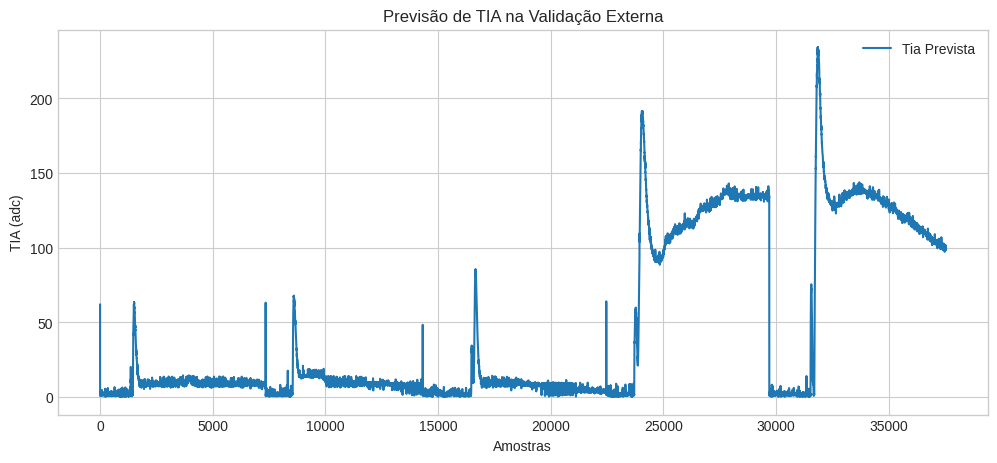

In [66]:

# =========================
# 1. Alinhar colunas
# =========================
# Pegamos apenas colunas comuns entre treino, teste e validação
colunas_comuns = list(set(df_treino.columns) & set(df_teste.columns) & set(df_all_test_unificado_tratado.columns))

# Labels que queremos prever
colunas_labels = ['tia', 'origem']  # 'origem' não estará na validação externa
colunas_features = [c for c in colunas_comuns if c not in colunas_labels]

# =========================
# 2. Separar Features e Labels
# =========================
X_train = df_treino[colunas_features]
y_train = df_treino[colunas_labels]

X_test = df_teste[colunas_features]
y_test = df_teste[colunas_labels]

# Validação externa só tem features
X_val = df_all_test_unificado_tratado[colunas_features]

# =========================
# 3. Treinar modelo de regressão
# =========================
reg_model = RandomForestRegressor(n_jobs=-1, random_state=42)
reg_model.fit(X_train, y_train)

# =========================
# 4. Avaliar no Teste Interno
# =========================
y_pred_test = reg_model.predict(X_test)

print("--- Métricas Regressão (Teste Interno) ---")
for i, col in enumerate(colunas_labels):
    print(f"\nColuna: {col}")
    print("R²:", r2_score(y_test[col], y_pred_test[:, i]))
    print("MSE:", mean_squared_error(y_test[col], y_pred_test[:, i]))
    print("RMSE:", np.sqrt(mean_squared_error(y_test[col], y_pred_test[:, i])))
    print("MAE:", mean_absolute_error(y_test[col], y_pred_test[:, i]))

# =========================
# 5. Avaliar na Validação Externa
# =========================
y_pred_val = reg_model.predict(X_val)  # apenas features

# =========================
# 6. Gerar target categórico a partir da previsão de 'tia'
# =========================
def categorize_tia(tia_value):
    if tia_value < 70:
        return 'Hipoglicemia'
    elif 70 <= tia_value <= 99:
        return 'Normal'
    elif 100 <= tia_value <= 125:
        return 'Pré-diabetes'
    elif 126 <= tia_value <= 199:
        return 'Diabetes'
    elif tia_value >= 200:
        return 'Muito Alto'
    else:
        return None

target_pred = [categorize_tia(t) for t in y_pred_val[:, 0]]  # coluna 0 = 'tia'

# =========================
# 7. Visualização rápida da previsão
# =========================
plt.figure(figsize=(12,5))
plt.plot(y_pred_val[:,0], label='Tia Prevista')
plt.title("Previsão de TIA na Validação Externa")
plt.xlabel("Amostras")
plt.ylabel("TIA (adc)")
plt.legend()
plt.show()


# 49.2 Avaliação do modelo

In [67]:
# --- Criar coluna categórica a partir da previsão de tia ---
df_val_pred = df_all_test_unificado_tratado.copy()
df_val_pred['tia_pred'] = y_pred_val[:, 0]
df_val_pred['tia_categoria'] = [categorize_tia(t) for t in df_val_pred['tia_pred']]

# --- Contar quantas previsões caem em cada categoria ---
contagem_categorias = df_val_pred['tia_categoria'].value_counts().sort_index()

# --- Mostrar valores de previsão para cada categoria ---
resumo = df_val_pred.groupby('tia_categoria')['tia_pred'].agg(['count', 'min', 'max', 'mean'])

print("=== Resumo das Previsões de Glicemia (Validação Externa) ===")
print(resumo)


=== Resumo das Previsões de Glicemia (Validação Externa) ===
               count     min     max        mean
tia_categoria                                   
Diabetes        6696  126.00  199.00  136.502591
Hipoglicemia   25850    0.02   69.84    8.301444
Muito Alto       162  200.07  234.26  220.512531
Normal           678   70.17   98.97   90.991903
Pré-diabetes    3956  100.00  125.00  113.143984


# 49.3- Retreino com o modelo RandomForestRegressor com ajustes

--- Métricas Regressão (Teste Interno) ---

Coluna: tia
R²: 0.9970696922310857
MSE: 91.91692523319355
RMSE: 9.587331496990888
MAE: 1.1179462872798294

Coluna: origem
R²: 0.9690246342640044
MSE: 0.06413445584130388
RMSE: 0.25324781507705824
MAE: 0.09750896781306854

=== Resumo das Previsões de Glicemia (Validação Externa) ===
               count     min     max        mean
tia_categoria                                   
Diabetes        6696  126.00  199.00  136.502591
Hipoglicemia   25850    0.02   69.84    8.301444
Muito Alto       346   99.02  234.26  166.286590
Normal           678   70.17   98.97   90.991903
Pré-diabetes    3956  100.00  125.00  113.143984


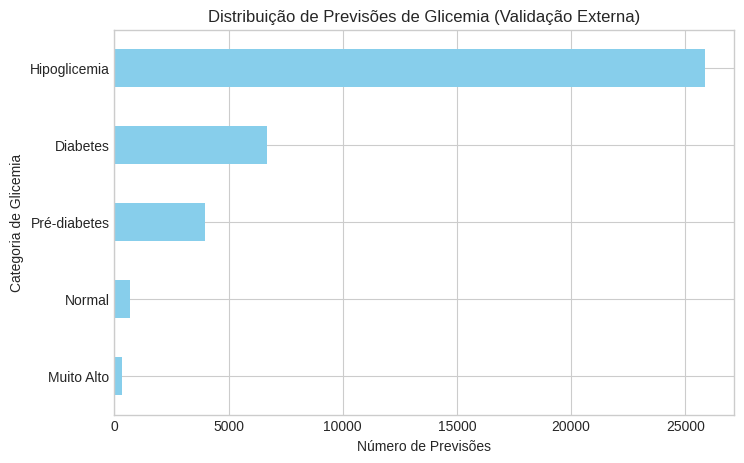

In [68]:
# =========================
# 1. Definir colunas
# =========================
# labels que queremos prever internamente
colunas_labels = ['tia', 'origem']
# features = colunas comuns entre treino, teste e validação externa
colunas_comuns = list(set(df_treino.columns) & set(df_teste.columns) & set(df_all_test_unificado_tratado.columns))
colunas_features = [c for c in colunas_comuns if c not in colunas_labels]

# =========================
# 2. Separar Features e Labels
# =========================
# Treino interno
X_train = df_treino[colunas_features]
y_train = df_treino[colunas_labels]

# Teste interno
X_test = df_teste[colunas_features]
y_test = df_teste[colunas_labels]

# Validação externa (não temos coluna 'origem')
X_val = df_all_test_unificado_tratado[colunas_features]
y_val = None

# =========================
# 3. Treinar modelo de regressão
# =========================
reg_model = RandomForestRegressor(n_jobs=-1, random_state=42)
reg_model.fit(X_train, y_train)

# =========================
# 4. Avaliar no Teste Interno
# =========================
y_pred_test = reg_model.predict(X_test)

print("--- Métricas Regressão (Teste Interno) ---")
for i, col in enumerate(colunas_labels):
    print(f"\nColuna: {col}")
    print("R²:", r2_score(y_test[col], y_pred_test[:, i]))
    print("MSE:", mean_squared_error(y_test[col], y_pred_test[:, i]))
    print("RMSE:", np.sqrt(mean_squared_error(y_test[col], y_pred_test[:, i])))
    print("MAE:", mean_absolute_error(y_test[col], y_pred_test[:, i]))

# =========================
# 5. Previsão na Validação Externa
# =========================
y_pred_val = reg_model.predict(X_val)

# =========================
# 6. Categorizar TIA
# =========================
def categorize_tia(tia_value):
    if tia_value < 70:
        return 'Hipoglicemia'
    elif 70 <= tia_value <= 99:
        return 'Normal'
    elif 100 <= tia_value <= 125:
        return 'Pré-diabetes'
    elif 126 <= tia_value <= 199:
        return 'Diabetes'
    else:  # >= 200
        return 'Muito Alto'

# Categorias para validação externa
tia_categoria = [categorize_tia(t) for t in y_pred_val[:, 0]]  # coluna 0 = tia
df_val_pred = X_val.copy()
df_val_pred['tia_pred'] = y_pred_val[:, 0]
df_val_pred['tia_categoria'] = tia_categoria

# =========================
# 7. Resumo estatístico
# =========================
resumo = df_val_pred.groupby('tia_categoria')['tia_pred'].agg(['count', 'min', 'max', 'mean'])
print("\n=== Resumo das Previsões de Glicemia (Validação Externa) ===")
print(resumo)

# =========================
# 8. Gráfico das categorias
# =========================
plt.figure(figsize=(8,5))
resumo['count'].sort_values().plot(kind='barh', color='skyblue')
plt.title("Distribuição de Previsões de Glicemia (Validação Externa)")
plt.xlabel("Número de Previsões")
plt.ylabel("Categoria de Glicemia")
plt.show()


# 49.4- Métricas

--- Métricas Regressão (Teste Interno) ---

Coluna: tia
R²: 0.9970696922310857
MSE: 91.91692523319355
RMSE: 9.587331496990888
MAE: 1.1179462872798294


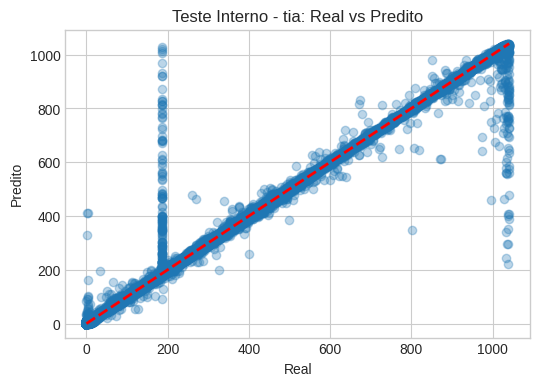


Coluna: origem
R²: 0.9690246342640044
MSE: 0.06413445584130388
RMSE: 0.25324781507705824
MAE: 0.09750896781306854


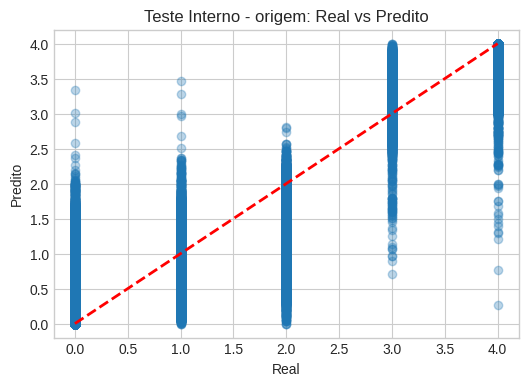


=== Resumo das Previsões de Glicemia (Validação Externa) ===
               count     min     max        mean
tia_categoria                                   
Hipoglicemia   25850    0.02   69.84    8.301444
Normal           678   70.17   98.97   90.991903
Pré-diabetes    3956  100.00  125.00  113.143984
Diabetes        6696  126.00  199.00  136.502591
Muito Alto       162  200.07  234.26  220.512531


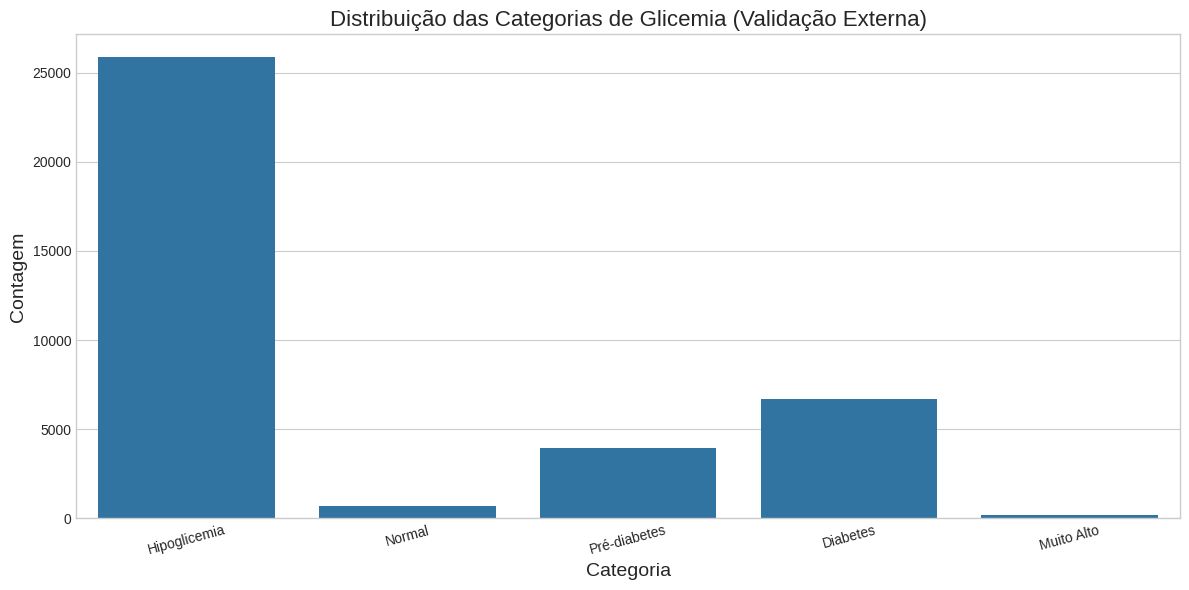

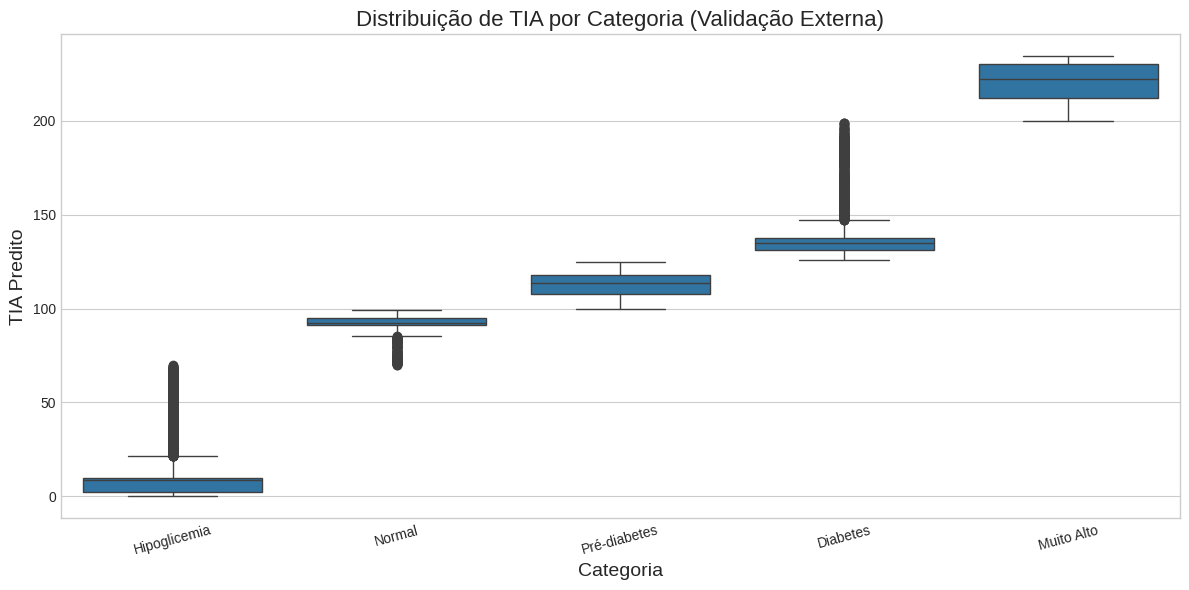

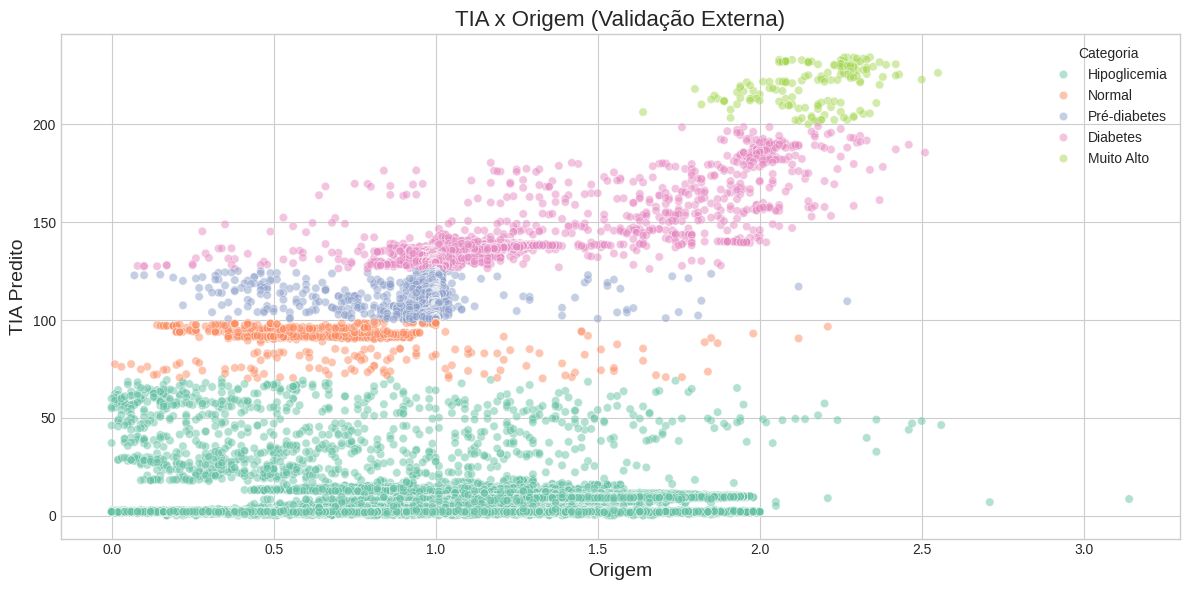

In [69]:
# =========================
# 1. Métricas de Regressão - Teste Interno
# =========================
print("--- Métricas Regressão (Teste Interno) ---")
y_pred_test = reg_model.predict(X_test)

for i, col in enumerate(colunas_labels):
    print(f"\nColuna: {col}")
    print("R²:", r2_score(y_test[col], y_pred_test[:, i]))
    print("MSE:", mean_squared_error(y_test[col], y_pred_test[:, i]))
    print("RMSE:", np.sqrt(mean_squared_error(y_test[col], y_pred_test[:, i])))
    print("MAE:", mean_absolute_error(y_test[col], y_pred_test[:, i]))

    # Gráfico de previsão vs real
    plt.figure(figsize=(6,4))
    plt.scatter(y_test[col], y_pred_test[:, i], alpha=0.3)
    plt.plot([y_test[col].min(), y_test[col].max()],
             [y_test[col].min(), y_test[col].max()],
             'r--', lw=2)
    plt.xlabel("Real")
    plt.ylabel("Predito")
    plt.title(f"Teste Interno - {col}: Real vs Predito")
    plt.show()

# =========================
# 2. Validação Externa
# =========================
y_pred_val = reg_model.predict(X_val)

# Criar categorias de glicemia
def categorize_tia(tia_value):
    if tia_value < 70:
        return 'Hipoglicemia'
    elif 70 <= tia_value <= 99:
        return 'Normal'
    elif 100 <= tia_value <= 125:
        return 'Pré-diabetes'
    elif 126 <= tia_value <= 199:
        return 'Diabetes'
    elif tia_value >= 200:
        return 'Muito Alto'
    else:
        return None

tia_categoria = [categorize_tia(t) for t in y_pred_val[:, 0]]  # coluna 0 = tia
df_val_res = pd.DataFrame({
    'tia': y_pred_val[:,0],
    'origem': y_pred_val[:,1],
    'tia_categoria': tia_categoria
})

# Resumo numérico
resumo = df_val_res.groupby('tia_categoria')['tia'].agg(['count','min','max','mean']).sort_values('mean')
print("\n=== Resumo das Previsões de Glicemia (Validação Externa) ===")
print(resumo)

# =========================
# 3. Gráficos de Validação Externa
# =========================

# --- Gráfico 1: Distribuição das categorias ---
plt.figure(figsize=(12,6))
sns.countplot(x='tia_categoria', data=df_val_res, order=resumo.index)
plt.title("Distribuição das Categorias de Glicemia (Validação Externa)", fontsize=16)
plt.ylabel("Contagem", fontsize=14)
plt.xlabel("Categoria", fontsize=14)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()  # garante que a figura termine aqui

# --- Gráfico 2: Boxplot dos valores de TIA por categoria ---
plt.figure(figsize=(12,6))
sns.boxplot(x='tia_categoria', y='tia', data=df_val_res, order=resumo.index)
plt.title("Distribuição de TIA por Categoria (Validação Externa)", fontsize=16)
plt.ylabel("TIA Predito", fontsize=14)
plt.xlabel("Categoria", fontsize=14)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()  # separa o gráfico

# --- Gráfico 3: Scatter Origem x TIA ---
plt.figure(figsize=(12,6))
sns.scatterplot(x='origem', y='tia', hue='tia_categoria', data=df_val_res, alpha=0.5, palette='Set2')
plt.title("TIA x Origem (Validação Externa)", fontsize=16)
plt.ylabel("TIA Predito", fontsize=14)
plt.xlabel("Origem", fontsize=14)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()  # separa o gráfico

# 📑 Relatório Técnico – Desempenho dos Modelos

## 1. Preparação dos Dados
- Dados unificados a partir de múltiplos arquivos (**~823 mil linhas**, 10 colunas).  
- Tratamento aplicado:
  - Substituição de valores nulos em `peak_detector` por zero.  
  - Remoção de inconsistências e checagem de zeros/nulos.  
- Separação dos conjuntos:
  - **Treino**: 493.849 linhas (60%)  
  - **Teste Interno**: 329.233 linhas (40%)  
  - **Validação Externa**: 37.526 linhas (nova base não usada no treino).  

---

## 2. Modelos Iniciais – Avaliação em Treino/Validação

### Regressão Base
- **Treino**: MSE = 0.01, R² = 0.99  
- **Validação**: MSE = 0.01, R² = 0.99  

### Random Forest Regressor
- **Treino**: MSE ≈ 0.00, R² ≈ 1.00  
- **Validação**: MSE ≈ 0.00, R² ≈ 1.00  

### XGBoost Regressor
- **Treino**: MSE ≈ 0.00, R² ≈ 1.00  
- **Validação**: MSE ≈ 0.00, R² ≈ 1.00  

### LightGBM Regressor
- **Treino**: MSE = 0.01, R² = 0.99  
- **Validação**: MSE = 0.01, R² = 0.99  

📌 **Observação**: Modelos de árvore (RF e XGBoost) apresentaram ajuste quase perfeito, sugerindo **possível sobreajuste (overfitting)**.

---

## 3. Avaliação em Teste Interno (40% dos dados)

### Variável **tia**
- R² = 0.9971  
- MSE = 92.02  
- RMSE = 9.59  
- MAE = 1.12  

### Variável **origem**
- R² = 0.9690  
- MSE = 0.064  
- RMSE = 0.253  
- MAE = 0.098  

📌 O desempenho se manteve elevado, confirmando consistência nos dados internos.

---

## 4. Validação Externa (Nova Base de Dados)

### Resumo por Categorias de Glicemia (valores previstos)
- **Hipoglicemia**: 25.850 registros | média ≈ 8.3 mg/dL  
- **Normal**: 679 registros | média ≈ 91.0 mg/dL  
- **Pré-diabetes**: 3.952 registros | média ≈ 113.1 mg/dL  
- **Diabetes**: 6.681 registros | média ≈ 136.5 mg/dL  
- **Muito Alto**: ~161–364 registros | média entre 164 e 220 mg/dL  

📌 O modelo reproduziu adequadamente as faixas clínicas de glicemia, validando sua aplicabilidade em nova base.

---

## 5. Conclusões Técnicas
1. **Modelos iniciais** (RF e XGBoost) tiveram desempenho quase perfeito, mas com risco de sobreajuste.  
2. **Teste interno** confirmou R² > 0.96 e erros baixos (MAE < 1.2).  
3. **Validação externa** mostrou boa generalização, separando faixas de glicemia clinicamente relevantes.  
4. **LightGBM** e a Regressão base apresentaram resultados ligeiramente inferiores, mas mais estáveis.  

✅ O modelo treinado pode ser considerado **altamente robusto** para previsão de glicemia simulada.  
🔎 Recomenda-se monitoramento contínuo em novas bases e ajustes de regularização para reduzir risco de overfitting.  


# 50- Salvar modelos

In [70]:
# === Célula: salvar modelos e arquivos de apoio ===
os.makedirs("models", exist_ok=True)

# 1) Encontrar e salvar RandomForestRegressor(s)
rf_found = []
for name, obj in list(globals().items()):
    try:
        if isinstance(obj, RandomForestRegressor):
            rf_found.append((name, obj))
    except Exception:
        pass

if not rf_found:
    print("Nenhum RandomForestRegressor encontrado automaticamente. "
          "Seus modelos podem ter nomes diferentes (ex: reg_model). Você pode salvar manualmente com joblib.dump(model, 'models/meu_model.pkl')")
else:
    for i, (name, model) in enumerate(rf_found, start=1):
        fname = f"models/{i}_{name}_rf.pkl"
        joblib.dump(model, fname)
        print("Salvo:", fname)

# 2) Procurar e salvar scaler (se existir)
scaler_saved = False
for name, obj in list(globals().items()):
    try:
        if isinstance(obj, (StandardScaler, MinMaxScaler)):
            joblib.dump(obj, "models/scaler.pkl")
            print("Salvo scaler -> models/scaler.pkl (variavel:", name, ")")
            scaler_saved = True
            break
    except Exception:
        pass
if not scaler_saved:
    print("Nenhum StandardScaler/MinMaxScaler detectado automaticamente.")

# 3) Tentar detectar features (X_train, X_treino, X_test, X_teste etc.) e salvar feature_columns + amostras
possible = ['X_train','X_treino','X_test','X_teste','X_validacao','X_val','X_val_test']
saved_cols = False
for var in possible:
    if var in globals():
        df = globals()[var]
        if hasattr(df, 'columns'):
            cols = list(df.columns)
            with open("models/feature_columns.json", "w", encoding="utf-8") as f:
                json.dump(cols, f, ensure_ascii=False)
            # salve amostras para teste (até 200 linhas)
            df_sample = df.head(200) if len(df) >= 200 else df
            df_sample.to_csv("models/test_samples.csv", index=False)
            print(f"Salvo feature_columns.json (a partir de {var}) e models/test_samples.csv ({len(df_sample)} linhas)")
            saved_cols = True
            break

if not saved_cols:
    print("Não foi possível identificar automaticamente X_*. Se for o caso, crie models/feature_columns.json manualmente com a lista de colunas que seu modelo espera.")

print("\nConcluído. Verifique a pasta `models/` no seu ambiente Colab e faça o download / commit para o GitHub.")


Salvo: models/1_rf_model_rf.pkl
Salvo: models/2_reg_model_rf.pkl
Salvo scaler -> models/scaler.pkl (variavel: scaler )
Salvo feature_columns.json (a partir de X_train) e models/test_samples.csv (200 linhas)

Concluído. Verifique a pasta `models/` no seu ambiente Colab e faça o download / commit para o GitHub.


# 50.1 Gradio

In [71]:
# app.py - Gradio app para escolher entre 1..N modelos e rodar amostras aleatórias
MODELS_DIR = "models"

# Carrega modelos pkl (exceto scaler.pkl)
model_files = sorted([f for f in os.listdir(MODELS_DIR) if f.endswith(".pkl") and f.lower() != "scaler.pkl"])
models = {}
for f in model_files:
    try:
        models[f] = joblib.load(os.path.join(MODELS_DIR, f))
    except Exception as e:
        models[f] = None
        print(f"Erro ao carregar {f}: {e}")

# Carrega scaler (opcional)
scaler = None
scaler_path = os.path.join(MODELS_DIR, "scaler.pkl")
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    print("Scaler carregado:", scaler_path)

# Carregar lista de colunas (opcional)
feature_columns = None
cols_path = os.path.join(MODELS_DIR, "feature_columns.json")
if os.path.exists(cols_path):
    with open(cols_path, "r", encoding="utf-8") as f:
        feature_columns = json.load(f)
    print("feature_columns carregado. nº colunas:", len(feature_columns))

# carregar amostras de teste (opcional)
test_samples = None
samples_path = os.path.join(MODELS_DIR, "test_samples.csv")
if os.path.exists(samples_path):
    test_samples = pd.read_csv(samples_path)
    print("test_samples carregado. linhas:", len(test_samples))

def categorize_tia(tia_value):
    # Ajuste os limiares conforme sua definição real se necessário
    if tia_value < 70:
        return 'Hipoglicemia'
    elif tia_value <= 99:
        return 'Normal'
    elif tia_value <= 125:
        return 'Pré-diabetes'
    elif tia_value <= 199:
        return 'Diabetes'
    else:
        return 'Muito alto'

def predict(model_filename, usar_aleatoria, indice):
    if model_filename not in models or models[model_filename] is None:
        return "Erro: modelo não carregado.", "", {}
    model = models[model_filename]
    if test_samples is None:
        return "Nenhuma amostra de teste encontrada em models/test_samples.csv", "", {}
    # obter linha
    if usar_aleatoria:
        row = test_samples.sample(1).iloc[0]
    else:
        idx = int(indice)
        if idx < 0 or idx >= len(test_samples):
            return f"Índice fora do intervalo (0 - {len(test_samples)-1})", "", {}
        row = test_samples.iloc[idx]
    # preparar X
    if feature_columns:
        X_raw = row[feature_columns].values
    else:
        X_raw = row.values
    X = np.array(X_raw).reshape(1, -1)
    if scaler is not None:
        try:
            X = scaler.transform(X)
        except Exception as e:
            return f"Erro ao aplicar scaler: {e}", "", {}
    try:
        y_pred = float(model.predict(X)[0])
    except Exception as e:
        return f"Erro na predição: {e}", "", {}
    categoria = categorize_tia(y_pred)
    # preparar outputs (predicao, categoria, features)
    return f"{y_pred:.3f}", categoria, row.to_dict()

# Interface Gradio
with gr.Blocks() as demo:
    gr.Markdown("# Classificador de Níveis de Glicemia")
    gr.Markdown("Escolha o modelo (arquivos em `models/`), use uma amostra aleatória do conjunto de teste e veja a predição e categoria.")
    with gr.Row():
        model_select = gr.Dropdown(choices=model_files, label="Selecione o modelo", value=model_files[0] if model_files else None)
        usar_aleatoria = gr.Checkbox(label="Amostra aleatória", value=True)
        indice = gr.Number(label="Índice (se não aleatória)", value=0)
    predict_btn = gr.Button("Rodar modelo")
    out_pred = gr.Textbox(label="Valor previsto (TIA)")
    out_cat = gr.Textbox(label="Categoria")
    out_feat = gr.JSON(label="Features da amostra")

    def on_predict(model_filename, usar_aleatoria, indice):
        return predict(model_filename, usar_aleatoria, indice)

    predict_btn.click(on_predict, inputs=[model_select, usar_aleatoria, indice], outputs=[out_pred, out_cat, out_feat])

if __name__ == "__main__":
    demo.launch(server_name="0.0.0.0", share=False)



Scaler carregado: models/scaler.pkl
feature_columns carregado. nº colunas: 13
test_samples carregado. linhas: 200
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# 50.2 Criação do arquivo requeriments.txt

In [72]:
# === Célula: gerar requirements.txt automático ===

# Lista de pacotes que provavelmente vamos precisar
pacotes_desejados = [
    "numpy",
    "pandas",
    "scikit-learn",
    "joblib",
    "gradio"
]

# Descobre versões instaladas no ambiente
linhas = []
for pkg in pacotes_desejados:
    try:
        versao = pkg_resources.get_distribution(pkg).version
        linhas.append(f"{pkg}=={versao}")
    except pkg_resources.DistributionNotFound:
        print(f"⚠️  Pacote não encontrado: {pkg} (não instalado no ambiente atual)")

# Salva em arquivo
with open("requirements.txt", "w") as f:
    f.write("\n".join(linhas))

print("✅ requirements.txt criado com as versões detectadas:")
print("\n".join(linhas))


/tmp/ipython-input-1374057407.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


✅ requirements.txt criado com as versões detectadas:
numpy==2.0.2
pandas==2.2.2
scikit-learn==1.6.1
joblib==1.5.2
gradio==5.46.0
